**Baran Celik - Advanced Deep Learning - ESPCI 3A**

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from einops import rearrange
from neuralop.models import FNO
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

from the_well.benchmark.metrics import VRMSE
from the_well.data import WellDataset
from the_well.utils.download import well_download

device = "cuda"
base_path = "./datasets"  # path/to/storage

# Introduction 
Ce projet s'inscrit dans l'étude de la dynamique de couches radiatives turbulentes en deux dimensions, inspirée de l'article de Fielding et al. (2020) ainsi que du benchmark The Well. Le but est de prédire l'évolution temporelle de champs physiques complexes en environnement turbulent.

Les données utilisées proviennent du dataset turbulent_radiative_layer_2D, qui contient des trajectoires temporelles discrètes sur une grille régulière de 384×128 points. À chaque point de l'espace sont associés quatre champs physiques : la densité, la pression, ainsi que les deux composantes de la vitesse.

Dans ce projet, plusieurs architectures de réseaux de neurones ont été développées et comparées. Parmi elles figurent des CNN standards, des types U-Net profonds, ainsi que des Fourier Neural Operators (FNO). Afin d'améliorer le respect des lois fondamentales de la physique, un modèle intégrera également des contraintes de type Physics-Informed Neural Networks (PINN). Ces contraintes visent à imposer la conservation de la masse, ainsi que la conservation de l'énergie.


Ce notebook présente de manière structurée le développement, l'entraînement, la validation et l'analyse comparative de ces différents modèles, en insistant sur l'apport des PINN pour garantir une meilleure cohérence physique dans les prédictions de dynamique complexe.

# Télécharger les données
Commençons par télécharger les données nécessaires pour ce tutoriel. Dans ce notebook, j'utilise turbulent_radiative_layer_2D. Ce jeu de données est le plus petit de The Well.

In [8]:
well_download(base_path=base_path, dataset="turbulent_radiative_layer_2D", split="train")

In [148]:
well_download(base_path=base_path, dataset="turbulent_radiative_layer_2D", split="valid")

# Dataset

Pour charger un jeu de données depuis The Well, le moyen le plus simple est d'utiliser la classe WellDataset.

In [11]:
dataset = WellDataset(
    well_base_path=base_path,
    well_dataset_name="turbulent_radiative_layer_2D",
    well_split_name="train",
    n_steps_input=4,
    n_steps_output=1,
    use_normalization=False,
)

L'objet dataset est une instance d'un dataset PyTorch (torch.utils.data.Dataset). Chaque élément du dataset est un dictionnaire contenant 6 éléments.

In [13]:
item = dataset[0]
list(item.keys())

['input_fields',
 'output_fields',
 'constant_scalars',
 'boundary_conditions',
 'space_grid',
 'input_time_grid',
 'output_time_grid']

Les éléments les plus importants sont input_fields et output_fields. Ils représentent les champs physiques variables dans le temps du système dynamique et constituent généralement les entrées et cibles de nos modèles.
Pour un système dynamique ayant 2 dimensions spatiales $x$ et $y$, input_fields aura une forme $(T_{in}, L_x, L_y, F)$ et output_fields une forme $(T_{out}, L_x, L_y, F)$.
Le nombre de pas de temps en entrée et en sortie, $T_{in}$ et $T_{out}$, est spécifié lors de l'instanciation du dataset à l'aide des arguments n_steps_input et n_steps_output.
$L_x$ et $L_y$ sont les tailles des dimensions spatiales. $F$ représente le nombre de champs physiques, où les champs vectoriels $v = (v_x, v_y)$ et les champs tensoriels $t = (t_{xx}, t_{xy}, t_{yx}, t_{yy})$ sont aplatis (flattened).

In [15]:
item["input_fields"].shape, item["output_fields"].shape

(torch.Size([4, 128, 384, 4]), torch.Size([1, 128, 384, 4]))

On peut accéder aux noms des champs via dataset.metadata.field_names. Les noms sont organisés en fonction de l'ordre tensoriel des champs. Dans ce dataset, la quantité de mouvement (momentum) est un champ vectoriel (tenseur d'ordre 1).

In [17]:
dataset.metadata.field_names

{0: ['density', 'pressure'], 1: ['velocity_x', 'velocity_y'], 2: []}

In [19]:
field_names = [
    name for group in dataset.metadata.field_names.values() for name in group
]
field_names

['density', 'pressure', 'velocity_x', 'velocity_y']

Dans un élément du dataset, les **input** et **output** forment une fenêtre temporellement contiguë dans les trajectoires. Le nombre total de fenêtres disponibles dans le dataset dépend du nombre de fichiers, du nombre de trajectoires par fichier et du nombre de pas de temps par trajectoire.

In [21]:
window_size = dataset.n_steps_input + dataset.n_steps_output

total_windows = 0
for i in range(dataset.metadata.n_files):
    windows_per_trajectory = (
        dataset.metadata.n_steps_per_trajectory[i] - window_size + 1
    )
    total_windows += (
        windows_per_trajectory * dataset.metadata.n_trajectories_per_file[i]
    )

print(total_windows)

6984


De manière pratique, cela correspond à la taille du dataset.

In [23]:
len(dataset)

6984

# Visualiser les données

La manière la plus simple de visualiser les données est de tracer les champs séparément.

In [25]:
F = dataset.metadata.n_fields

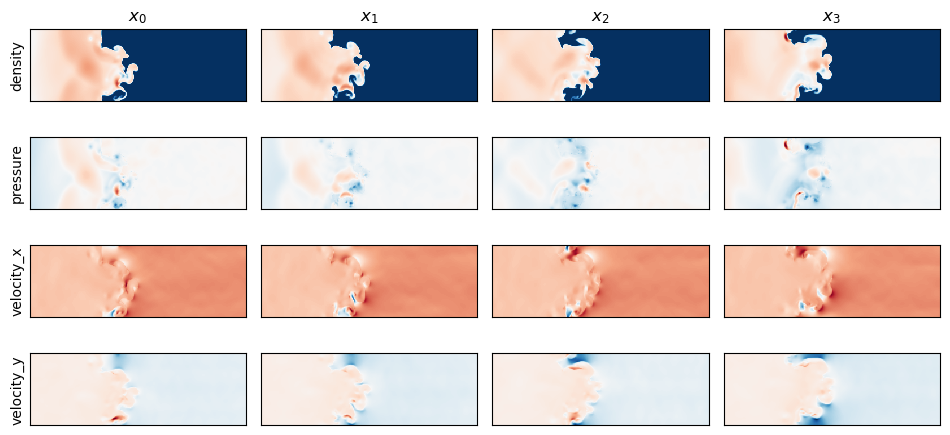

In [27]:
x = dataset[42]["input_fields"]
x = rearrange(x, "T Lx Ly F -> F T Lx Ly")

fig, axs = plt.subplots(F, 4, figsize=(4 * 2.4, F * 1.2))

for field in range(F):
    vmin = np.nanmin(x[field])
    vmax = np.nanmax(x[field])

    axs[field, 0].set_ylabel(f"{field_names[field]}")

    for t in range(4):
        axs[field, t].imshow(
            x[field, t], cmap="RdBu_r", interpolation="none", vmin=vmin, vmax=vmax
        )
        axs[field, t].set_xticks([])
        axs[field, t].set_yticks([])

        axs[0, t].set_title(f"$x_{t}$")

plt.tight_layout()

# Processing

Dans la plupart des datasets de The Well, certaines grandeurs sont toujours positives et/ou varient fortement en amplitude. Ces grandeurs doivent être prétraitées avant d'être passées à un réseau de neurones.

Dans ce notebook, nous standardisons les champs par rapport à leur moyenne et leur écart-type calculés sur un sous-ensemble de l'ensemble d'entraînement. 

In [17]:
xs = []

for i in range(0, 2000, 100):
    x = dataset[i]["input_fields"]
    xs.append(x)

xs = torch.stack(xs)
xs = xs.to(device)

In [19]:
mu = xs.reshape(-1, F).mean(dim=0)
sigma = xs.reshape(-1, F).std(dim=0)

In [21]:
def preprocess(x):
    return (x - mu.to(x.device)) / sigma.to(x.device)

def postprocess(x):
    return sigma.to(x.device) * x + mu.to(x.device)

# Training

Nous entraînons plusieurs architectures de réseaux de neurones pour prédire la dynamique du système :
- FNO (Fourier Neural Operator)
- CNN simple
- CNN2 (plus profond)
- SkipCNN (avec connections de type skip)
- CNN3 (encoder amélioré avec SiLU et GroupNorm)
- CNN4 (architecture plus profonde avec plus de convolutions)

Chaque modèle est entraîné pendant 20 epochs, en utilisant :

- L'optimiseur Adam
- Une réduction du learning rate tous les 5 epochs avec StepLR
- La loss MSE (Mean Squared Error)

L'évolution de la loss est suivie et comparée entre les différents modèles.

In [22]:
train_loader = torch.utils.data.DataLoader(dataset=dataset, shuffle=True, batch_size=4, num_workers = 0)

In [117]:
from torch.optim.lr_scheduler import StepLR

model_fno = FNO(
    n_modes=(16, 16),
    in_channels=4 * n_fields,
    out_channels=1 * n_fields,
    hidden_channels=128,
    n_layers=5,
).to(device)

optimizer_fno = torch.optim.Adam(model_fno.parameters(), lr=1e-3)
scheduler = StepLR(optimizer_fno, step_size=5, gamma=0.5)  # divise LR par 2 tous les 5 epochs

criterion_fno = nn.MSELoss()
losses_fno = []

for epoch in range(20):
    model_fno.train()
    epoch_loss = 0.0

    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"].to(device)
        x = preprocess(x)
        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")

        y = batch["output_fields"].to(device)
        y = preprocess(y)
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_fno.zero_grad()
        fx = model_fno(x)
        loss = criterion_fno(fx, y)
        loss.backward()
        optimizer_fno.step()

        epoch_loss += loss.item()
        bar.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    losses_fno.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    scheduler.step()

Epoch 1: 100%|██████████| 1746/1746 [04:30<00:00,  6.46it/s, loss=0.0261]


Epoch 1 average loss: 0.178344
Current LR: 0.001000


Epoch 2: 100%|██████████| 1746/1746 [04:23<00:00,  6.63it/s, loss=0.185] 


Epoch 2 average loss: 0.122401
Current LR: 0.001000


Epoch 3: 100%|██████████| 1746/1746 [04:25<00:00,  6.57it/s, loss=0.112]  


Epoch 3 average loss: 0.102787
Current LR: 0.001000


Epoch 4: 100%|██████████| 1746/1746 [04:54<00:00,  5.94it/s, loss=0.0274] 


Epoch 4 average loss: 0.094451
Current LR: 0.001000


Epoch 5: 100%|██████████| 1746/1746 [04:30<00:00,  6.46it/s, loss=0.144]  


Epoch 5 average loss: 0.077631
Current LR: 0.001000


Epoch 6: 100%|██████████| 1746/1746 [04:21<00:00,  6.67it/s, loss=0.0257] 


Epoch 6 average loss: 0.060199
Current LR: 0.000500


Epoch 7: 100%|██████████| 1746/1746 [04:23<00:00,  6.62it/s, loss=0.034]  


Epoch 7 average loss: 0.048898
Current LR: 0.000500


Epoch 8: 100%|██████████| 1746/1746 [04:19<00:00,  6.72it/s, loss=0.0195] 


Epoch 8 average loss: 0.045145
Current LR: 0.000500


Epoch 9: 100%|██████████| 1746/1746 [04:23<00:00,  6.64it/s, loss=0.0443] 


Epoch 9 average loss: 0.043842
Current LR: 0.000500


Epoch 10: 100%|██████████| 1746/1746 [04:18<00:00,  6.75it/s, loss=0.169]  


Epoch 10 average loss: 0.040405
Current LR: 0.000500


Epoch 11: 100%|██████████| 1746/1746 [04:17<00:00,  6.79it/s, loss=0.0102] 


Epoch 11 average loss: 0.034403
Current LR: 0.000250


Epoch 12: 100%|██████████| 1746/1746 [04:16<00:00,  6.81it/s, loss=0.0169] 


Epoch 12 average loss: 0.028871
Current LR: 0.000250


Epoch 13: 100%|██████████| 1746/1746 [04:29<00:00,  6.48it/s, loss=0.0345] 


Epoch 13 average loss: 0.026962
Current LR: 0.000250


Epoch 14: 100%|██████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.0244] 


Epoch 14 average loss: 0.026705
Current LR: 0.000250


Epoch 15: 100%|██████████| 1746/1746 [04:26<00:00,  6.54it/s, loss=0.0198] 


Epoch 15 average loss: 0.026248
Current LR: 0.000250


Epoch 16: 100%|██████████| 1746/1746 [04:24<00:00,  6.59it/s, loss=0.0133] 


Epoch 16 average loss: 0.023681
Current LR: 0.000125


Epoch 17: 100%|██████████| 1746/1746 [04:15<00:00,  6.84it/s, loss=0.0188] 


Epoch 17 average loss: 0.021089
Current LR: 0.000125


Epoch 18: 100%|██████████| 1746/1746 [04:15<00:00,  6.83it/s, loss=0.026]  


Epoch 18 average loss: 0.020238
Current LR: 0.000125


Epoch 19: 100%|██████████| 1746/1746 [04:15<00:00,  6.83it/s, loss=0.0233] 


Epoch 19 average loss: 0.019833
Current LR: 0.000125


Epoch 20: 100%|██████████| 1746/1746 [04:30<00:00,  6.45it/s, loss=0.0129] 

Epoch 20 average loss: 0.019683
Current LR: 0.000125


In [118]:
class CNN(nn.Module):
    def __init__(self, in_channels=16, out_channels=4, dropout=0.2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),  # 128x384 → 64x192
            nn.Dropout(dropout),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        )

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.output_layer(x)
        return x

In [119]:
model_cnn = CNN(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
scheduler = StepLR(optimizer_cnn, step_size=5, gamma=0.5)
criterion_cnn = nn.MSELoss()
losses_cnn = []

for epoch in range(20):
    model_cnn.train()
    epoch_loss = 0.0

    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"].to(device)
        x = preprocess(x)
        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")

        y = batch["output_fields"].to(device)
        y = preprocess(y)
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_cnn.zero_grad()
        fx = model_cnn(x)
        loss = criterion_cnn(fx, y)
        loss.backward()
        optimizer_cnn.step()

        epoch_loss += loss.item()
        bar.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    losses_cnn.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    scheduler.step()

Epoch 1: 100%|██████████| 1746/1746 [01:31<00:00, 19.18it/s, loss=0.265] 


Epoch 1 average loss: 0.293875
Current LR: 0.001000


Epoch 2: 100%|██████████| 1746/1746 [01:30<00:00, 19.26it/s, loss=0.109] 


Epoch 2 average loss: 0.263171
Current LR: 0.001000


Epoch 3: 100%|██████████| 1746/1746 [01:31<00:00, 19.17it/s, loss=0.13]  


Epoch 3 average loss: 0.254672
Current LR: 0.001000


Epoch 4: 100%|██████████| 1746/1746 [01:31<00:00, 19.18it/s, loss=0.489] 


Epoch 4 average loss: 0.247982
Current LR: 0.001000


Epoch 5: 100%|██████████| 1746/1746 [01:31<00:00, 19.15it/s, loss=0.0906]


Epoch 5 average loss: 0.248052
Current LR: 0.001000


Epoch 6: 100%|██████████| 1746/1746 [01:31<00:00, 19.16it/s, loss=0.0558]


Epoch 6 average loss: 0.230780
Current LR: 0.000500


Epoch 7: 100%|██████████| 1746/1746 [01:31<00:00, 19.14it/s, loss=0.125] 


Epoch 7 average loss: 0.232417
Current LR: 0.000500


Epoch 8: 100%|██████████| 1746/1746 [01:31<00:00, 19.13it/s, loss=0.176] 


Epoch 8 average loss: 0.233263
Current LR: 0.000500


Epoch 9: 100%|██████████| 1746/1746 [01:31<00:00, 19.07it/s, loss=0.0952]


Epoch 9 average loss: 0.237477
Current LR: 0.000500


Epoch 10: 100%|██████████| 1746/1746 [01:31<00:00, 19.02it/s, loss=0.124] 


Epoch 10 average loss: 0.232095
Current LR: 0.000500


Epoch 11: 100%|██████████| 1746/1746 [01:32<00:00, 18.93it/s, loss=0.165] 


Epoch 11 average loss: 0.222230
Current LR: 0.000250


Epoch 12: 100%|██████████| 1746/1746 [01:36<00:00, 18.11it/s, loss=0.0794]


Epoch 12 average loss: 0.226447
Current LR: 0.000250


Epoch 13: 100%|██████████| 1746/1746 [01:33<00:00, 18.59it/s, loss=1.3]   


Epoch 13 average loss: 0.226665
Current LR: 0.000250


Epoch 14: 100%|██████████| 1746/1746 [01:33<00:00, 18.59it/s, loss=0.119] 


Epoch 14 average loss: 0.222279
Current LR: 0.000250


Epoch 15: 100%|██████████| 1746/1746 [01:33<00:00, 18.62it/s, loss=0.0735]


Epoch 15 average loss: 0.219608
Current LR: 0.000250


Epoch 16: 100%|██████████| 1746/1746 [01:32<00:00, 18.89it/s, loss=0.149] 


Epoch 16 average loss: 0.222750
Current LR: 0.000125


Epoch 17: 100%|██████████| 1746/1746 [01:34<00:00, 18.49it/s, loss=0.0787]


Epoch 17 average loss: 0.215672
Current LR: 0.000125


Epoch 18: 100%|██████████| 1746/1746 [01:34<00:00, 18.57it/s, loss=0.218] 


Epoch 18 average loss: 0.215469
Current LR: 0.000125


Epoch 19: 100%|██████████| 1746/1746 [01:32<00:00, 18.78it/s, loss=0.0838]


Epoch 19 average loss: 0.216311
Current LR: 0.000125


Epoch 20: 100%|██████████| 1746/1746 [01:36<00:00, 18.06it/s, loss=0.102] 

Epoch 20 average loss: 0.226623
Current LR: 0.000125


In [120]:
class SkipCNN(nn.Module):
    def __init__(self, in_channels=16, out_channels=4, dropout=0.2):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.enc2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),  # 128x384 → 64x192
            nn.Dropout(dropout),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)

        self.decoder = nn.Sequential(
            nn.Conv2d(64 + 128, 64, kernel_size=3, padding=1),  # concat avec skip
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip = self.enc1(x)         
        x = self.enc2(skip)
        x = self.up(x)              
        x = torch.cat([x, skip], dim=1) 
        x = self.decoder(x)
        return self.output_layer(x)

In [121]:
model_skipcnn = SkipCNN(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

optimizer_skipcnn = torch.optim.Adam(model_skipcnn.parameters(), lr=1e-3)
scheduler = StepLR(optimizer_skipcnn, step_size=5, gamma=0.5)
criterion_skipcnn = nn.MSELoss()
losses_skipcnn = []

for epoch in range(20):
    model_skipcnn.train()
    epoch_loss = 0.0

    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"]
        x = x.to(device)
        x = preprocess(x)
        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")

        y = batch["output_fields"]
        y = y.to(device)
        y = preprocess(y)
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_skipcnn.zero_grad()
        fx = model_skipcnn(x)
        loss = criterion_skipcnn(fx, y)
        loss.backward()
        optimizer_skipcnn.step()

        epoch_loss += loss.item()
        bar.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    losses_skipcnn.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    scheduler.step()

Epoch 1: 100%|██████████| 1746/1746 [02:03<00:00, 14.19it/s, loss=0.507] 


Epoch 1 average loss: 0.293004
Current LR: 0.001000


Epoch 2: 100%|██████████| 1746/1746 [01:59<00:00, 14.59it/s, loss=0.115] 


Epoch 2 average loss: 0.247221
Current LR: 0.001000


Epoch 3: 100%|██████████| 1746/1746 [01:59<00:00, 14.64it/s, loss=0.494] 


Epoch 3 average loss: 0.244035
Current LR: 0.001000


Epoch 4: 100%|██████████| 1746/1746 [01:59<00:00, 14.59it/s, loss=0.122] 


Epoch 4 average loss: 0.236411
Current LR: 0.001000


Epoch 5: 100%|██████████| 1746/1746 [01:59<00:00, 14.60it/s, loss=0.145] 


Epoch 5 average loss: 0.233961
Current LR: 0.001000


Epoch 6: 100%|██████████| 1746/1746 [01:59<00:00, 14.61it/s, loss=0.11]  


Epoch 6 average loss: 0.223209
Current LR: 0.000500


Epoch 7: 100%|██████████| 1746/1746 [01:59<00:00, 14.60it/s, loss=0.0635]


Epoch 7 average loss: 0.224157
Current LR: 0.000500


Epoch 8: 100%|██████████| 1746/1746 [01:59<00:00, 14.57it/s, loss=0.128] 


Epoch 8 average loss: 0.220039
Current LR: 0.000500


Epoch 9: 100%|██████████| 1746/1746 [01:59<00:00, 14.57it/s, loss=0.0991]


Epoch 9 average loss: 0.219459
Current LR: 0.000500


Epoch 10: 100%|██████████| 1746/1746 [01:59<00:00, 14.55it/s, loss=0.0788]


Epoch 10 average loss: 0.216279
Current LR: 0.000500


Epoch 11: 100%|██████████| 1746/1746 [01:59<00:00, 14.58it/s, loss=0.368] 


Epoch 11 average loss: 0.211571
Current LR: 0.000250


Epoch 12: 100%|██████████| 1746/1746 [01:59<00:00, 14.57it/s, loss=0.0679]


Epoch 12 average loss: 0.216110
Current LR: 0.000250


Epoch 13: 100%|██████████| 1746/1746 [02:00<00:00, 14.53it/s, loss=0.108] 


Epoch 13 average loss: 0.217066
Current LR: 0.000250


Epoch 14: 100%|██████████| 1746/1746 [02:00<00:00, 14.53it/s, loss=0.112] 


Epoch 14 average loss: 0.217705
Current LR: 0.000250


Epoch 15: 100%|██████████| 1746/1746 [01:59<00:00, 14.66it/s, loss=0.202] 


Epoch 15 average loss: 0.208659
Current LR: 0.000250


Epoch 16: 100%|██████████| 1746/1746 [01:59<00:00, 14.62it/s, loss=0.179] 


Epoch 16 average loss: 0.207842
Current LR: 0.000125


Epoch 17: 100%|██████████| 1746/1746 [01:59<00:00, 14.60it/s, loss=0.134] 


Epoch 17 average loss: 0.210433
Current LR: 0.000125


Epoch 18: 100%|██████████| 1746/1746 [01:59<00:00, 14.63it/s, loss=0.122] 


Epoch 18 average loss: 0.205556
Current LR: 0.000125


Epoch 19: 100%|██████████| 1746/1746 [01:59<00:00, 14.63it/s, loss=0.252] 


Epoch 19 average loss: 0.208978
Current LR: 0.000125


Epoch 20: 100%|██████████| 1746/1746 [01:59<00:00, 14.63it/s, loss=0.129] 

Epoch 20 average loss: 0.209129
Current LR: 0.000125


In [122]:
class CNN2(nn.Module):
    def __init__(self, in_channels=16, out_channels=4, dropout=0.2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.MaxPool2d(kernel_size=2),  # 128x384 → 64x192
            nn.Dropout(dropout),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(256),

            nn.Conv2d(256, 128, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 64x192 → 128x384
        )

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.output_layer(x)
        return x


In [123]:
model_cnn2 = CNN2(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

optimizer_cnn2 = torch.optim.Adam(model_cnn2.parameters(), lr=1e-3)
scheduler = StepLR(optimizer_cnn2, step_size=5, gamma=0.5)
criterion_cnn2 = nn.MSELoss()
losses_cnn2 = []

for epoch in range(20):
    model_cnn2.train()
    epoch_loss = 0.0

    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"].to(device)
        x = preprocess(x)
        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")

        y = batch["output_fields"].to(device)
        y = preprocess(y)
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_cnn2.zero_grad()
        fx = model_cnn2(x)
        loss = criterion_cnn2(fx, y)
        loss.backward()
        optimizer_cnn2.step()

        epoch_loss += loss.item()
        bar.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    losses_cnn2.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    scheduler.step()

Epoch 1: 100%|██████████| 1746/1746 [02:17<00:00, 12.69it/s, loss=0.897] 


Epoch 1 average loss: 0.311242
Current LR: 0.001000


Epoch 2: 100%|██████████| 1746/1746 [02:17<00:00, 12.69it/s, loss=0.891] 


Epoch 2 average loss: 0.271944
Current LR: 0.001000


Epoch 3: 100%|██████████| 1746/1746 [02:17<00:00, 12.66it/s, loss=0.182] 


Epoch 3 average loss: 0.249162
Current LR: 0.001000


Epoch 4: 100%|██████████| 1746/1746 [02:17<00:00, 12.66it/s, loss=0.068] 


Epoch 4 average loss: 0.243447
Current LR: 0.001000


Epoch 5: 100%|██████████| 1746/1746 [02:17<00:00, 12.66it/s, loss=0.157] 


Epoch 5 average loss: 0.239556
Current LR: 0.001000


Epoch 6: 100%|██████████| 1746/1746 [02:17<00:00, 12.68it/s, loss=0.195] 


Epoch 6 average loss: 0.221249
Current LR: 0.000500


Epoch 7: 100%|██████████| 1746/1746 [02:17<00:00, 12.66it/s, loss=0.132] 


Epoch 7 average loss: 0.221444
Current LR: 0.000500


Epoch 8: 100%|██████████| 1746/1746 [02:17<00:00, 12.67it/s, loss=0.119] 


Epoch 8 average loss: 0.221533
Current LR: 0.000500


Epoch 9: 100%|██████████| 1746/1746 [02:18<00:00, 12.65it/s, loss=0.0967]


Epoch 9 average loss: 0.216789
Current LR: 0.000500


Epoch 10: 100%|██████████| 1746/1746 [02:18<00:00, 12.63it/s, loss=0.145] 


Epoch 10 average loss: 0.216457
Current LR: 0.000500


Epoch 11: 100%|██████████| 1746/1746 [02:18<00:00, 12.61it/s, loss=0.187] 


Epoch 11 average loss: 0.210243
Current LR: 0.000250


Epoch 12: 100%|██████████| 1746/1746 [02:18<00:00, 12.61it/s, loss=0.0778]


Epoch 12 average loss: 0.216029
Current LR: 0.000250


Epoch 13: 100%|██████████| 1746/1746 [02:18<00:00, 12.63it/s, loss=0.169] 


Epoch 13 average loss: 0.206444
Current LR: 0.000250


Epoch 14: 100%|██████████| 1746/1746 [02:18<00:00, 12.60it/s, loss=0.0999]


Epoch 14 average loss: 0.212835
Current LR: 0.000250


Epoch 15: 100%|██████████| 1746/1746 [02:18<00:00, 12.60it/s, loss=0.499] 


Epoch 15 average loss: 0.207784
Current LR: 0.000250


Epoch 16: 100%|██████████| 1746/1746 [02:18<00:00, 12.60it/s, loss=0.464] 


Epoch 16 average loss: 0.203610
Current LR: 0.000125


Epoch 17: 100%|██████████| 1746/1746 [02:18<00:00, 12.60it/s, loss=0.0641]


Epoch 17 average loss: 0.207751
Current LR: 0.000125


Epoch 18: 100%|██████████| 1746/1746 [02:19<00:00, 12.55it/s, loss=0.0754]


Epoch 18 average loss: 0.204086
Current LR: 0.000125


Epoch 19: 100%|██████████| 1746/1746 [02:19<00:00, 12.48it/s, loss=0.189] 


Epoch 19 average loss: 0.197378
Current LR: 0.000125


Epoch 20: 100%|██████████| 1746/1746 [02:19<00:00, 12.54it/s, loss=0.103] 

Epoch 20 average loss: 0.203483
Current LR: 0.000125


In [133]:
class CNN3(nn.Module):
    def __init__(self, in_channels=16, out_channels=4, dropout=0.2):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 128),
        )

        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 256),

            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 128),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 64),
        )

        self.up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)

        self.decoder = nn.Sequential(
            nn.Conv2d(64 + 128, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 64),
        )

        self.refine = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 64)
        )

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip = self.enc1(x)            
        x = self.enc2(skip)            
        x = self.up(x)                 
        x = torch.cat([x, skip], dim=1) 
        x = self.decoder(x)
        x = self.refine(x)
        return self.output_layer(x)


In [134]:
model_cnn3 = CNN3(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

optimizer_cnn3 = torch.optim.Adam(model_cnn3.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = StepLR(optimizer_cnn3, step_size=5, gamma=0.5)
criterion_cnn3 = nn.MSELoss() 
losses_cnn3 = []

for epoch in range(20):
    model_cnn3.train()
    epoch_loss = 0.0

    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"].to(device)
        y = batch["output_fields"].to(device)

        x = preprocess(x)  
        y = preprocess(y)

        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_cnn3.zero_grad()
        fx = model_cnn3(x)
        loss = criterion_cnn3(fx, y)
        loss.backward()
        optimizer_cnn3.step()

        epoch_loss += loss.item()
        bar.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    losses_cnn3.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    scheduler.step()


Epoch 1: 100%|██████████| 1746/1746 [03:02<00:00,  9.56it/s, loss=0.39]  


Epoch 1 average loss: 0.193235
Current LR: 0.001000


Epoch 2: 100%|██████████| 1746/1746 [03:01<00:00,  9.64it/s, loss=0.102]  


Epoch 2 average loss: 0.152155
Current LR: 0.001000


Epoch 3: 100%|██████████| 1746/1746 [03:00<00:00,  9.68it/s, loss=0.111]  


Epoch 3 average loss: 0.137710
Current LR: 0.001000


Epoch 4: 100%|██████████| 1746/1746 [02:59<00:00,  9.71it/s, loss=0.0101] 


Epoch 4 average loss: 0.130156
Current LR: 0.001000


Epoch 5: 100%|██████████| 1746/1746 [02:58<00:00,  9.78it/s, loss=0.219]  


Epoch 5 average loss: 0.127279
Current LR: 0.001000


Epoch 6: 100%|██████████| 1746/1746 [02:58<00:00,  9.78it/s, loss=0.22]   


Epoch 6 average loss: 0.113725
Current LR: 0.000500


Epoch 7: 100%|██████████| 1746/1746 [02:58<00:00,  9.76it/s, loss=0.0212] 


Epoch 7 average loss: 0.111907
Current LR: 0.000500


Epoch 8: 100%|██████████| 1746/1746 [03:02<00:00,  9.55it/s, loss=0.111]  


Epoch 8 average loss: 0.109606
Current LR: 0.000500


Epoch 9: 100%|██████████| 1746/1746 [03:00<00:00,  9.66it/s, loss=0.0192] 


Epoch 9 average loss: 0.108782
Current LR: 0.000500


Epoch 10: 100%|██████████| 1746/1746 [03:00<00:00,  9.68it/s, loss=0.0226] 


Epoch 10 average loss: 0.107508
Current LR: 0.000500


Epoch 11: 100%|██████████| 1746/1746 [02:59<00:00,  9.72it/s, loss=0.104]  


Epoch 11 average loss: 0.100916
Current LR: 0.000250


Epoch 12: 100%|██████████| 1746/1746 [02:59<00:00,  9.71it/s, loss=0.125]  


Epoch 12 average loss: 0.099716
Current LR: 0.000250


Epoch 13: 100%|██████████| 1746/1746 [03:00<00:00,  9.69it/s, loss=0.147]  


Epoch 13 average loss: 0.099158
Current LR: 0.000250


Epoch 14: 100%|██████████| 1746/1746 [03:03<00:00,  9.54it/s, loss=0.00525]


Epoch 14 average loss: 0.097944
Current LR: 0.000250


Epoch 15: 100%|██████████| 1746/1746 [03:00<00:00,  9.66it/s, loss=0.0696] 


Epoch 15 average loss: 0.097501
Current LR: 0.000250


Epoch 16: 100%|██████████| 1746/1746 [02:59<00:00,  9.73it/s, loss=0.0678] 


Epoch 16 average loss: 0.093685
Current LR: 0.000125


Epoch 17: 100%|██████████| 1746/1746 [02:59<00:00,  9.73it/s, loss=0.0299] 


Epoch 17 average loss: 0.092979
Current LR: 0.000125


Epoch 18: 100%|██████████| 1746/1746 [02:59<00:00,  9.72it/s, loss=0.00614]


Epoch 18 average loss: 0.092344
Current LR: 0.000125


Epoch 19: 100%|██████████| 1746/1746 [02:59<00:00,  9.70it/s, loss=0.0524] 


Epoch 19 average loss: 0.092031
Current LR: 0.000125


Epoch 20: 100%|██████████| 1746/1746 [03:02<00:00,  9.58it/s, loss=0.195]  

Epoch 20 average loss: 0.091562
Current LR: 0.000125


In [27]:
class CNN4(nn.Module):
    def __init__(self, in_channels=16, out_channels=4, dropout=0.2):
        super().__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 64),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 128),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 💥 ajouté
            nn.SiLU(),
            nn.GroupNorm(8, 128),
        )

        self.enc2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(dropout),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 256),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 💥 ajouté
            nn.SiLU(),
            nn.GroupNorm(8, 256),

            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 128),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 64),
        )

        self.up = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)

        self.decoder = nn.Sequential(
            nn.Conv2d(64 + 128, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 128),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 64)
        )

        self.refine = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 64),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.GroupNorm(8, 64),
        )

        self.output_layer = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip = self.enc1(x)         
        x = self.enc2(skip)
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.decoder(x)
        x = self.refine(x)
        return self.output_layer(x)

In [143]:
model_cnn4 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

optimizer_cnn4 = torch.optim.Adam(model_cnn4.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = StepLR(optimizer_cnn4, step_size=5, gamma=0.5)
criterion_cnn4 = nn.MSELoss() 
losses_cnn4 = []

for epoch in range(20):
    model_cnn4.train()
    epoch_loss = 0.0
²
    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"].to(device)
        y = batch["output_fields"].to(device)

        x = preprocess(x)  
        y = preprocess(y)

        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_cnn4.zero_grad()
        fx = model_cnn4(x)
        loss = criterion_cnn4(fx, y)
        loss.backward()
        optimizer_cnn4.step()

        epoch_loss += loss.item()
        bar.set_postfix(loss=loss.item())

    avg_loss = epoch_loss / len(train_loader)
    losses_cnn4.append(avg_loss)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"Current LR: {scheduler.get_last_lr()[0]:.6f}")

    scheduler.step()

Epoch 1: 100%|██████████| 1746/1746 [04:37<00:00,  6.30it/s, loss=0.121] 


Epoch 1 average loss: 0.214566
Current LR: 0.001000


Epoch 2: 100%|██████████| 1746/1746 [04:33<00:00,  6.38it/s, loss=0.0657] 


Epoch 2 average loss: 0.165728
Current LR: 0.001000


Epoch 3: 100%|██████████| 1746/1746 [04:33<00:00,  6.39it/s, loss=0.151]  


Epoch 3 average loss: 0.146083
Current LR: 0.001000


Epoch 4: 100%|██████████| 1746/1746 [04:35<00:00,  6.33it/s, loss=0.0257] 


Epoch 4 average loss: 0.132810
Current LR: 0.001000


Epoch 5: 100%|██████████| 1746/1746 [04:39<00:00,  6.26it/s, loss=0.0776] 


Epoch 5 average loss: 0.125702
Current LR: 0.001000


Epoch 6: 100%|██████████| 1746/1746 [04:47<00:00,  6.08it/s, loss=0.0353] 


Epoch 6 average loss: 0.109432
Current LR: 0.000500


Epoch 7: 100%|██████████| 1746/1746 [04:43<00:00,  6.15it/s, loss=0.127]  


Epoch 7 average loss: 0.107131
Current LR: 0.000500


Epoch 8: 100%|██████████| 1746/1746 [04:42<00:00,  6.19it/s, loss=0.0604] 


Epoch 8 average loss: 0.103195
Current LR: 0.000500


Epoch 9: 100%|██████████| 1746/1746 [04:37<00:00,  6.29it/s, loss=0.0105] 


Epoch 9 average loss: 0.101184
Current LR: 0.000500


Epoch 10: 100%|██████████| 1746/1746 [04:37<00:00,  6.29it/s, loss=0.135]  


Epoch 10 average loss: 0.100170
Current LR: 0.000500


Epoch 11: 100%|██████████| 1746/1746 [04:37<00:00,  6.28it/s, loss=0.247]  


Epoch 11 average loss: 0.091468
Current LR: 0.000250


Epoch 12: 100%|██████████| 1746/1746 [04:37<00:00,  6.28it/s, loss=0.0849] 


Epoch 12 average loss: 0.090186
Current LR: 0.000250


Epoch 13: 100%|██████████| 1746/1746 [04:41<00:00,  6.20it/s, loss=0.0642] 


Epoch 13 average loss: 0.088823
Current LR: 0.000250


Epoch 14: 100%|██████████| 1746/1746 [04:38<00:00,  6.28it/s, loss=0.186]  


Epoch 14 average loss: 0.088184
Current LR: 0.000250


Epoch 15: 100%|██████████| 1746/1746 [04:37<00:00,  6.29it/s, loss=0.0413] 


Epoch 15 average loss: 0.087018
Current LR: 0.000250


Epoch 16: 100%|██████████| 1746/1746 [04:37<00:00,  6.30it/s, loss=0.102]  


Epoch 16 average loss: 0.082540
Current LR: 0.000125


Epoch 17: 100%|██████████| 1746/1746 [04:35<00:00,  6.34it/s, loss=0.208]  


Epoch 17 average loss: 0.081649
Current LR: 0.000125


Epoch 18: 100%|██████████| 1746/1746 [04:35<00:00,  6.35it/s, loss=0.00512]


Epoch 18 average loss: 0.080930
Current LR: 0.000125


Epoch 19: 100%|██████████| 1746/1746 [04:39<00:00,  6.24it/s, loss=0.15]   


Epoch 19 average loss: 0.080551
Current LR: 0.000125


Epoch 20: 100%|██████████| 1746/1746 [04:38<00:00,  6.26it/s, loss=0.0835] 

Epoch 20 average loss: 0.080202
Current LR: 0.000125


## Training loss
Deux figures principales sont tracées :
- Comparaison de la loss d'entraînement entre tous les modèles CNN
- Comparaison directe entre CNN4 et FNO

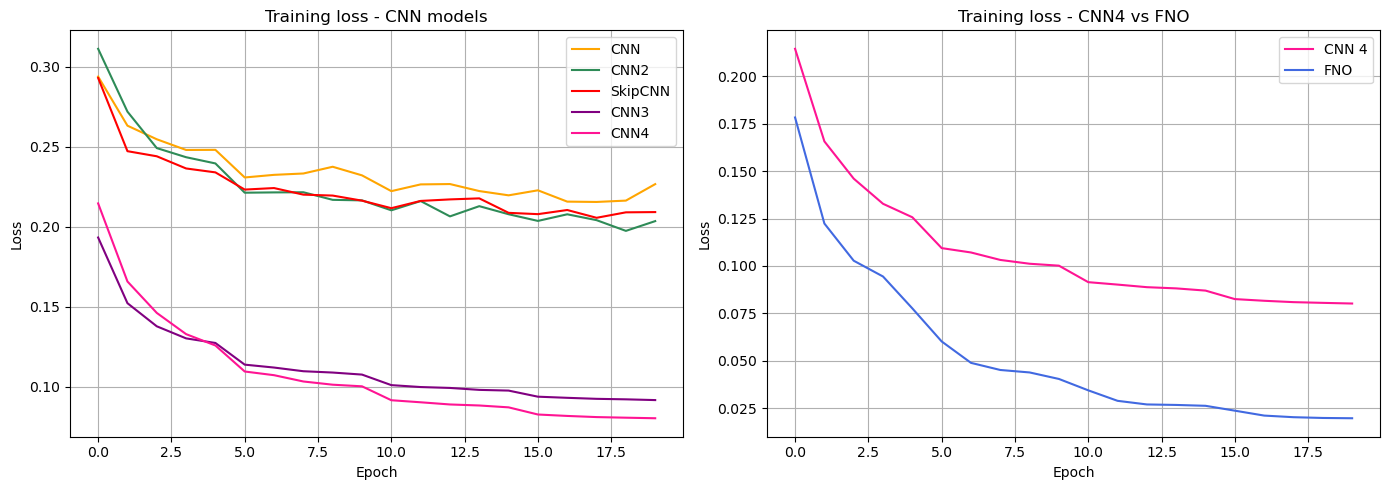

In [246]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
colors = {
    "CNN": 'orange',
    "CNN2": 'seagreen',
    "SkipCNN": 'red',
    "CNN3": 'purple',
    "CNN4": 'gold',
    "FNO": 'royalblue'
}
axs[0].plot(losses_cnn, label="CNN", color="orange")
axs[0].plot(losses_cnn2, label="CNN2", color="seagreen")
axs[0].plot(losses_skipcnn, label="SkipCNN", color="red")
axs[0].plot(losses_cnn3, label="CNN3",color="purple")
axs[0].plot(losses_cnn4, label="CNN4", color="deeppink")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training loss - CNN models")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(losses_cnn4, label="CNN 4", color="deeppink")
axs[1].plot(losses_fno, label="FNO", color="royalblue")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].set_title("Training loss - CNN4 vs FNO")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.show()

# Validation

Nous évaluons nos modèles sur l'ensemble de validation.

Nous utilisons les métriques suivantes pour mesurer les performances :
- MSE (Erreur quadratique moyenne)
- VRMSE (Root Mean Squared Error normalisé par l'écart-type du champ)

Chaque modèle est évalué indépendamment sur les quatre champs physiques : density, pressure, velocity_x, velocity_y

In [33]:
validset = WellDataset(
    well_base_path=base_path,
    well_dataset_name="turbulent_radiative_layer_2D",
    well_split_name="valid",
    n_steps_input=4,
    n_steps_output=1,
    use_normalization=False,
)

In [202]:
val_loader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=False)
field_names = ['density', 'pressure', 'velocity_x', 'velocity_y']
F = len(field_names)

model_fno.eval()
model_cnn.eval()
model_cnn2.eval()
model_skipcnn.eval()
model_cnn3.eval()
model_cnn4.eval()

vrmse_fno_all, vrmse_cnn_all, vrmse_cnn2_all, vrmse_skipcnn_all, vrmse_cnn3_all, vrmse_cnn4_all = [], [], [], [], [], []
mse_fno_all, mse_cnn_all, mse_cnn2_all, mse_skipcnn_all, mse_cnn3_all, mse_cnn4_all = [], [], [], [], [], []

for item in tqdm(val_loader, desc="Validation FNO vs CNN vs CNN2 vs SkipCNN vs CNN3 vs CNN4"):
    x = item["input_fields"].squeeze(0)        # (4, H, W, 4)
    y = item["output_fields"].squeeze(0)[0]    # (H, W, 4)
    y = y.to(device)

    x = preprocess(x)
    x_in = rearrange(x, "T H W F -> 1 (T F) H W")
    x_in = x_in.to(device)

    with torch.no_grad():
        # Prédictions
        pred_fno = model_fno(x_in).squeeze(0)
        pred_fno = rearrange(pred_fno, "(T F) H W -> T H W F", T=1, F=4)[0]
        pred_fno = postprocess(pred_fno)

        pred_cnn = model_cnn(x_in).squeeze(0).permute(1, 2, 0)
        pred_cnn = postprocess(pred_cnn)

        pred_cnn2 = model_cnn2(x_in).squeeze(0).permute(1, 2, 0)
        pred_cnn2 = postprocess(pred_cnn2)

        pred_skipcnn = model_skipcnn(x_in).squeeze(0).permute(1, 2, 0)
        pred_skipcnn = postprocess(pred_skipcnn)

        pred_cnn3 = model_cnn3(x_in).squeeze(0).permute(1, 2, 0)
        pred_cnn3 = postprocess(pred_cnn3)

        pred_cnn4 = model_cnn4(x_in).squeeze(0).permute(1, 2, 0)
        pred_cnn4 = postprocess(pred_cnn4)

    # Calcul par champ
    vrmse_fno_sample, vrmse_cnn_sample, vrmse_cnn2_sample, vrmse_skipcnn_sample, vrmse_cnn3_sample, vrmse_cnn4_sample = [], [], [], [], [], []
    mse_fno_sample, mse_cnn_sample, mse_cnn2_sample, mse_skipcnn_sample, mse_cnn3_sample, mse_cnn4_sample = [], [], [], [], [], []

    for i in range(4):
        gt = y[:, :, i]
        std_gt = torch.std(gt) + 1e-8

        # FNO
        err_fno = pred_fno[:, :, i] - gt
        mse_fno = torch.mean(err_fno ** 2)
        vrmse_fno = torch.sqrt(mse_fno) / std_gt
        mse_fno_sample.append(mse_fno.item())
        vrmse_fno_sample.append(vrmse_fno.item())

        # CNN
        err_cnn = pred_cnn[:, :, i] - gt
        mse_cnn = torch.mean(err_cnn ** 2)
        vrmse_cnn = torch.sqrt(mse_cnn) / std_gt
        mse_cnn_sample.append(mse_cnn.item())
        vrmse_cnn_sample.append(vrmse_cnn.item())

        # CNN2
        err_cnn2 = pred_cnn2[:, :, i] - gt
        mse_cnn2 = torch.mean(err_cnn2 ** 2)
        vrmse_cnn2 = torch.sqrt(mse_cnn2) / std_gt
        mse_cnn2_sample.append(mse_cnn2.item())
        vrmse_cnn2_sample.append(vrmse_cnn2.item())

        # SkipCNN
        err_skipcnn = pred_skipcnn[:, :, i] - gt
        mse_skipcnn = torch.mean(err_skipcnn ** 2)
        vrmse_skipcnn = torch.sqrt(mse_skipcnn) / std_gt
        mse_skipcnn_sample.append(mse_skipcnn.item())
        vrmse_skipcnn_sample.append(vrmse_skipcnn.item())

        # CNN3
        err_cnn3 = pred_cnn3[:, :, i] - gt
        mse_cnn3 = torch.mean(err_cnn3 ** 2)
        vrmse_cnn3 = torch.sqrt(mse_cnn3) / std_gt
        mse_cnn3_sample.append(mse_cnn3.item())
        vrmse_cnn3_sample.append(vrmse_cnn3.item())

        # CNN4
        err_cnn4 = pred_cnn4[:, :, i] - gt
        mse_cnn4 = torch.mean(err_cnn4 ** 2)
        vrmse_cnn4 = torch.sqrt(mse_cnn4) / std_gt
        mse_cnn4_sample.append(mse_cnn4.item())
        vrmse_cnn4_sample.append(vrmse_cnn4.item())

    mse_fno_all.append(mse_fno_sample)
    mse_cnn_all.append(mse_cnn_sample)
    mse_cnn2_all.append(mse_cnn2_sample)
    mse_skipcnn_all.append(mse_skipcnn_sample)
    mse_cnn3_all.append(mse_cnn3_sample)
    mse_cnn4_all.append(mse_cnn4_sample)

    vrmse_fno_all.append(vrmse_fno_sample)
    vrmse_cnn_all.append(vrmse_cnn_sample)
    vrmse_cnn2_all.append(vrmse_cnn2_sample)
    vrmse_skipcnn_all.append(vrmse_skipcnn_sample)
    vrmse_cnn3_all.append(vrmse_cnn3_sample)
    vrmse_cnn4_all.append(vrmse_cnn4_sample)

# Moyennes finales
mse_fno_avg = torch.tensor(mse_fno_all).mean(dim=0)
mse_cnn_avg = torch.tensor(mse_cnn_all).mean(dim=0)
mse_cnn2_avg = torch.tensor(mse_cnn2_all).mean(dim=0)
mse_skipcnn_avg = torch.tensor(mse_skipcnn_all).mean(dim=0)
mse_cnn3_avg = torch.tensor(mse_cnn3_all).mean(dim=0)
mse_cnn4_avg = torch.tensor(mse_cnn4_all).mean(dim=0)

vrmse_fno_avg = torch.tensor(vrmse_fno_all).mean(dim=0)
vrmse_cnn_avg = torch.tensor(vrmse_cnn_all).mean(dim=0)
vrmse_cnn2_avg = torch.tensor(vrmse_cnn2_all).mean(dim=0)
vrmse_skipcnn_avg = torch.tensor(vrmse_skipcnn_all).mean(dim=0)
vrmse_cnn3_avg = torch.tensor(vrmse_cnn3_all).mean(dim=0)
vrmse_cnn4_avg = torch.tensor(vrmse_cnn4_all).mean(dim=0)

Validation FNO vs CNN vs CNN2 vs SkipCNN vs CNN3 vs CNN4: 100%|██████████| 873/873 [00:53<00:00, 16.29it/s]


Nous calculons les VRMSE moyens pour chaque champ et pour chaque modèle (FNO, CNN, CNN2, SkipCNN, CNN3, CNN4).
Ces résultats sont visualisés avec un barplot permettant de comparer les modèles entre eux.


-------------------------- Résultats VRMSE Moyen par Champ --------------------------
Champ                  FNO        CNN       CNN2    SkipCNN       CNN3       CNN4
-------------------------------------------------------------------------------------
density             0.1302     0.1318     0.1109     0.1176     0.1008     0.0962
pressure            0.6433     1.9410     1.2220     2.5330     0.8186     0.7996
velocity_x          0.1907     0.2092     0.1994     0.2017     0.1824     0.1740
velocity_y          0.3035     0.4779     0.3646     0.5760     0.2963     0.2822




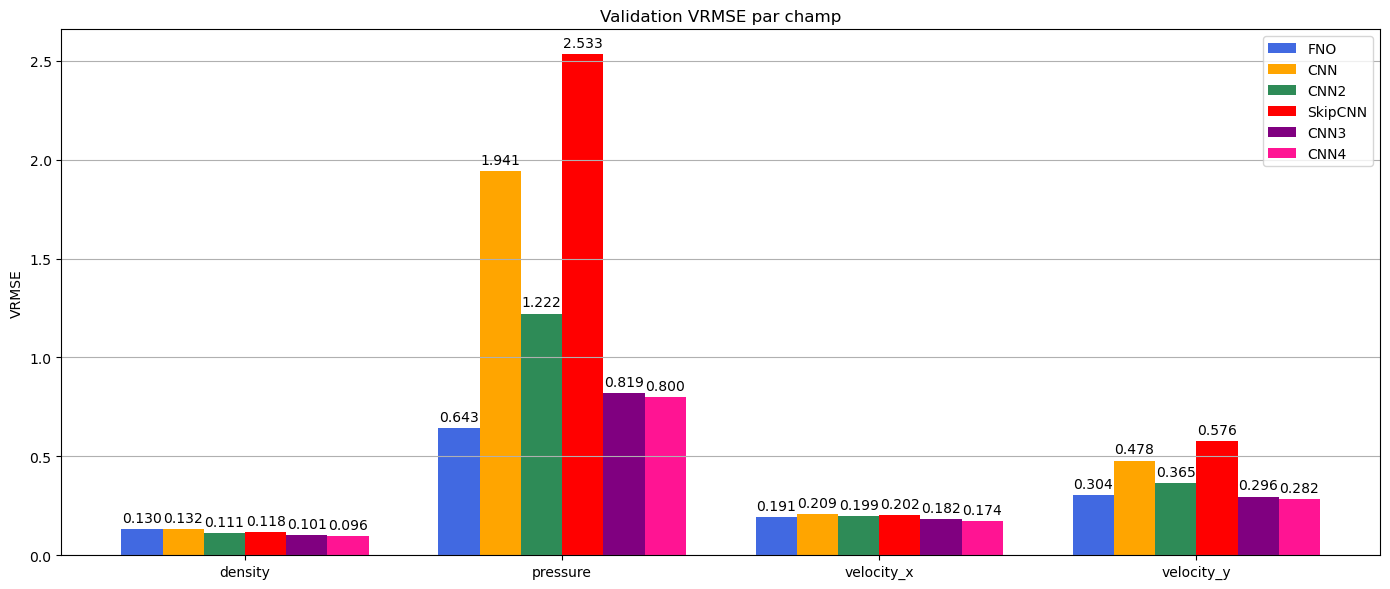

In [243]:
print("\n-------------------------- Résultats VRMSE Moyen par Champ --------------------------")
print(f"{'Champ':<15} {'FNO':>10} {'CNN':>10} {'CNN2':>10} {'SkipCNN':>10} {'CNN3':>10} {'CNN4':>10}")
print("-" * 85)

for i, field in enumerate(field_names):
    print(f"{field:<15} "
          f"{vrmse_fno_avg[i]:>10.4f} "
          f"{vrmse_cnn_avg[i]:>10.4f} "
          f"{vrmse_cnn2_avg[i]:>10.4f} "
          f"{vrmse_skipcnn_avg[i]:>10.4f} "
          f"{vrmse_cnn3_avg[i]:>10.4f} "
          f"{vrmse_cnn4_avg[i]:>10.4f}")

print("\n") 

x = np.arange(F)
width = 0.13  

colors = ['royalblue', 'orange', 'seagreen', 'red', 'purple', 'deeppink']

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - 2.5*width, vrmse_fno_avg, width, label='FNO', color=colors[0])
rects2 = ax.bar(x - 1.5*width, vrmse_cnn_avg, width, label='CNN', color=colors[1])
rects3 = ax.bar(x - 0.5*width, vrmse_cnn2_avg, width, label='CNN2', color=colors[2])
rects4 = ax.bar(x + 0.5*width, vrmse_skipcnn_avg, width, label='SkipCNN', color=colors[3])
rects5 = ax.bar(x + 1.5*width, vrmse_cnn3_avg, width, label='CNN3', color=colors[4])
rects6 = ax.bar(x + 2.5*width, vrmse_cnn4_avg, width, label='CNN4', color=colors[5])

ax.set_ylabel('VRMSE')
ax.set_title('Validation VRMSE par champ')
ax.set_xticks(x)
ax.set_xticklabels(field_names)
ax.legend()
ax.grid(True, axis='y')

# Ajouter les valeurs au-dessus des barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)
autolabel(rects6)

plt.tight_layout()
plt.show()


CNN4 est le modèle ayant les meilleurs scores VRMSE sur tous les champs, à l'exception du champs de pression où FNO est meilleur. 

# Physics-Informed Neural Networks (PINN)

Pour intégrer des connaissances physiques dans l'apprentissage, nous introduisons une contrainte basée sur la conservation de la masse.
$$\frac{\partial \rho}{\partial t} + \nabla \cdot (\rho \mathbf{v}) = 0$$
La loss PINN est définie comme la moyenne du carré du résidu de l'équation de conservation :

In [25]:
def compute_mass_pinn_loss(rho_t, pred_rho_tp1, pred_vx_tp1, pred_vy_tp1, dx=1.0, dy=1.0, dt=1.0):
    
    # Terme temporel ∂ρ/∂t
    d_rho_dt = (pred_rho_tp1 - rho_t) / dt

    # Flux en x et en y
    flux_x = pred_rho_tp1 * pred_vx_tp1
    flux_y = pred_rho_tp1 * pred_vy_tp1

    # Dérivées spatiales (divergence du flux de masse)
    grad_flux_x = torch.gradient(flux_x, spacing=(dx,), dim=2)[0]  # ∂(ρv_x)/∂x
    grad_flux_y = torch.gradient(flux_y, spacing=(dy,), dim=1)[0]  # ∂(ρv_y)/∂y

    # Divergence totale
    div_rhov = grad_flux_x + grad_flux_y

    # Résidu de l'équation de conservation
    residual = d_rho_dt + div_rhov

    # Loss PINN = MSE du résidu
    return torch.mean(residual ** 2)

Nous utilisons cette loss PINN en complément de la loss MSE classique, avec un poids $\beta$ :
$ \text{Loss totale} = \text{Loss MSE} + \beta \times \text{Loss PINN} $

## Training avec PINN

Nous choisissons d'utiliser le modèle CNN4 car il a obtenu les meilleurs résultats de VRMSE parmi tous les modèles testés précédemment lors de la validation. Son architecture plus profonde et ses blocs de raffinement permettent de mieux capturer la dynamique du système.

Nous entraînons CNN4 en intégrant la loss PINN pour renforcer la conservation physique de la masse.
Le modèle est entraîné pendant 20 epochs en minimisant la somme de la loss MSE et de la loss PINN.

Trois métriques sont suivies pendant l'entraînement : loss totale, loss MSE seule et la loss PINN seule.

L'objectif est d'améliorer la généralisation du modèle tout en respectant les lois physiques.

### Training et validation avec $\beta=0.1$ : 

In [28]:
model_cnn4_pinn = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

optimizer_cnn4_pinn = torch.optim.Adam(model_cnn4_pinn.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_pinn = StepLR(optimizer_cnn4_pinn, step_size=5, gamma=0.5)
criterion_cnn4_pinn = nn.MSELoss() 
losses_cnn4_pinn_total = []
losses_cnn4_pinn_mse = []
losses_cnn4_pinn_pinn = []

beta = 0.1  # Poids de la loss PINN

for epoch in range(20):
    model_cnn4_pinn.train()
    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_pinn = 0.0

    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"].to(device)
        y = batch["output_fields"].to(device)

        x = preprocess(x)  
        y = preprocess(y)

        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_cnn4_pinn.zero_grad()
        fx = model_cnn4_pinn(x)  # (B, 4, Lx, Ly)

        # Loss MSE
        loss_mse = criterion_cnn4_pinn(fx, y)

        # Loss PINN : conservation de la masse
        B, _, Lx, Ly = fx.shape
        F_phys = 4

        fx_reshaped = fx.view(B, 1, F_phys, Lx, Ly)  # (B, 1, F, Lx, Ly)
        pred_rho = fx_reshaped[:, 0, 0]  # density
        pred_vx  = fx_reshaped[:, 0, 2]  # velocity_x
        pred_vy  = fx_reshaped[:, 0, 3]  # velocity_y

        x_reshaped = x.view(B, 4, F_phys, Lx, Ly)  # (B, Ti=4, F, Lx, Ly)
        rho_t = x_reshaped[:, -1, 0]  # density au dernier input step (t=Ti-1)

        # Fonction de loss PINN (définie plus haut)
        loss_pinn = compute_mass_pinn_loss(rho_t, pred_rho, pred_vx, pred_vy)

        # Loss totale
        loss_total = loss_mse + beta * loss_pinn

        loss_total.backward()
        optimizer_cnn4_pinn.step()
        
        epoch_mse += loss_mse.item()
        epoch_pinn += loss_pinn.item()
        epoch_loss += loss_total.item()
        bar.set_postfix(loss=loss_total.item())
    
    avg_mse = epoch_mse / len(train_loader)
    avg_pinn = epoch_pinn / len(train_loader)
    avg_loss = epoch_loss / len(train_loader)

    losses_cnn4_pinn_total.append(avg_loss)
    losses_cnn4_pinn_mse.append(avg_mse)
    losses_cnn4_pinn_pinn.append(avg_pinn)

    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"  Avg MSE: {avg_mse:.6f} | Avg PINN: {avg_pinn:.6f} | β={beta:.3f}")
    print(f"  Current LR: {scheduler_pinn.get_last_lr()[0]:.6f}")

    scheduler_pinn.step()

Epoch 1: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.54it/s, loss=0.0735]


Epoch 1 average loss: 0.221560
  Avg MSE: 0.216751 | Avg PINN: 0.048092 | β=0.100
  Current LR: 0.001000


Epoch 2: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.021]


Epoch 2 average loss: 0.180373
  Avg MSE: 0.176149 | Avg PINN: 0.042233 | β=0.100
  Current LR: 0.001000


Epoch 3: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.0585]


Epoch 3 average loss: 0.157510
  Avg MSE: 0.153517 | Avg PINN: 0.039930 | β=0.100
  Current LR: 0.001000


Epoch 4: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.0856]


Epoch 4 average loss: 0.143204
  Avg MSE: 0.139186 | Avg PINN: 0.040173 | β=0.100
  Current LR: 0.001000


Epoch 5: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.59it/s, loss=0.0168]


Epoch 5 average loss: 0.134669
  Avg MSE: 0.130630 | Avg PINN: 0.040390 | β=0.100
  Current LR: 0.001000


Epoch 6: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.61it/s, loss=0.014]


Epoch 6 average loss: 0.116453
  Avg MSE: 0.112419 | Avg PINN: 0.040339 | β=0.100
  Current LR: 0.000500


Epoch 7: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.55it/s, loss=0.039]


Epoch 7 average loss: 0.114650
  Avg MSE: 0.110569 | Avg PINN: 0.040815 | β=0.100
  Current LR: 0.000500


Epoch 8: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.55it/s, loss=0.0838]


Epoch 8 average loss: 0.111726
  Avg MSE: 0.107636 | Avg PINN: 0.040902 | β=0.100
  Current LR: 0.000500


Epoch 9: 100%|███████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.4]


Epoch 9 average loss: 0.108941
  Avg MSE: 0.104833 | Avg PINN: 0.041082 | β=0.100
  Current LR: 0.000500


Epoch 10: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.167]


Epoch 10 average loss: 0.107062
  Avg MSE: 0.102944 | Avg PINN: 0.041182 | β=0.100
  Current LR: 0.000500


Epoch 11: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.266]


Epoch 11 average loss: 0.099062
  Avg MSE: 0.094932 | Avg PINN: 0.041296 | β=0.100
  Current LR: 0.000250


Epoch 12: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.196]


Epoch 12 average loss: 0.097895
  Avg MSE: 0.093761 | Avg PINN: 0.041345 | β=0.100
  Current LR: 0.000250


Epoch 13: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.59it/s, loss=0.14]


Epoch 13 average loss: 0.096758
  Avg MSE: 0.092617 | Avg PINN: 0.041406 | β=0.100
  Current LR: 0.000250


Epoch 14: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.54it/s, loss=0.0404]


Epoch 14 average loss: 0.095484
  Avg MSE: 0.091341 | Avg PINN: 0.041435 | β=0.100
  Current LR: 0.000250


Epoch 15: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.57it/s, loss=0.0316]


Epoch 15 average loss: 0.094563
  Avg MSE: 0.090421 | Avg PINN: 0.041429 | β=0.100
  Current LR: 0.000250


Epoch 16: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.13]


Epoch 16 average loss: 0.089870
  Avg MSE: 0.085724 | Avg PINN: 0.041454 | β=0.100
  Current LR: 0.000125


Epoch 17: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.57it/s, loss=0.0468]


Epoch 17 average loss: 0.089113
  Avg MSE: 0.084958 | Avg PINN: 0.041551 | β=0.100
  Current LR: 0.000125


Epoch 18: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.57it/s, loss=0.0137]


Epoch 18 average loss: 0.088615
  Avg MSE: 0.084463 | Avg PINN: 0.041515 | β=0.100
  Current LR: 0.000125


Epoch 19: 100%|██████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.57it/s, loss=0.1]


Epoch 19 average loss: 0.087862
  Avg MSE: 0.083709 | Avg PINN: 0.041529 | β=0.100
  Current LR: 0.000125


Epoch 20: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.57it/s, loss=0.316]

Epoch 20 average loss: 0.087161
  Avg MSE: 0.083006 | Avg PINN: 0.041555 | β=0.100
  Current LR: 0.000125


In [37]:
val_loader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=False)

model_cnn4 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

model_cnn4.load_state_dict(torch.load("model_cnn4.pth", weights_only=True))

def compute_vrmse(pred, gt):
    std_gt = torch.std(gt) + 1e-8
    mse = torch.mean((pred - gt) ** 2)
    vrmse = torch.sqrt(mse) / std_gt
    return vrmse

vrmse_cnn4 = []
vrmse_cnn4_pinn = []

model_cnn4.eval()
model_cnn4_pinn.eval()

with torch.no_grad():
    for item in tqdm(val_loader, desc="Validation VRMSE CNN4 vs CNN4_Pinn"):
        x = item["input_fields"].squeeze(0)   # (4, H, W, 4)
        y = item["output_fields"].squeeze(0)[0]  # (H, W, 4)
        y = y.to(device)
        
        x = preprocess(x)
        x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

        # Prédictions CNN4
        pred_cnn4 = model_cnn4(x_in).squeeze(0).permute(1, 2, 0)  # (H, W, 4)
        pred_cnn4 = postprocess(pred_cnn4)

        # Prédictions CNN4 PINN
        pred_cnn4_pinn = model_cnn4_pinn(x_in).squeeze(0).permute(1, 2, 0)  # (H, W, 4)
        pred_cnn4_pinn = postprocess(pred_cnn4_pinn)

        # VRMSE pour chaque champ
        for i in range(4):  # (density, pressure, vx, vy)
            vrmse_cnn4.append(compute_vrmse(pred_cnn4[:, :, i], y[:, :, i]).item())
            vrmse_cnn4_pinn.append(compute_vrmse(pred_cnn4_pinn[:, :, i], y[:, :, i]).item())

# Moyenne finale par champ
vrmse_cnn4 = np.array(vrmse_cnn4).reshape(-1, 4).mean(axis=0)
vrmse_cnn4_pinn = np.array(vrmse_cnn4_pinn).reshape(-1, 4).mean(axis=0)

Validation VRMSE CNN4 vs CNN4_Pinn: 100%|████████████████████████████████████████████| 873/873 [00:32<00:00, 26.63it/s]



-------------------- Résultats VRMSE Moyen par Champ --------------------
Champ                 CNN4  CNN4_Pinn
---------------------------------------------
density             0.0962     0.1290
pressure            0.7996     0.8659
velocity_x          0.1740     0.1771
velocity_y          0.2822     0.2954




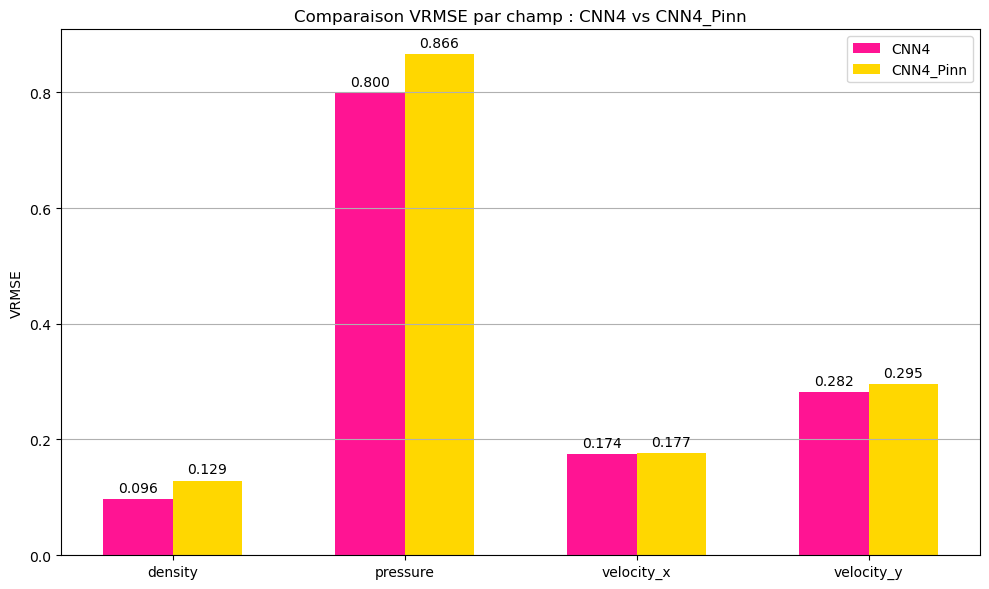

In [46]:
print("\n-------------------- Résultats VRMSE Moyen par Champ --------------------")
print(f"{'Champ':<15} {'CNN4':>10} {'CNN4_Pinn':>10}")
print("-" * 45)

for i, field in enumerate(field_names):
    print(f"{field:<15} "
          f"{vrmse_cnn4[i]:>10.4f} "
          f"{vrmse_cnn4_pinn[i]:>10.4f}")

print("\n") 

# Barplot
x = np.arange(len(field_names))
width = 0.3  

colors = ['deeppink', 'gold']

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, vrmse_cnn4, width, label='CNN4', color=colors[0])
rects2 = ax.bar(x + width/2, vrmse_cnn4_pinn, width, label='CNN4_Pinn', color=colors[1])

ax.set_ylabel('VRMSE')
ax.set_title('Comparaison VRMSE par champ : CNN4 vs CNN4_Pinn')
ax.set_xticks(x)
ax.set_xticklabels(field_names)
ax.legend()
ax.grid(True, axis='y')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

L'ajout de la loss PINN au modèle CNN4 vise à renforcer la cohérence physique des prédictions, en imposant la conservation de la masse.
Cependant, les résultats sur le set de validation montrent que l'amélioration de la physique ne se traduit pas nécessairement par une réduction du VRMSE pour tous les champs.

Notamment, nous observons que :
- Le VRMSE augmente légèrement pour tous les champs après l'ajout de la contrainte PINN.
- Cela suggère que l'intégration physique peut introduire un compromis entre fitting des données (MSE) et respect des lois physiques (PINN).

Il serait intéressant d'explorer différentes valeurs de $\beta$ ou d'autres formes de contraintes physiques pour mieux équilibrer ces deux aspects.



## Evaluation de la conservation de la masse

Pour aller au-delà du VRMSE et évaluer directement le respect de la loi de conservation de la masse, nous analysons la divergence de masse des champs prédits. La divergence est calculée comme suit :
$$
\text{div}(\rho \vec{v}) = \frac{\partial (\rho v_x)}{\partial x} + \frac{\partial (\rho v_y)}{\partial y}
$$
avec la densité prédite $\rho$ et les vitesses prédites $v_x$ et $v_y$.

Pour chaque échantillon du jeu de validation, on calcule la divergence de masse pour les prédictions du modèle CNN4 et du modèle CNN4_Pinn.
Puis, on évalue la moyenne de la valeur absolue de la divergence sur toute l'image. Enfin, on calcule la moyenne globale de ces divergences pour chaque modèle.

In [44]:
# Fonction de divergence de masse
def compute_mass_divergence(pred_rho, pred_vx, pred_vy, dx=1.0, dy=1.0):
    flux_x = pred_rho * pred_vx
    flux_y = pred_rho * pred_vy

    grad_flux_x = torch.gradient(flux_x, spacing=(dx,), dim=1)[0]
    grad_flux_y = torch.gradient(flux_y, spacing=(dy,), dim=0)[0]

    divergence = grad_flux_x + grad_flux_y
    return divergence

div_mass_cnn4 = []
div_mass_cnn4_pinn = []

model_cnn4.eval()
model_cnn4_pinn.eval()

with torch.no_grad():
    for item in tqdm(val_loader, desc="Validation divergence de masse CNN4 vs CNN4_Pinn"):
        x = item["input_fields"].squeeze(0)   # (4, H, W, 4)

        x = preprocess(x)
        x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

        # Prédiction CNN4
        pred_cnn4 = model_cnn4(x_in).squeeze(0).permute(1, 2, 0)
        pred_cnn4 = postprocess(pred_cnn4)

        rho_cnn4 = pred_cnn4[:, :, 0]
        vx_cnn4  = pred_cnn4[:, :, 2]
        vy_cnn4  = pred_cnn4[:, :, 3]

        div_cnn4 = compute_mass_divergence(rho_cnn4, vx_cnn4, vy_cnn4)
        div_mass_cnn4.append(torch.mean(div_cnn4.abs()).item())  # moyenne absolue

        # Prédiction CNN4_Pinn
        pred_cnn4_pinn = model_cnn4_pinn(x_in).squeeze(0).permute(1, 2, 0)
        pred_cnn4_pinn = postprocess(pred_cnn4_pinn)

        rho_cnn4_pinn = pred_cnn4_pinn[:, :, 0]
        vx_cnn4_pinn  = pred_cnn4_pinn[:, :, 2]
        vy_cnn4_pinn  = pred_cnn4_pinn[:, :, 3]

        div_cnn4_pinn = compute_mass_divergence(rho_cnn4_pinn, vx_cnn4_pinn, vy_cnn4_pinn)
        div_mass_cnn4_pinn.append(torch.mean(div_cnn4_pinn.abs()).item())

div_cnn4_mean = np.mean(div_mass_cnn4)
div_cnn4_pinn_mean = np.mean(div_mass_cnn4_pinn)

Validation divergence de masse CNN4 vs CNN4_Pinn: 100%|██████████████████████████████| 873/873 [00:32<00:00, 27.08it/s]


In [59]:
print("\n------- Résultats divergence de masse -------")
print(f"{'Modèle':<15} {'Divergence moyenne':>23}")
print("-" * 45)
print(f"{'CNN4':<15} {div_cnn4_mean:>20.6e}")
print(f"{'CNN4_Pinn':<15} {div_cnn4_pinn_mean:>20.6e}")
print("\n")


------- Résultats divergence de masse -------
Modèle               Divergence moyenne
---------------------------------------------
CNN4                    5.000222e-02
CNN4_Pinn               4.952989e-02




Le modèle CNN4+PINN présente une légère réduction de la divergence de masse moyenne par rapport à CNN4.
Cela confirme que l'ajout de la loss PINN a bien aidé à renforcer la conservation de la masse dans les prédictions, même si l'impact reste modeste.

## Étude de l'impact du poids $\beta$ sur l'entraînement avec loss PINN

Après avoir évalué le modèle CNN4 avec $\beta=0.1$, nous testons désormais différentes valeurs du coefficient $\beta$ pour la loss PINN :
- $\beta=0.1$
- $\beta=0.5$
- $\beta=1$

In [60]:
model_cnn4_pinn = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

optimizer_cnn4_pinn = torch.optim.Adam(model_cnn4_pinn.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_pinn = StepLR(optimizer_cnn4_pinn, step_size=5, gamma=0.5)
criterion_cnn4_pinn = nn.MSELoss() 
losses_cnn4_pinn_total = []
losses_cnn4_pinn_mse = []
losses_cnn4_pinn_pinn = []

beta = 0.5  # Poids de la loss PINN

for epoch in range(20):
    model_cnn4_pinn.train()
    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_pinn = 0.0

    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"].to(device)
        y = batch["output_fields"].to(device)

        x = preprocess(x)  
        y = preprocess(y)

        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_cnn4_pinn.zero_grad()
        fx = model_cnn4_pinn(x)  # (B, 4, Lx, Ly)

        # Loss MSE
        loss_mse = criterion_cnn4_pinn(fx, y)

        # Loss PINN : conservation de la masse
        B, _, Lx, Ly = fx.shape
        F_phys = 4

        fx_reshaped = fx.view(B, 1, F_phys, Lx, Ly)  # (B, 1, F, Lx, Ly)
        pred_rho = fx_reshaped[:, 0, 0]  # density
        pred_vx  = fx_reshaped[:, 0, 2]  # velocity_x
        pred_vy  = fx_reshaped[:, 0, 3]  # velocity_y

        x_reshaped = x.view(B, 4, F_phys, Lx, Ly)  # (B, Ti=4, F, Lx, Ly)
        rho_t = x_reshaped[:, -1, 0]  # density au dernier input step (t=Ti-1)

        # Fonction de loss PINN (définie plus haut)
        loss_pinn = compute_mass_pinn_loss(rho_t, pred_rho, pred_vx, pred_vy)

        # Loss totale
        loss_total = loss_mse + beta * loss_pinn

        loss_total.backward()
        optimizer_cnn4_pinn.step()
        
        epoch_mse += loss_mse.item()
        epoch_pinn += loss_pinn.item()
        epoch_loss += loss_total.item()
        bar.set_postfix(loss=loss_total.item())
    
    avg_mse = epoch_mse / len(train_loader)
    avg_pinn = epoch_pinn / len(train_loader)
    avg_loss = epoch_loss / len(train_loader)

    losses_cnn4_pinn_total.append(avg_loss)
    losses_cnn4_pinn_mse.append(avg_mse)
    losses_cnn4_pinn_pinn.append(avg_pinn)

    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"  Avg MSE: {avg_mse:.6f} | Avg PINN: {avg_pinn:.6f} | β={beta:.3f}")
    print(f"  Current LR: {scheduler_pinn.get_last_lr()[0]:.6f}")

    scheduler_pinn.step()

Epoch 1: 100%|██████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.19]


Epoch 1 average loss: 0.236741
  Avg MSE: 0.225418 | Avg PINN: 0.022646 | β=0.500
  Current LR: 0.001000


Epoch 2: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.0519]


Epoch 2 average loss: 0.180734
  Avg MSE: 0.173700 | Avg PINN: 0.014069 | β=0.500
  Current LR: 0.001000


Epoch 3: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.059]


Epoch 3 average loss: 0.161268
  Avg MSE: 0.154913 | Avg PINN: 0.012709 | β=0.500
  Current LR: 0.001000


Epoch 4: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.0888]


Epoch 4 average loss: 0.149879
  Avg MSE: 0.143729 | Avg PINN: 0.012299 | β=0.500
  Current LR: 0.001000


Epoch 5: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:23<00:00,  6.63it/s, loss=0.106]


Epoch 5 average loss: 0.141135
  Avg MSE: 0.135209 | Avg PINN: 0.011853 | β=0.500
  Current LR: 0.001000


Epoch 6: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:23<00:00,  6.62it/s, loss=0.0834]


Epoch 6 average loss: 0.124475
  Avg MSE: 0.119035 | Avg PINN: 0.010882 | β=0.500
  Current LR: 0.000500


Epoch 7: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:23<00:00,  6.62it/s, loss=0.292]


Epoch 7 average loss: 0.121862
  Avg MSE: 0.116493 | Avg PINN: 0.010739 | β=0.500
  Current LR: 0.000500


Epoch 8: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:23<00:00,  6.62it/s, loss=0.0212]


Epoch 8 average loss: 0.119581
  Avg MSE: 0.114293 | Avg PINN: 0.010577 | β=0.500
  Current LR: 0.000500


Epoch 9: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:23<00:00,  6.61it/s, loss=0.0606]


Epoch 9 average loss: 0.117122
  Avg MSE: 0.111894 | Avg PINN: 0.010455 | β=0.500
  Current LR: 0.000500


Epoch 10: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:23<00:00,  6.62it/s, loss=0.0928]


Epoch 10 average loss: 0.114924
  Avg MSE: 0.109763 | Avg PINN: 0.010324 | β=0.500
  Current LR: 0.000500


Epoch 11: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.61it/s, loss=0.0884]


Epoch 11 average loss: 0.106906
  Avg MSE: 0.101931 | Avg PINN: 0.009949 | β=0.500
  Current LR: 0.000250


Epoch 12: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:23<00:00,  6.62it/s, loss=0.114]


Epoch 12 average loss: 0.105677
  Avg MSE: 0.100722 | Avg PINN: 0.009912 | β=0.500
  Current LR: 0.000250


Epoch 13: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.61it/s, loss=0.0307]


Epoch 13 average loss: 0.104356
  Avg MSE: 0.099455 | Avg PINN: 0.009801 | β=0.500
  Current LR: 0.000250


Epoch 14: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.61it/s, loss=0.128]


Epoch 14 average loss: 0.103722
  Avg MSE: 0.098849 | Avg PINN: 0.009747 | β=0.500
  Current LR: 0.000250


Epoch 15: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.61it/s, loss=0.115]


Epoch 15 average loss: 0.102804
  Avg MSE: 0.097945 | Avg PINN: 0.009717 | β=0.500
  Current LR: 0.000250


Epoch 16: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.61it/s, loss=0.191]


Epoch 16 average loss: 0.098060
  Avg MSE: 0.093279 | Avg PINN: 0.009562 | β=0.500
  Current LR: 0.000125


Epoch 17: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.61it/s, loss=0.134]


Epoch 17 average loss: 0.097206
  Avg MSE: 0.092449 | Avg PINN: 0.009514 | β=0.500
  Current LR: 0.000125


Epoch 18: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.0125]


Epoch 18 average loss: 0.096647
  Avg MSE: 0.091906 | Avg PINN: 0.009482 | β=0.500
  Current LR: 0.000125


Epoch 19: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.055]


Epoch 19 average loss: 0.095946
  Avg MSE: 0.091218 | Avg PINN: 0.009457 | β=0.500
  Current LR: 0.000125


Epoch 20: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.113]

Epoch 20 average loss: 0.095369
  Avg MSE: 0.090657 | Avg PINN: 0.009424 | β=0.500
  Current LR: 0.000125


In [62]:
model_cnn4_pinn = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

optimizer_cnn4_pinn = torch.optim.Adam(model_cnn4_pinn.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_pinn = StepLR(optimizer_cnn4_pinn, step_size=5, gamma=0.5)
criterion_cnn4_pinn = nn.MSELoss() 
losses_cnn4_pinn_total = []
losses_cnn4_pinn_mse = []
losses_cnn4_pinn_pinn = []

beta = 1  # Poids de la loss PINN

for epoch in range(20):
    model_cnn4_pinn.train()
    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_pinn = 0.0

    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"].to(device)
        y = batch["output_fields"].to(device)

        x = preprocess(x)  
        y = preprocess(y)

        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_cnn4_pinn.zero_grad()
        fx = model_cnn4_pinn(x)  # (B, 4, Lx, Ly)

        # Loss MSE
        loss_mse = criterion_cnn4_pinn(fx, y)

        # Loss PINN : conservation de la masse
        B, _, Lx, Ly = fx.shape
        F_phys = 4

        fx_reshaped = fx.view(B, 1, F_phys, Lx, Ly)  # (B, 1, F, Lx, Ly)
        pred_rho = fx_reshaped[:, 0, 0]  # density
        pred_vx  = fx_reshaped[:, 0, 2]  # velocity_x
        pred_vy  = fx_reshaped[:, 0, 3]  # velocity_y

        x_reshaped = x.view(B, 4, F_phys, Lx, Ly)  # (B, Ti=4, F, Lx, Ly)
        rho_t = x_reshaped[:, -1, 0]  # density au dernier input step (t=Ti-1)

        # Fonction de loss PINN (définie plus haut)
        loss_pinn = compute_mass_pinn_loss(rho_t, pred_rho, pred_vx, pred_vy)

        # Loss totale
        loss_total = loss_mse + beta * loss_pinn

        loss_total.backward()
        optimizer_cnn4_pinn.step()
        
        epoch_mse += loss_mse.item()
        epoch_pinn += loss_pinn.item()
        epoch_loss += loss_total.item()
        bar.set_postfix(loss=loss_total.item())
    
    avg_mse = epoch_mse / len(train_loader)
    avg_pinn = epoch_pinn / len(train_loader)
    avg_loss = epoch_loss / len(train_loader)

    losses_cnn4_pinn_total.append(avg_loss)
    losses_cnn4_pinn_mse.append(avg_mse)
    losses_cnn4_pinn_pinn.append(avg_pinn)

    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"  Avg MSE: {avg_mse:.6f} | Avg PINN: {avg_pinn:.6f} | β={beta:.3f}")
    print(f"  Current LR: {scheduler_pinn.get_last_lr()[0]:.6f}")

    scheduler_pinn.step()

Epoch 1: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.59it/s, loss=0.139]


Epoch 1 average loss: 0.240474
  Avg MSE: 0.223874 | Avg PINN: 0.016599 | β=1.000
  Current LR: 0.001000


Epoch 2: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.142]


Epoch 2 average loss: 0.188999
  Avg MSE: 0.180472 | Avg PINN: 0.008526 | β=1.000
  Current LR: 0.001000


Epoch 3: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.598]


Epoch 3 average loss: 0.166626
  Avg MSE: 0.159463 | Avg PINN: 0.007163 | β=1.000
  Current LR: 0.001000


Epoch 4: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.59it/s, loss=0.0375]


Epoch 4 average loss: 0.152714
  Avg MSE: 0.146176 | Avg PINN: 0.006538 | β=1.000
  Current LR: 0.001000


Epoch 5: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:23<00:00,  6.62it/s, loss=0.192]


Epoch 5 average loss: 0.146497
  Avg MSE: 0.140276 | Avg PINN: 0.006221 | β=1.000
  Current LR: 0.001000


Epoch 6: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:23<00:00,  6.62it/s, loss=0.0249]


Epoch 6 average loss: 0.126763
  Avg MSE: 0.121733 | Avg PINN: 0.005030 | β=1.000
  Current LR: 0.000500


Epoch 7: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.0387]


Epoch 7 average loss: 0.124042
  Avg MSE: 0.119074 | Avg PINN: 0.004968 | β=1.000
  Current LR: 0.000500


Epoch 8: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.254]


Epoch 8 average loss: 0.121371
  Avg MSE: 0.116483 | Avg PINN: 0.004888 | β=1.000
  Current LR: 0.000500


Epoch 9: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.129]


Epoch 9 average loss: 0.118827
  Avg MSE: 0.114052 | Avg PINN: 0.004776 | β=1.000
  Current LR: 0.000500


Epoch 10: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.59it/s, loss=0.43]


Epoch 10 average loss: 0.117165
  Avg MSE: 0.112430 | Avg PINN: 0.004735 | β=1.000
  Current LR: 0.000500


Epoch 11: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.55it/s, loss=0.137]


Epoch 11 average loss: 0.107564
  Avg MSE: 0.103223 | Avg PINN: 0.004341 | β=1.000
  Current LR: 0.000250


Epoch 12: 100%|██████████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.56it/s, loss=0.3]


Epoch 12 average loss: 0.106007
  Avg MSE: 0.101705 | Avg PINN: 0.004301 | β=1.000
  Current LR: 0.000250


Epoch 13: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.182]


Epoch 13 average loss: 0.105611
  Avg MSE: 0.101324 | Avg PINN: 0.004287 | β=1.000
  Current LR: 0.000250


Epoch 14: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.57it/s, loss=0.377]


Epoch 14 average loss: 0.104067
  Avg MSE: 0.099823 | Avg PINN: 0.004244 | β=1.000
  Current LR: 0.000250


Epoch 15: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:24<00:00,  6.60it/s, loss=0.0229]


Epoch 15 average loss: 0.103000
  Avg MSE: 0.098792 | Avg PINN: 0.004208 | β=1.000
  Current LR: 0.000250


Epoch 16: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.58it/s, loss=0.0374]


Epoch 16 average loss: 0.098196
  Avg MSE: 0.094113 | Avg PINN: 0.004083 | β=1.000
  Current LR: 0.000125


Epoch 17: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.53it/s, loss=0.0235]


Epoch 17 average loss: 0.097007
  Avg MSE: 0.092937 | Avg PINN: 0.004070 | β=1.000
  Current LR: 0.000125


Epoch 18: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.56it/s, loss=0.0186]


Epoch 18 average loss: 0.096347
  Avg MSE: 0.092299 | Avg PINN: 0.004048 | β=1.000
  Current LR: 0.000125


Epoch 19: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.55it/s, loss=0.183]


Epoch 19 average loss: 0.095621
  Avg MSE: 0.091590 | Avg PINN: 0.004031 | β=1.000
  Current LR: 0.000125


Epoch 20: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.56it/s, loss=0.053]

Epoch 20 average loss: 0.095621
  Avg MSE: 0.091601 | Avg PINN: 0.004020 | β=1.000
  Current LR: 0.000125


In [66]:
val_loader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=False)

# Modèles
model_cnn4 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

model_cnn4_pinn_01 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

model_cnn4_pinn_05 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

model_cnn4_pinn_1 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

model_cnn4.load_state_dict(torch.load("model_cnn4.pth", weights_only=True))
model_cnn4_pinn_01.load_state_dict(torch.load("model_cnn4_pinn01.pth", weights_only=True))
model_cnn4_pinn_05.load_state_dict(torch.load("model_cnn4_pinn05.pth", weights_only=True))
model_cnn4_pinn_1.load_state_dict(torch.load("model_cnn4_pinn1.pth", weights_only=True))

# Fonction VRMSE 
def compute_vrmse(pred, gt):
    std_gt = torch.std(gt) + 1e-8
    mse = torch.mean((pred - gt) ** 2)
    vrmse = torch.sqrt(mse) / std_gt
    return vrmse

vrmse_cnn4 = []
vrmse_pinn_01 = []
vrmse_pinn_05 = []
vrmse_pinn_1 = []

model_cnn4.eval()
model_cnn4_pinn_01.eval()
model_cnn4_pinn_05.eval()
model_cnn4_pinn_1.eval()

with torch.no_grad():
    for item in tqdm(val_loader, desc="Validation VRMSE CNN4 et PINN"):
        x = item["input_fields"].squeeze(0)
        y = item["output_fields"].squeeze(0)[0]
        y = y.to(device)

        x = preprocess(x)
        x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

        # Prédictions
        pred_cnn4 = postprocess(model_cnn4(x_in).squeeze(0).permute(1,2,0))
        pred_pinn_01 = postprocess(model_cnn4_pinn_01(x_in).squeeze(0).permute(1,2,0))
        pred_pinn_05 = postprocess(model_cnn4_pinn_05(x_in).squeeze(0).permute(1,2,0))
        pred_pinn_1  = postprocess(model_cnn4_pinn_1(x_in).squeeze(0).permute(1,2,0))

        # VRMSE champ par champ
        for i in range(4):
            vrmse_cnn4.append(compute_vrmse(pred_cnn4[:, :, i], y[:, :, i]).item())
            vrmse_pinn_01.append(compute_vrmse(pred_pinn_01[:, :, i], y[:, :, i]).item())
            vrmse_pinn_05.append(compute_vrmse(pred_pinn_05[:, :, i], y[:, :, i]).item())
            vrmse_pinn_1.append(compute_vrmse(pred_pinn_1[:, :, i], y[:, :, i]).item())

# Moyenne par champ
vrmse_cnn4 = np.array(vrmse_cnn4).reshape(-1, 4).mean(axis=0)
vrmse_pinn_01 = np.array(vrmse_pinn_01).reshape(-1, 4).mean(axis=0)
vrmse_pinn_05 = np.array(vrmse_pinn_05).reshape(-1, 4).mean(axis=0)
vrmse_pinn_1  = np.array(vrmse_pinn_1).reshape(-1, 4).mean(axis=0)

Validation VRMSE CNN4 et PINN: 100%|█████████████████████████████████████████████████| 873/873 [00:58<00:00, 14.97it/s]



-------------- Résultats VRMSE moyen par champ --------------
Champ                 CNN4   PINN_0.1   PINN_0.5   PINN_1.0
-------------------------------------------------------------
density             0.0962     0.1290     0.2089     0.2333
pressure            0.7996     0.8659     0.8480     0.7783
velocity_x          0.1740     0.1771     0.1803     0.1782
velocity_y          0.2822     0.2954     0.3056     0.3133




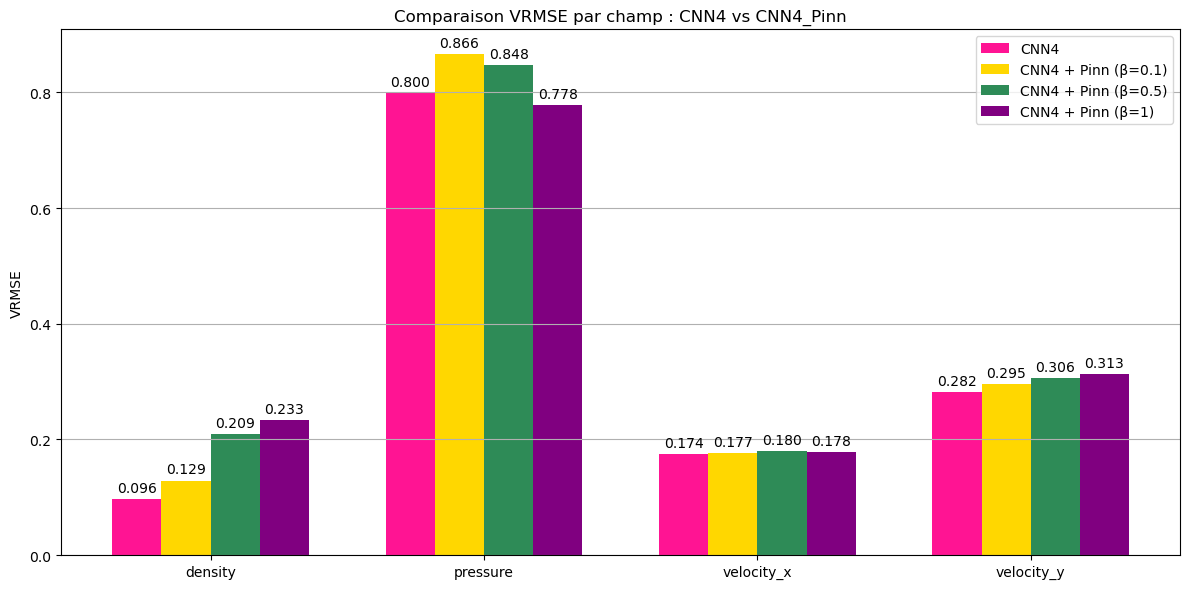

In [80]:
print("\n-------------- Résultats VRMSE moyen par champ --------------")
print(f"{'Champ':<15} {'CNN4':>10} {'PINN_0.1':>10} {'PINN_0.5':>10} {'PINN_1.0':>10}")
print("-" * 61)

for i, field in enumerate(field_names):
    print(f"{field:<15} "
          f"{vrmse_cnn4[i]:>10.4f} "
          f"{vrmse_pinn_01[i]:>10.4f} "
          f"{vrmse_pinn_05[i]:>10.4f} "
          f"{vrmse_pinn_1[i]:>10.4f}")

print("\n")

# Barplot
x = np.arange(len(field_names))
width = 0.18  

colors = ['deeppink', 'gold', 'seagreen', 'purple']

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - 1.5*width, vrmse_cnn4, width, label='CNN4', color=colors[0])
rects2 = ax.bar(x - 0.5*width, vrmse_pinn_01, width, label='CNN4 + Pinn (β=0.1)', color=colors[1])
rects3 = ax.bar(x + 0.5*width, vrmse_pinn_05, width, label='CNN4 + Pinn (β=0.5)', color=colors[2])
rects4 = ax.bar(x + 1.5*width, vrmse_pinn_1, width, label='CNN4 + Pinn (β=1)', color=colors[3])

ax.set_ylabel('VRMSE')
ax.set_title('Comparaison VRMSE par champ : CNN4 vs CNN4_Pinn')
ax.set_xticks(x)
ax.set_xticklabels(field_names)
ax.legend()
ax.grid(True, axis='y')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.tight_layout()
plt.show()


### Interprétation
Lorsque $\beta$ augmente, la VRMSE sur la densité augmente notablement, ce qui traduit un compromis plus fort entre conservation physique et précision MSE. 

La pression montre un comportement non monotone : une légère amélioration avec $\beta=1$.

Les vitesses sont peu affectées par la valeur de $\beta$. 

Un $\beta$ élevé comme $\beta=1$ détériore la précision globale, en particulier sur la densité.

## Évaluation de la divergence de masse pour différents $\beta$

In [81]:
# Fonction de divergence de masse
def compute_mass_divergence(pred_rho, pred_vx, pred_vy, dx=1.0, dy=1.0):
    flux_x = pred_rho * pred_vx
    flux_y = pred_rho * pred_vy

    grad_flux_x = torch.gradient(flux_x, spacing=(dx,), dim=1)[0]
    grad_flux_y = torch.gradient(flux_y, spacing=(dy,), dim=0)[0]

    divergence = grad_flux_x + grad_flux_y
    return divergence

# Stockage des divergences
div_mass_cnn4 = []
div_mass_pinn_01 = []
div_mass_pinn_05 = []
div_mass_pinn_1 = []

model_cnn4.eval()
model_cnn4_pinn_01.eval()
model_cnn4_pinn_05.eval()
model_cnn4_pinn_1.eval()

with torch.no_grad():
    for item in tqdm(val_loader, desc="Validation Divergence de Masse CNN4 et PINN"):
        x = item["input_fields"].squeeze(0)

        x = preprocess(x)
        x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

        # Prédictions
        pred_cnn4 = postprocess(model_cnn4(x_in).squeeze(0).permute(1,2,0))
        pred_pinn_01 = postprocess(model_cnn4_pinn_01(x_in).squeeze(0).permute(1,2,0))
        pred_pinn_05 = postprocess(model_cnn4_pinn_05(x_in).squeeze(0).permute(1,2,0))
        pred_pinn_1 = postprocess(model_cnn4_pinn_1(x_in).squeeze(0).permute(1,2,0))

        # CNN4
        rho, vx, vy = pred_cnn4[:, :, 0], pred_cnn4[:, :, 2], pred_cnn4[:, :, 3]
        div = compute_mass_divergence(rho, vx, vy)
        div_mass_cnn4.append(torch.mean(div.abs()).item())

        # CNN4_Pinn β=0.1
        rho, vx, vy = pred_pinn_01[:, :, 0], pred_pinn_01[:, :, 2], pred_pinn_01[:, :, 3]
        div = compute_mass_divergence(rho, vx, vy)
        div_mass_pinn_01.append(torch.mean(div.abs()).item())

        # CNN4_Pinn β=0.5
        rho, vx, vy = pred_pinn_05[:, :, 0], pred_pinn_05[:, :, 2], pred_pinn_05[:, :, 3]
        div = compute_mass_divergence(rho, vx, vy)
        div_mass_pinn_05.append(torch.mean(div.abs()).item())

        # CNN4_Pinn β=1.0
        rho, vx, vy = pred_pinn_1[:, :, 0], pred_pinn_1[:, :, 2], pred_pinn_1[:, :, 3]
        div = compute_mass_divergence(rho, vx, vy)
        div_mass_pinn_1.append(torch.mean(div.abs()).item())

div_cnn4_mean = np.mean(div_mass_cnn4)
div_pinn_01_mean = np.mean(div_mass_pinn_01)
div_pinn_05_mean = np.mean(div_mass_pinn_05)
div_pinn_1_mean = np.mean(div_mass_pinn_1)

Validation Divergence de Masse CNN4 et PINN: 100%|███████████████████████████████████| 873/873 [00:56<00:00, 15.35it/s]



-------------------- Résultats divergence de masse moyenne --------------------
Modèle            Divergence Moyenne
---------------------------------------------
CNN4                    5.000222e-02
PINN_0.1                4.952989e-02
PINN_0.5                5.016199e-02
PINN_1.0                5.498654e-02




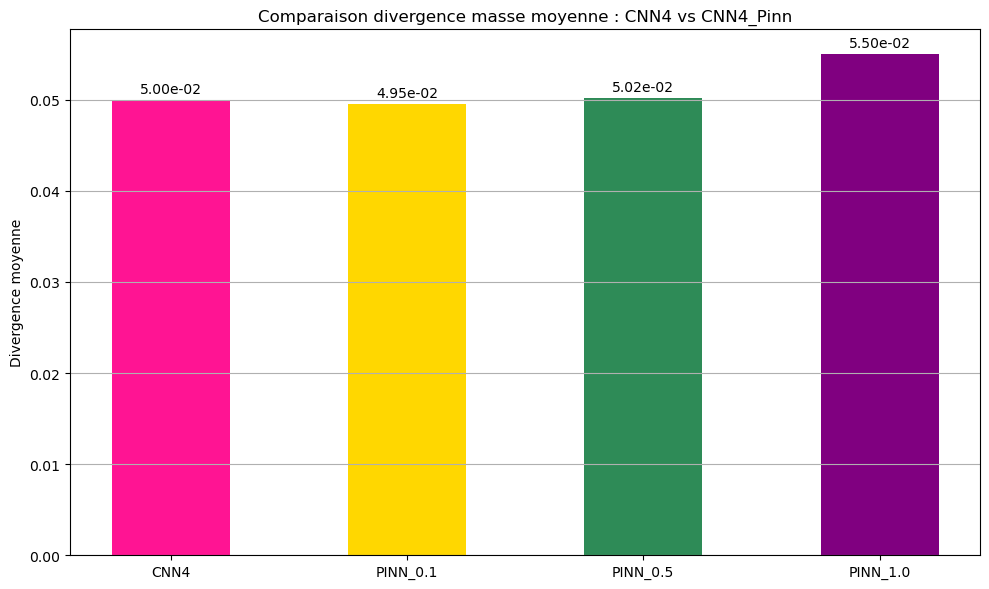

In [82]:
print("\n-------------------- Résultats divergence de masse moyenne --------------------")
print(f"{'Modèle':<15} {'Divergence Moyenne':>20}")
print("-" * 45)
print(f"{'CNN4':<15} {div_cnn4_mean:>20.6e}")
print(f"{'PINN_0.1':<15} {div_pinn_01_mean:>20.6e}")
print(f"{'PINN_0.5':<15} {div_pinn_05_mean:>20.6e}")
print(f"{'PINN_1.0':<15} {div_pinn_1_mean:>20.6e}")
print("\n")

# Barplot divergence de masse
labels = ['CNN4', 'PINN_0.1', 'PINN_0.5', 'PINN_1.0']
div_means = [div_cnn4_mean, div_pinn_01_mean, div_pinn_05_mean, div_pinn_1_mean]
colors = ['deeppink', 'gold', 'seagreen', 'purple']

fig, ax = plt.subplots(figsize=(10,6))
bars = ax.bar(labels, div_means, color=colors, width=0.5)

ax.set_ylabel('Divergence moyenne')
ax.set_title('Comparaison divergence masse moyenne : CNN4 vs CNN4_Pinn')
ax.grid(True, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2e}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()

plt.show()

Nous observons qu'une loss PINN modérée (β=0.1) permet de réduire légèrement la divergence de masse sans dégrader fortement la précision du modèle. En revanche, β=1.0 n'apporte pas d'amélioration supplémentaire de la conservation de masse, et conduit même à une divergence moyenne plus élevée.

## Training du modèle CNN4 avec deux contraintes physiques : conservation de la masse et de l'énergie

Après avoir imposé uniquement la conservation de la masse via une loss PINN, nous explorons maintenant une formulation enrichie intégrant :
- La conservation de la masse.
- La conservation de l'énergie totale avec perte par refroidissement : $$ 
\frac{\partial E}{\partial t} + \nabla \cdot \left( (E + P) \vec{v} \right) = - \frac{E}{t_{\text{cool}}}$$
où E est l'énergie interne calculée par $E=\frac{P}{\gamma-1}$ et $t_{cool}$ est le temps caractéristique de refroidissement.

La loss associée est calculée par :

In [26]:
def compute_energy_pinn_loss(rho_t, pred_rho, pred_pressure, pred_vx, pred_vy, t_cool=1.0):

    gamma = 5/3

    # Energie totale E prédite
    pred_E = pred_pressure / (gamma - 1)  # simplifié vu la relation E = P / (γ-1)

    # Flux d'énergie : (E+P)*v
    flux_energy_x = (pred_E + pred_pressure) * pred_vx
    flux_energy_y = (pred_E + pred_pressure) * pred_vy

    # Div(flux d'énergie)
    grad_flux_energy_x = torch.gradient(flux_energy_x, spacing=(1.0,), dim=2)[0]  # dérivée sur x
    grad_flux_energy_y = torch.gradient(flux_energy_y, spacing=(1.0,), dim=1)[0]  # dérivée sur y

    divergence_flux_energy = grad_flux_energy_x + grad_flux_energy_y

    # Terme de perte d'énergie par refroidissement
    cooling_term = pred_E / t_cool

    # Résidu de l'équation
    residual = divergence_flux_energy + cooling_term

    # Loss : MSE sur le résidu
    loss_energy = torch.mean(residual**2)

    return loss_energy

### Training de ce modèle CNN4_PINN2
- Optimiseur : Adam (lr=0.001)
- Scheduler : réduction dur learning rate tous les 5 epochs avec un facteur 0.5
- Nombre d'epochs : 20
- Poids :
  - $\beta_{mass}=0.1$
  - $\beta_{energy}=0.01$

La loss totale est : $\text{Loss totale} = \text{MSE} + \beta_{mass}*\text{Loss}_{mass} +  \beta_{energy}*\text{Loss}_{energy}$

In [29]:
model_cnn4_pinn2 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)

optimizer_cnn4_pinn2 = torch.optim.Adam(model_cnn4_pinn2.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_pinn2 = StepLR(optimizer_cnn4_pinn2, step_size=5, gamma=0.5)
criterion_cnn4_pinn2 = nn.MSELoss()

losses_cnn4_pinn2_total = []
losses_cnn4_pinn2_mse = []
losses_cnn4_pinn2_mass = []
losses_cnn4_pinn2_energy = []

# Coefficients de pondération
beta_mass = 0.1
beta_energy = 0.01

for epoch in range(20):
    model_cnn4_pinn2.train()
    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_mass = 0.0
    epoch_energy = 0.0

    for batch in (bar := tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        x = batch["input_fields"].to(device)
        y = batch["output_fields"].to(device)

        x = preprocess(x)
        y = preprocess(y)

        x = rearrange(x, "B Ti Lx Ly F -> B (Ti F) Lx Ly")
        y = rearrange(y, "B To Lx Ly F -> B (To F) Lx Ly")

        optimizer_cnn4_pinn2.zero_grad()
        fx = model_cnn4_pinn2(x)  # (B, 4, Lx, Ly)

        # Loss MSE
        loss_mse = criterion_cnn4_pinn2(fx, y)

        # Récupérer les champs physiques
        B, _, Lx, Ly = fx.shape
        F_phys = 4

        fx_reshaped = fx.view(B, 1, F_phys, Lx, Ly)
        pred_rho = fx_reshaped[:, 0, 0]
        pred_pressure = fx_reshaped[:, 0, 1]
        pred_vx = fx_reshaped[:, 0, 2]
        pred_vy = fx_reshaped[:, 0, 3]

        x_reshaped = x.view(B, 4, F_phys, Lx, Ly)
        rho_t = x_reshaped[:, -1, 0]  # Dernier input density

        # Loss PINN Masse
        loss_mass = compute_mass_pinn_loss(rho_t, pred_rho, pred_vx, pred_vy)

        # Loss PINN Energie
        loss_energy = compute_energy_pinn_loss(rho_t, pred_rho, pred_pressure, pred_vx, pred_vy)

        # Loss totale
        loss_total = loss_mse + beta_mass * loss_mass + beta_energy * loss_energy

        loss_total.backward()
        optimizer_cnn4_pinn2.step()

        epoch_mse += loss_mse.item()
        epoch_mass += loss_mass.item()
        epoch_energy += loss_energy.item()
        epoch_loss += loss_total.item()
        bar.set_postfix(loss=loss_total.item())

    avg_mse = epoch_mse / len(train_loader)
    avg_mass = epoch_mass / len(train_loader)
    avg_energy = epoch_energy / len(train_loader)
    avg_loss = epoch_loss / len(train_loader)

    losses_cnn4_pinn2_total.append(avg_loss)
    losses_cnn4_pinn2_mse.append(avg_mse)
    losses_cnn4_pinn2_mass.append(avg_mass)
    losses_cnn4_pinn2_energy.append(avg_energy)

    print(f"Epoch {epoch+1} average loss: {avg_loss:.6f}")
    print(f"  Avg MSE: {avg_mse:.6f} | Avg Mass PINN: {avg_mass:.6f} | Avg Energy PINN: {avg_energy:.6f}")
    print(f"  Current LR: {scheduler_pinn2.get_last_lr()[0]:.6f}")

    scheduler_pinn2.step()

Epoch 1: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.53it/s, loss=0.101]


Epoch 1 average loss: 0.252838
  Avg MSE: 0.219926 | Avg Mass PINN: 0.049279 | Avg Energy PINN: 2.798435
  Current LR: 0.001000


Epoch 2: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.54it/s, loss=0.344]


Epoch 2 average loss: 0.208283
  Avg MSE: 0.174178 | Avg Mass PINN: 0.044632 | Avg Energy PINN: 2.964170
  Current LR: 0.001000


Epoch 3: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.53it/s, loss=0.103]


Epoch 3 average loss: 0.188667
  Avg MSE: 0.153968 | Avg Mass PINN: 0.041577 | Avg Energy PINN: 3.054065
  Current LR: 0.001000


Epoch 4: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.53it/s, loss=0.0662]


Epoch 4 average loss: 0.175496
  Avg MSE: 0.140214 | Avg Mass PINN: 0.041236 | Avg Energy PINN: 3.115797
  Current LR: 0.001000


Epoch 5: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.56it/s, loss=0.259]


Epoch 5 average loss: 0.166519
  Avg MSE: 0.130813 | Avg Mass PINN: 0.041428 | Avg Energy PINN: 3.156279
  Current LR: 0.001000


Epoch 6: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.56it/s, loss=0.0513]


Epoch 6 average loss: 0.151370
  Avg MSE: 0.114998 | Avg Mass PINN: 0.041334 | Avg Energy PINN: 3.223888
  Current LR: 0.000500


Epoch 7: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.56it/s, loss=0.159]


Epoch 7 average loss: 0.148460
  Avg MSE: 0.111926 | Avg Mass PINN: 0.041696 | Avg Energy PINN: 3.236422
  Current LR: 0.000500


Epoch 8: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.56it/s, loss=0.0572]


Epoch 8 average loss: 0.146212
  Avg MSE: 0.109520 | Avg Mass PINN: 0.041759 | Avg Energy PINN: 3.251630
  Current LR: 0.000500


Epoch 9: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.56it/s, loss=0.0948]


Epoch 9 average loss: 0.144486
  Avg MSE: 0.107773 | Avg Mass PINN: 0.041897 | Avg Energy PINN: 3.252329
  Current LR: 0.000500


Epoch 10: 100%|█████████████████████████████████████████████████████████| 1746/1746 [04:26<00:00,  6.56it/s, loss=0.29]


Epoch 10 average loss: 0.142684
  Avg MSE: 0.105862 | Avg Mass PINN: 0.041898 | Avg Energy PINN: 3.263202
  Current LR: 0.000500


Epoch 11: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:29<00:00,  6.49it/s, loss=0.0442]


Epoch 11 average loss: 0.135058
  Avg MSE: 0.097894 | Avg Mass PINN: 0.041817 | Avg Energy PINN: 3.298296
  Current LR: 0.000250


Epoch 12: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:28<00:00,  6.50it/s, loss=0.0867]


Epoch 12 average loss: 0.133463
  Avg MSE: 0.096233 | Avg Mass PINN: 0.041894 | Avg Energy PINN: 3.304059
  Current LR: 0.000250


Epoch 13: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:25<00:00,  6.57it/s, loss=0.106]


Epoch 13 average loss: 0.132542
  Avg MSE: 0.095281 | Avg Mass PINN: 0.041883 | Avg Energy PINN: 3.307295
  Current LR: 0.000250


Epoch 14: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:28<00:00,  6.50it/s, loss=0.537]


Epoch 14 average loss: 0.131444
  Avg MSE: 0.094118 | Avg Mass PINN: 0.041981 | Avg Energy PINN: 3.312876
  Current LR: 0.000250


Epoch 15: 100%|████████████████████████████████████████████████████████| 1746/1746 [04:28<00:00,  6.51it/s, loss=0.158]


Epoch 15 average loss: 0.130469
  Avg MSE: 0.093088 | Avg Mass PINN: 0.041944 | Avg Energy PINN: 3.318633
  Current LR: 0.000250


Epoch 16: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:28<00:00,  6.51it/s, loss=0.0602]


Epoch 16 average loss: 0.126130
  Avg MSE: 0.088570 | Avg Mass PINN: 0.041897 | Avg Energy PINN: 3.337078
  Current LR: 0.000125


Epoch 17: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.52it/s, loss=0.0446]


Epoch 17 average loss: 0.125493
  Avg MSE: 0.087887 | Avg Mass PINN: 0.042094 | Avg Energy PINN: 3.339667
  Current LR: 0.000125


Epoch 18: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.53it/s, loss=0.0589]


Epoch 18 average loss: 0.125013
  Avg MSE: 0.087361 | Avg Mass PINN: 0.042059 | Avg Energy PINN: 3.344588
  Current LR: 0.000125


Epoch 19: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.53it/s, loss=0.0408]


Epoch 19 average loss: 0.124237
  Avg MSE: 0.086580 | Avg Mass PINN: 0.041995 | Avg Energy PINN: 3.345781
  Current LR: 0.000125


Epoch 20: 100%|███████████████████████████████████████████████████████| 1746/1746 [04:27<00:00,  6.52it/s, loss=0.0512]

Epoch 20 average loss: 0.123757
  Avg MSE: 0.086058 | Avg Mass PINN: 0.042045 | Avg Energy PINN: 3.349445
  Current LR: 0.000125


### Évaluation : VRMSE par champ
Nous comparons : 
- CNN4 (sans PINN)
- CNN4_Pinn(mass) (avec conservation de masse uniquement, $\beta=0.1$)
- CNN4_Pinn2(mass + energy) (avec conservation de masse et d'énergie)

Sur le set de validation, nous calculons le VRMSE moyen pour chaque champ physique.

In [36]:
val_loader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=False)

model_cnn4 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)
model_cnn4.load_state_dict(torch.load("model_cnn4.pth", weights_only=True))

model_cnn4_pinn_01 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)
model_cnn4_pinn_01.load_state_dict(torch.load("model_cnn4_pinn01.pth", weights_only=True))

model_cnn4_pinn2 = CNN4(
    in_channels=4 * F,
    out_channels=1 * F
).to(device)
model_cnn4_pinn2.load_state_dict(torch.load("model_cnn4_pinn2.pth", weights_only=True))

def compute_vrmse(pred, gt):
    std_gt = torch.std(gt) + 1e-8
    mse = torch.mean((pred - gt) ** 2)
    vrmse = torch.sqrt(mse) / std_gt
    return vrmse

vrmse_cnn4 = []
vrmse_cnn4_pinn = []
vrmse_cnn4_pinn2 = []

model_cnn4.eval()
model_cnn4_pinn_01.eval()
model_cnn4_pinn2.eval()

with torch.no_grad():
    for item in tqdm(val_loader, desc="Validation VRMSE CNN4 vs CNN4_Pinn vs CNN4_Pinn2"):
        x = item["input_fields"].squeeze(0)   # (4, H, W, 4)
        y = item["output_fields"].squeeze(0)[0]  # (H, W, 4)
        y = y.to(device)
        
        x = preprocess(x)
        x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

        # Prédictions
        pred_cnn4 = model_cnn4(x_in).squeeze(0).permute(1, 2, 0)  # (H, W, 4)
        pred_cnn4 = postprocess(pred_cnn4)

        pred_cnn4_pinn = model_cnn4_pinn_01(x_in).squeeze(0).permute(1, 2, 0)  # (H, W, 4)
        pred_cnn4_pinn = postprocess(pred_cnn4_pinn)

        pred_cnn4_pinn2 = model_cnn4_pinn2(x_in).squeeze(0).permute(1, 2, 0)  # (H, W, 4)
        pred_cnn4_pinn2 = postprocess(pred_cnn4_pinn2)

        # VRMSE pour chaque champ
        for i in range(4):  # (density, pressure, vx, vy)
            vrmse_cnn4.append(compute_vrmse(pred_cnn4[:, :, i], y[:, :, i]).item())
            vrmse_cnn4_pinn.append(compute_vrmse(pred_cnn4_pinn[:, :, i], y[:, :, i]).item())
            vrmse_cnn4_pinn2.append(compute_vrmse(pred_cnn4_pinn2[:, :, i], y[:, :, i]).item())

# Moyenne finale par champ
vrmse_cnn4 = np.array(vrmse_cnn4).reshape(-1, 4).mean(axis=0)
vrmse_cnn4_pinn = np.array(vrmse_cnn4_pinn).reshape(-1, 4).mean(axis=0)
vrmse_cnn4_pinn2 = np.array(vrmse_cnn4_pinn2).reshape(-1, 4).mean(axis=0)

Validation VRMSE CNN4 vs CNN4_Pinn vs CNN4_Pinn2: 100%|██████████████████████████████| 873/873 [00:46<00:00, 18.81it/s]



-------------------- Résultats VRMSE moyen par Champ --------------------
Champ                 CNN4 CNN4_Pinn(mass) CNN4_Pinn2(mass+energy)
--------------------------------------------------
density             0.0962     0.1290     0.1301
pressure            0.7996     0.8659     1.2753
velocity_x          0.1740     0.1771     0.1814
velocity_y          0.2822     0.2954     0.3198


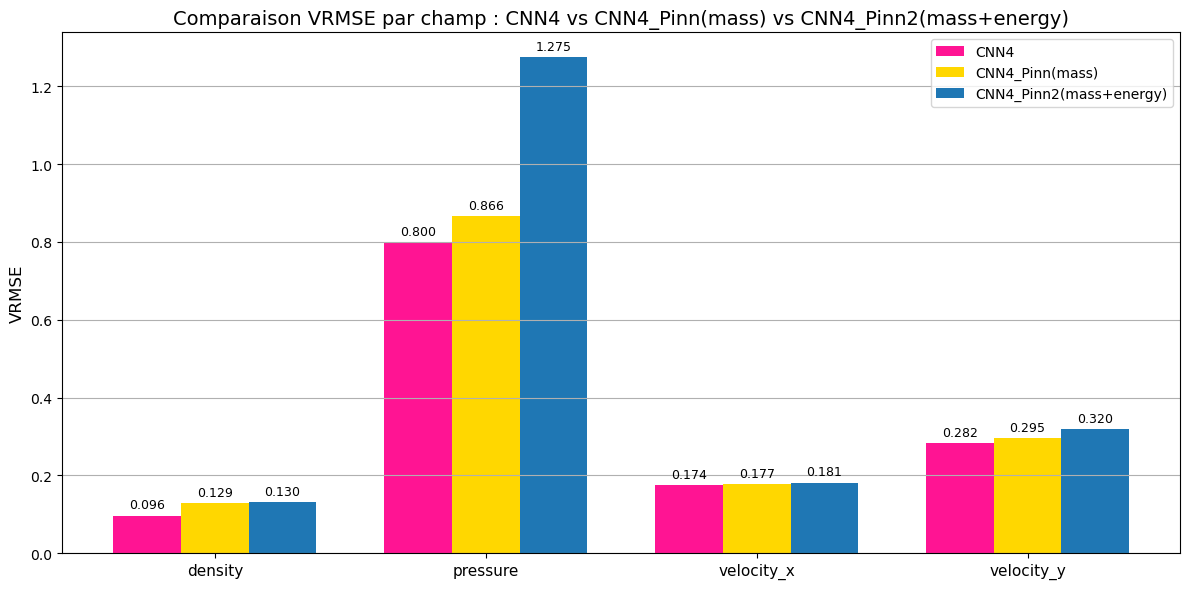

In [87]:
field_names = ['density', 'pressure', 'velocity_x', 'velocity_y']

print("\n-------------------- Résultats VRMSE moyen par Champ --------------------")
print(f"{'Champ':<15} {'CNN4':>10} {'CNN4_Pinn(mass)':>10} {'CNN4_Pinn2(mass+energy)':>10}")
print("-" * 50)

for i, field in enumerate(field_names):
    print(f"{field:<15} "
          f"{vrmse_cnn4[i]:>10.4f} "
          f"{vrmse_cnn4_pinn[i]:>10.4f} "
          f"{vrmse_cnn4_pinn2[i]:>10.4f}")

# Barplot VRMSE CNN4 vs CNN4_Pinn vs CNN4_Pinn2
x = np.arange(len(field_names))
width = 0.25 

colors = ['deeppink', 'gold']

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - width, vrmse_cnn4, width, label='CNN4', color=colors[0])
rects2 = ax.bar(x, vrmse_cnn4_pinn, width, label='CNN4_Pinn(mass)', color=colors[1])
rects3 = ax.bar(x + width, vrmse_cnn4_pinn2, width, label='CNN4_Pinn2(mass+energy)')

ax.set_ylabel('VRMSE', fontsize=12)
ax.set_title('Comparaison VRMSE par champ : CNN4 vs CNN4_Pinn(mass) vs CNN4_Pinn2(mass+energy)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(field_names, fontsize=11)
ax.legend()
ax.grid(True, axis='y')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
plt.tight_layout()
plt.savefig("vrmse_cnn4_pinn01_pinn2.png", dpi=300)
plt.show()

#### Interprétation

La conservation de la masse seule (CNN4_Pinn) dégrade légèrement la précision, surtout pour la densité et la pression.

L'ajout de la conservation de l'énergie (CNN4_Pinn2) détériore significativement la VRMSE sur la pression, indiquant que la contrainte énergétique est plus difficile à satisfaire avec la même architecture.

Les vitesses $v_x$ et $v_y$ sont peu affectées.

# Analyse physique avancée des prédictions

Dans cette section, nous analysons la capacité des modèles à restituer correctement des grandeurs physiques globales et locales du système :
- Pression moyenne
- Température moyenne
- Cold Mass Fraction (CMF)

Ces analyses permettent d’évaluer non seulement la précision numérique mais aussi la cohérence physique des modèles par rapport aux lois sous-jacentes du problème.

## Comparaison des profils de pression moyenne
Nous comparons les profils de pression moyenne le long de l'axe x pour :
- Un échantillon spécifique qui est l'item[123]
- Puis en moyennant sur l'ensemble du set de validation

Pour ce faire, on va faire un moyennage de la pression sur y, puis un lissage éventuel des courbes pour améliorer la lecture, et enfin une comparaison avec le ground truth.

In [76]:
item = validset[123]

x = item["input_fields"].to(device)
y_true = item["output_fields"].to(device)

x = preprocess(x)
x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

# Modèles
model_cnn4.eval()
model_cnn4_pinn_01.eval()
model_cnn4_pinn_05.eval()
model_cnn4_pinn_1.eval()
model_cnn4_pinn2.eval()
model_fno.eval()

with torch.no_grad():
    pred_cnn4 = model_cnn4(x_in).squeeze(0).permute(1, 2, 0)
    pred_cnn4_pinn01 = model_cnn4_pinn_01(x_in).squeeze(0).permute(1, 2, 0)
    pred_cnn4_pinn05 = model_cnn4_pinn_05(x_in).squeeze(0).permute(1, 2, 0)
    pred_cnn4_pinn1 = model_cnn4_pinn_1(x_in).squeeze(0).permute(1, 2, 0)
    pred_cnn4_pinn2 = model_cnn4_pinn2(x_in).squeeze(0).permute(1, 2, 0)

    pred_fno = model_fno(x_in).squeeze(0)
    pred_fno = rearrange(pred_fno, "(To F) H W -> To H W F", To=1, F=4)[0]

# Postprocess
pred_cnn4 = postprocess(pred_cnn4)
pred_cnn4_pinn01 = postprocess(pred_cnn4_pinn01)
pred_cnn4_pinn05 = postprocess(pred_cnn4_pinn05)
pred_cnn4_pinn1 = postprocess(pred_cnn4_pinn1)
pred_cnn4_pinn2 = postprocess(pred_cnn4_pinn2)  # <== NOUVEAU
pred_fno = postprocess(pred_fno)

# Ground truth
true_pressure = y_true[0, :, :, 1].cpu().numpy()

# Modèles (pression)
pressure_cnn4 = pred_cnn4[:, :, 1].cpu().numpy()
pressure_cnn4_pinn01 = pred_cnn4_pinn01[:, :, 1].cpu().numpy()
pressure_cnn4_pinn05 = pred_cnn4_pinn05[:, :, 1].cpu().numpy()
pressure_cnn4_pinn1 = pred_cnn4_pinn1[:, :, 1].cpu().numpy()
pressure_cnn4_pinn2 = pred_cnn4_pinn2[:, :, 1].cpu().numpy()
pressure_fno = pred_fno[:, :, 1].cpu().numpy()

# Moyenne verticale (sur Y)
pressure_true_mean = true_pressure.mean(axis=0)
pressure_cnn4_mean = pressure_cnn4.mean(axis=0)
pressure_cnn4_pinn01_mean = pressure_cnn4_pinn01.mean(axis=0)
pressure_cnn4_pinn05_mean = pressure_cnn4_pinn05.mean(axis=0)
pressure_cnn4_pinn1_mean = pressure_cnn4_pinn1.mean(axis=0)
pressure_cnn4_pinn2_mean = pressure_cnn4_pinn2.mean(axis=0)
pressure_fno_mean = pressure_fno.mean(axis=0)

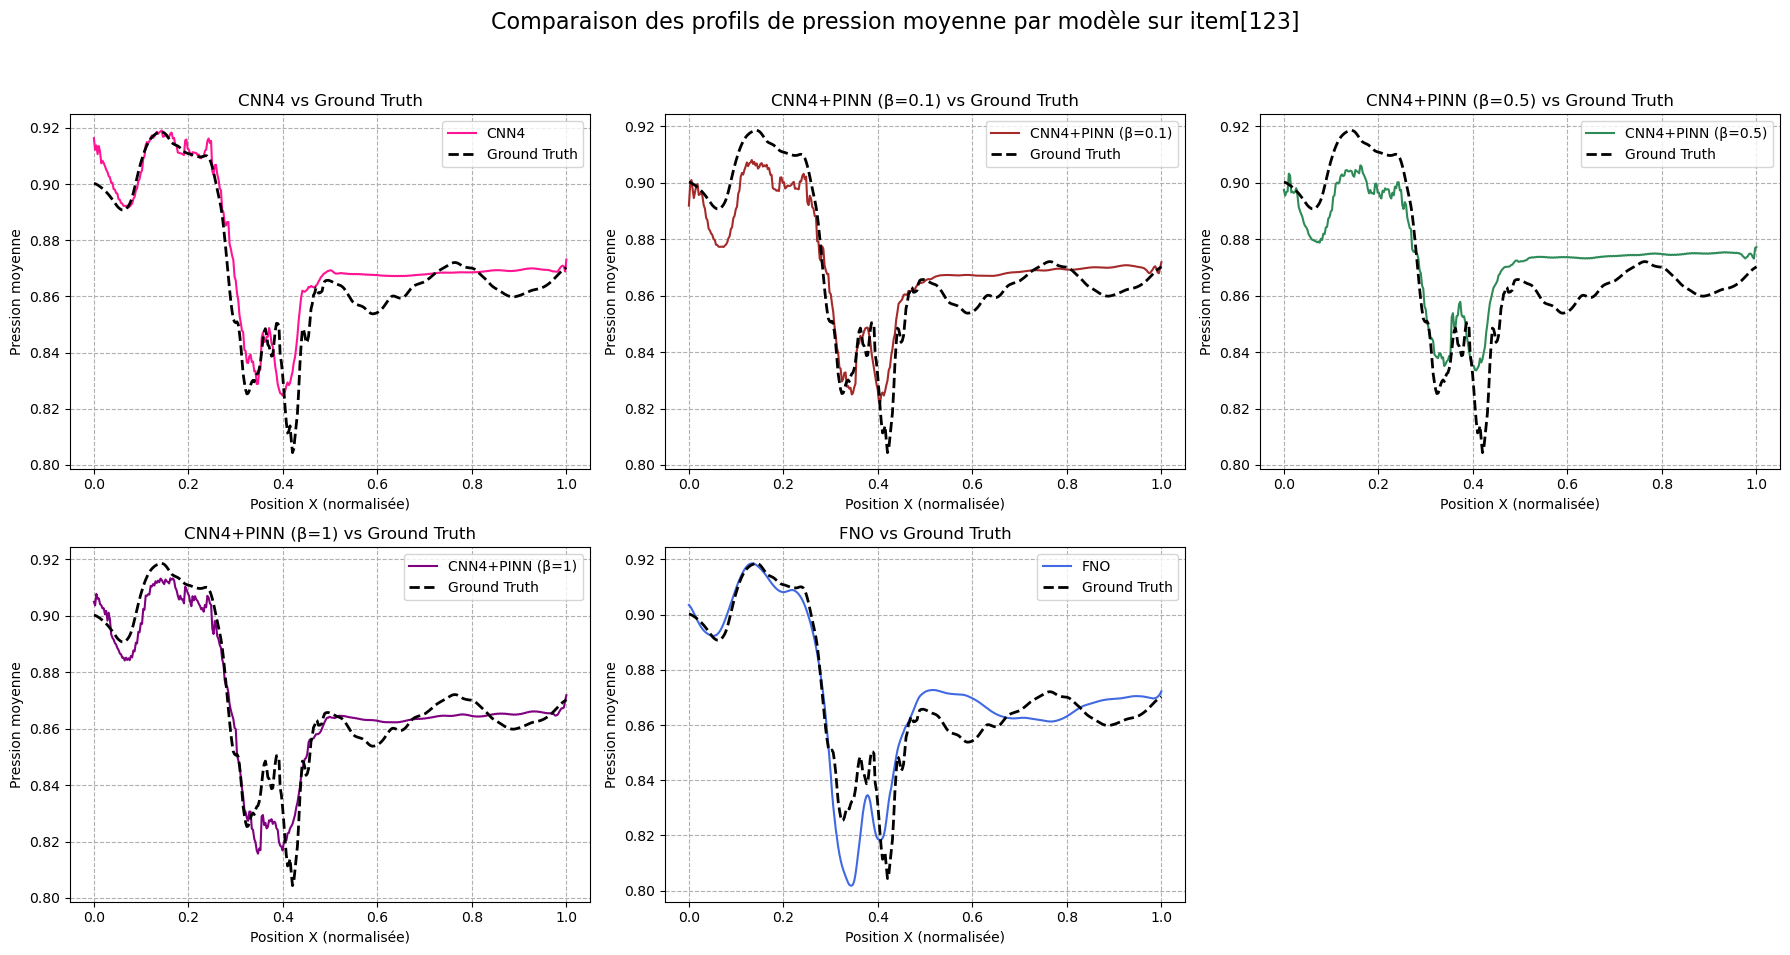

In [77]:
x_vals = np.linspace(0, 1, pressure_true_mean.shape[0])

models = {
    'CNN4': pressure_cnn4_mean,
    'CNN4+PINN (β=0.1)': pressure_cnn4_pinn01_mean,
    'CNN4+PINN (β=0.5)': pressure_cnn4_pinn05_mean,
    'CNN4+PINN (β=1)': pressure_cnn4_pinn1_mean,
    'FNO': pressure_fno_mean
}

colors = {
    'CNN4': 'deeppink',
    'CNN4+PINN (β=0.1)': 'brown',
    'CNN4+PINN (β=0.5)': 'seagreen',
    'CNN4+PINN (β=1)': 'purple',
    'FNO': 'royalblue'
}

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, (model_name, pressure_profile) in enumerate(models.items()):
    axs[i].plot(x_vals, pressure_profile, label=model_name, color=colors[model_name])
    axs[i].plot(x_vals, pressure_true_mean, label='Ground Truth', color='black', linestyle='--', linewidth=2)
    axs[i].set_xlabel("Position X (normalisée)")
    axs[i].set_ylabel("Pression moyenne")
    axs[i].set_title(f"{model_name} vs Ground Truth")
    axs[i].grid(True, which="both", ls="--")
    axs[i].legend()

fig.delaxes(axs[-1])
plt.suptitle("Comparaison des profils de pression moyenne par modèle sur item[123]", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [228]:
n_items = len(validset)  # nombre d'échantillons à moyenner
indices = np.arange(n_items)

pressure_cnn4_all = []
pressure_cnn4_pinn01_all = []
pressure_cnn4_pinn05_all = []
pressure_cnn4_pinn1_all = []
pressure_fno_all = []
pressure_true_all = []

for idx in tqdm(indices, desc="Traitement des items"):
    item = validset[idx]

    x = item["input_fields"].to(device)
    y_true = item["output_fields"].to(device)

    x = preprocess(x)
    x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

    with torch.no_grad():
        pred_cnn4 = model_cnn4(x_in).squeeze(0).permute(1,2,0)
        pred_cnn4_pinn01 = model_cnn4_pinn_01(x_in).squeeze(0).permute(1,2,0)
        pred_cnn4_pinn05 = model_cnn4_pinn_05(x_in).squeeze(0).permute(1,2,0)
        pred_cnn4_pinn1 = model_cnn4_pinn_1(x_in).squeeze(0).permute(1,2,0)
        pred_fno = model_fno(x_in).squeeze(0)
        pred_fno = rearrange(pred_fno, "(To F) H W -> To H W F", To=1, F=4)[0]

    pred_cnn4 = postprocess(pred_cnn4)
    pred_cnn4_pinn01 = postprocess(pred_cnn4_pinn01)
    pred_cnn4_pinn05 = postprocess(pred_cnn4_pinn05)
    pred_cnn4_pinn1 = postprocess(pred_cnn4_pinn1)
    pred_fno = postprocess(pred_fno)

    # Ground truth pression
    pressure_true = y_true[0, :, :, 1].cpu().numpy()

    # Moyenne verticale (Y axis)
    pressure_cnn4_all.append(pred_cnn4[:, :, 1].cpu().numpy().mean(axis=0))
    pressure_cnn4_pinn01_all.append(pred_cnn4_pinn01[:, :, 1].cpu().numpy().mean(axis=0))
    pressure_cnn4_pinn05_all.append(pred_cnn4_pinn05[:, :, 1].cpu().numpy().mean(axis=0))
    pressure_cnn4_pinn1_all.append(pred_cnn4_pinn1[:, :, 1].cpu().numpy().mean(axis=0))
    pressure_fno_all.append(pred_fno[:, :, 1].cpu().numpy().mean(axis=0))
    pressure_true_all.append(pressure_true.mean(axis=0))

# Calcul des moyennes
pressure_cnn4_mean = np.mean(pressure_cnn4_all, axis=0)
pressure_cnn4_pinn01_mean = np.mean(pressure_cnn4_pinn01_all, axis=0)
pressure_cnn4_pinn05_mean = np.mean(pressure_cnn4_pinn05_all, axis=0)
pressure_cnn4_pinn1_mean = np.mean(pressure_cnn4_pinn1_all, axis=0)
pressure_fno_mean = np.mean(pressure_fno_all, axis=0)
pressure_true_mean = np.mean(pressure_true_all, axis=0)

Traitement des items: 100%|██████████████████████████████████████████████████████████| 873/873 [01:04<00:00, 13.58it/s]


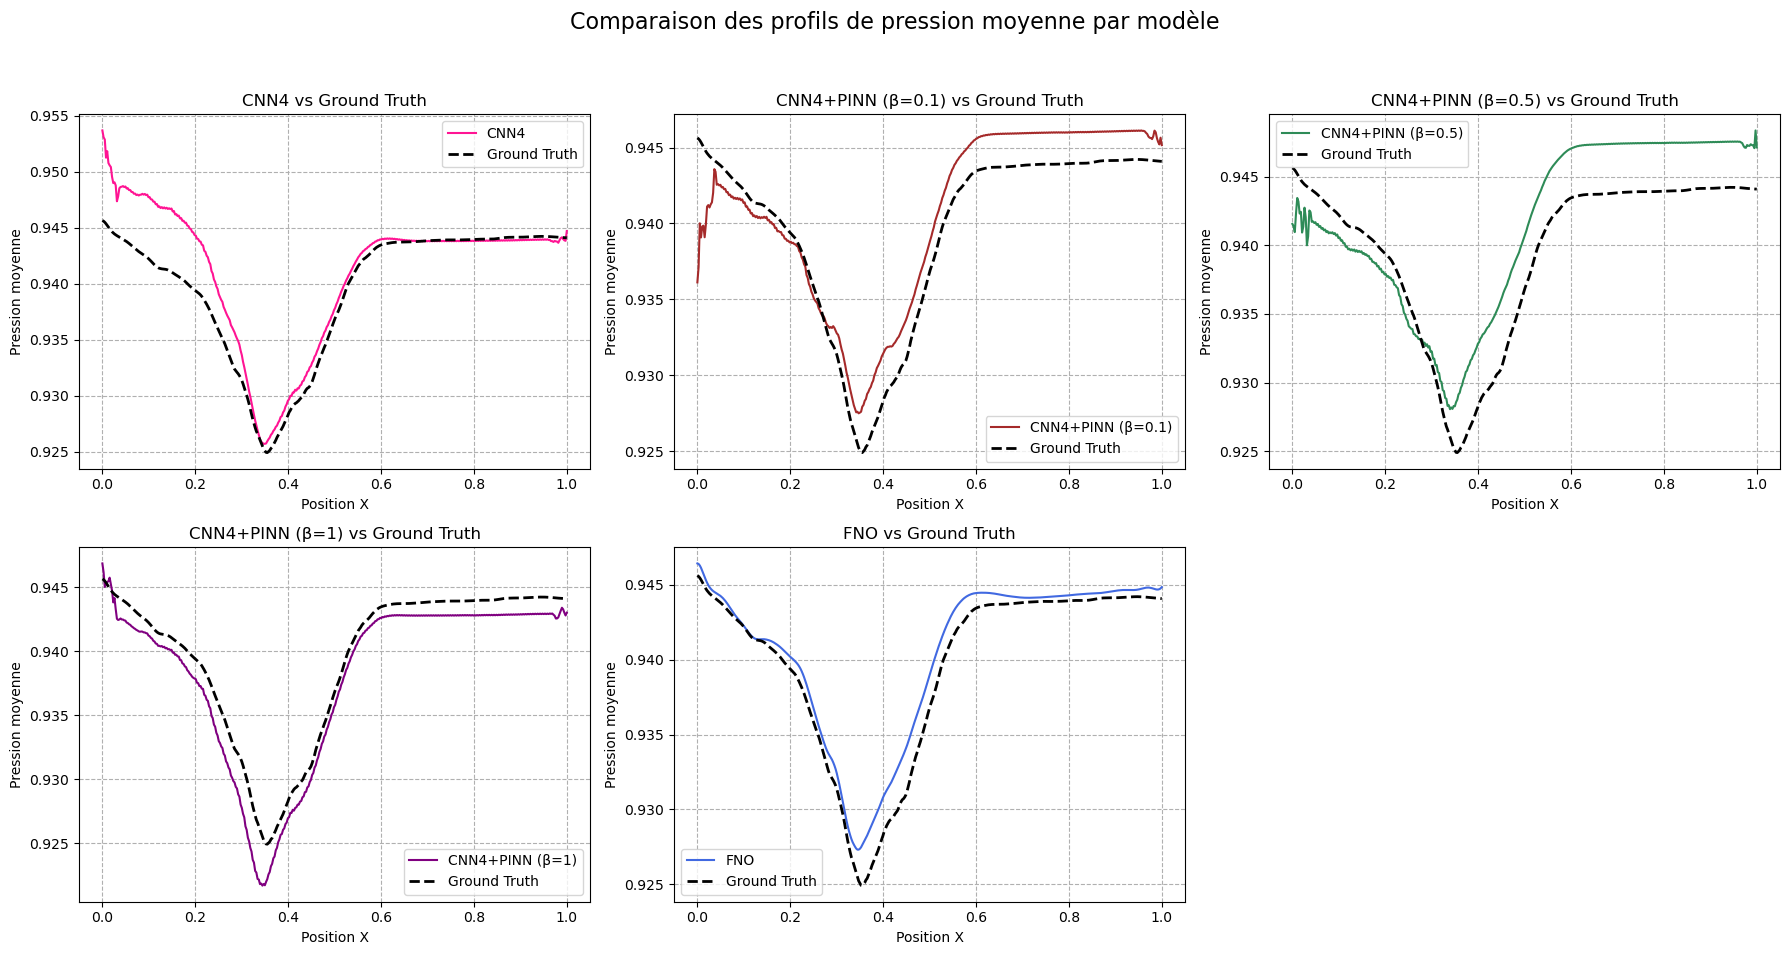

In [233]:
x_vals = np.linspace(0, 1, pressure_true_mean.shape[0])

models = {
    'CNN4': pressure_cnn4_mean,
    'CNN4+PINN (β=0.1)': pressure_cnn4_pinn01_mean,
    'CNN4+PINN (β=0.5)': pressure_cnn4_pinn05_mean,
    'CNN4+PINN (β=1)': pressure_cnn4_pinn1_mean,
    'FNO': pressure_fno_mean
}

colors = {
    'CNN4': 'deeppink',
    'CNN4+PINN (β=0.1)': 'brown',
    'CNN4+PINN (β=0.5)': 'seagreen',
    'CNN4+PINN (β=1)': 'purple',
    'FNO': 'royalblue'
}

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, (model_name, pressure_profile) in enumerate(models.items()):
    axs[i].plot(x_vals, pressure_profile, label=model_name, color=colors[model_name])
    axs[i].plot(x_vals, pressure_true_mean, label='Ground Truth', color='black', linestyle='--', linewidth=2)
    axs[i].set_xlabel("Position X")
    axs[i].set_ylabel("Pression moyenne")
    axs[i].set_title(f"{model_name} vs Ground Truth")
    axs[i].grid(True, which="both", ls="--")
    axs[i].legend()

fig.delaxes(axs[-1])

plt.suptitle("Comparaison des profils de pression moyenne par modèle", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("pressure_profiles_per_model_meaned.png", dpi=300)
plt.show()

## Comparaison des profils de température moyenne

La température est définie par la relation $T=\frac{P}{\rho}$ où P est la pression et $\rho$ la densité. Cette formule découle d'une simplification de la loi des gaz parfaits, rendue possible par l'utilisation d'unités adimensionnées où les constantes physiques usuelles  sont normalisées à 1.

Pour ce faire, on calcule la température en filtrant les très faibles densités, puis on effectue un moyennage de T le long de y, et on compare avec le ground truth.

In [271]:
# On utilise le même échantillon que pour la pression
item = validset[123]

x = item["input_fields"].to(device)
y_true = item["output_fields"].to(device)

x = preprocess(x)
x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

model_cnn4.eval()
model_cnn4_pinn_01.eval()
model_cnn4_pinn_05.eval()
model_cnn4_pinn_1.eval()
model_fno.eval()

with torch.no_grad():
    pred_cnn4 = model_cnn4(x_in).squeeze(0).permute(1, 2, 0)
    pred_cnn4 = postprocess(pred_cnn4)

    pred_cnn4_pinn01 = model_cnn4_pinn_01(x_in).squeeze(0).permute(1, 2, 0)
    pred_cnn4_pinn01 = postprocess(pred_cnn4_pinn01)

    pred_cnn4_pinn05 = model_cnn4_pinn_05(x_in).squeeze(0).permute(1, 2, 0)
    pred_cnn4_pinn05 = postprocess(pred_cnn4_pinn05)

    pred_cnn4_pinn1 = model_cnn4_pinn_1(x_in).squeeze(0).permute(1, 2, 0)
    pred_cnn4_pinn1 = postprocess(pred_cnn4_pinn1)

    pred_fno = model_fno(x_in).squeeze(0)
    pred_fno = rearrange(pred_fno, "(To F) H W -> To H W F", To=1, F=4)[0]
    pred_fno = postprocess(pred_fno)


# Fonction pour extraire la température
def compute_temperature(pred):
    density = pred[:, :, 0].cpu().numpy()
    pressure = pred[:, :, 1].cpu().numpy()
    temperature = pressure / (density + 1e-8)
    temperature_mean = temperature.mean(axis=0)  # moyenne sur Y
    return temperature_mean

temperature_cnn4_mean = compute_temperature(pred_cnn4)
temperature_cnn4_pinn01_mean = compute_temperature(pred_cnn4_pinn01)
temperature_cnn4_pinn05_mean = compute_temperature(pred_cnn4_pinn05)
temperature_cnn4_pinn1_mean = compute_temperature(pred_cnn4_pinn1)
temperature_fno_mean = compute_temperature(pred_fno)

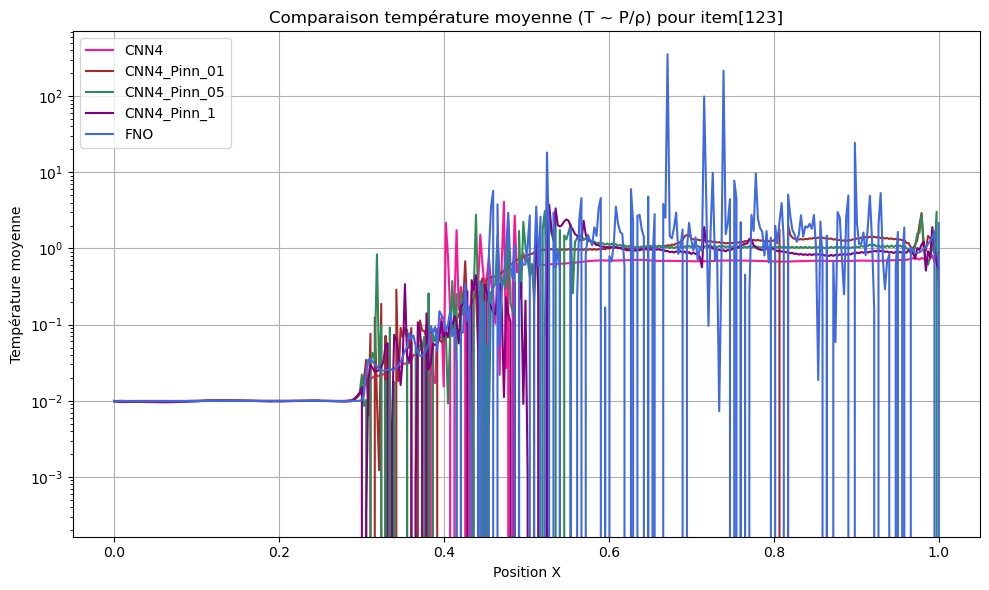

In [272]:
x_vals = np.linspace(0, 1, temperature_cnn4.shape[1])  # Normaliser X entre 0 et 1

plt.figure(figsize=(10,6))
plt.plot(x_vals, temperature_cnn4_mean, label='CNN4', color='deeppink')
plt.plot(x_vals, temperature_cnn4_pinn01_mean, label='CNN4_Pinn_01', color='brown')
plt.plot(x_vals, temperature_cnn4_pinn05_mean, label='CNN4_Pinn_05', color='seagreen')
plt.plot(x_vals, temperature_cnn4_pinn1_mean, label='CNN4_Pinn_1', color='purple')
plt.plot(x_vals, temperature_fno_mean, label='FNO', color='royalblue')

plt.yscale('log')  
plt.xlabel("Position X")
plt.ylabel("Température moyenne")
plt.title("Comparaison température moyenne (T ~ P/ρ) pour item[123]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("temperature_profiles.png", dpi=300)
plt.show()


Ceci est la prédiction avant filtrage et lissage. 

In [277]:
# Fonction de lissage 
def smooth(data, window_size=15):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')


# Ground truth : densité et pression
true_density = y_true[0, :, :, 0].cpu().numpy()  # (H, W)
true_pressure = y_true[0, :, :, 1].cpu().numpy()

# Masque pour éviter les très faibles densités
density_threshold = 1e-3
mask = (true_density > density_threshold)

# Calculer température seulement sur les bons pixels
true_temperature = np.zeros_like(true_density)
true_temperature[mask] = true_pressure[mask] / (true_density[mask] + 1e-8)

# Moyenne sur Y
true_temperature_mean = true_temperature.mean(axis=0)


def process_temperature(pred_density, pred_pressure):
    pred_density = pred_density.cpu().numpy()
    pred_pressure = pred_pressure.cpu().numpy()
    
    mask = (pred_density > density_threshold)
    temperature = np.zeros_like(pred_density)
    temperature[mask] = pred_pressure[mask] / (pred_density[mask] + 1e-8)
    
    temperature_mean = temperature.mean(axis=0)
    return temperature_mean

# CNN4
density_cnn4 = pred_cnn4[:, :, 0]
pressure_cnn4 = pred_cnn4[:, :, 1]
temperature_cnn4_mean = process_temperature(density_cnn4, pressure_cnn4)

# CNN4_Pinn_01
density_cnn4_pinn01 = pred_cnn4_pinn01[:, :, 0]
pressure_cnn4_pinn01 = pred_cnn4_pinn01[:, :, 1]
temperature_cnn4_pinn01_mean = process_temperature(density_cnn4_pinn01, pressure_cnn4_pinn01)

# CNN4_Pinn_05
density_cnn4_pinn05 = pred_cnn4_pinn05[:, :, 0]
pressure_cnn4_pinn05 = pred_cnn4_pinn05[:, :, 1]
temperature_cnn4_pinn05_mean = process_temperature(density_cnn4_pinn05, pressure_cnn4_pinn05)

# CNN4_Pinn_1
density_cnn4_pinn1 = pred_cnn4_pinn1[:, :, 0]
pressure_cnn4_pinn1 = pred_cnn4_pinn1[:, :, 1]
temperature_cnn4_pinn1_mean = process_temperature(density_cnn4_pinn1, pressure_cnn4_pinn1)

# FNO
density_fno = pred_fno[:, :, 0]
pressure_fno = pred_fno[:, :, 1]
temperature_fno_mean = process_temperature(density_fno, pressure_fno)

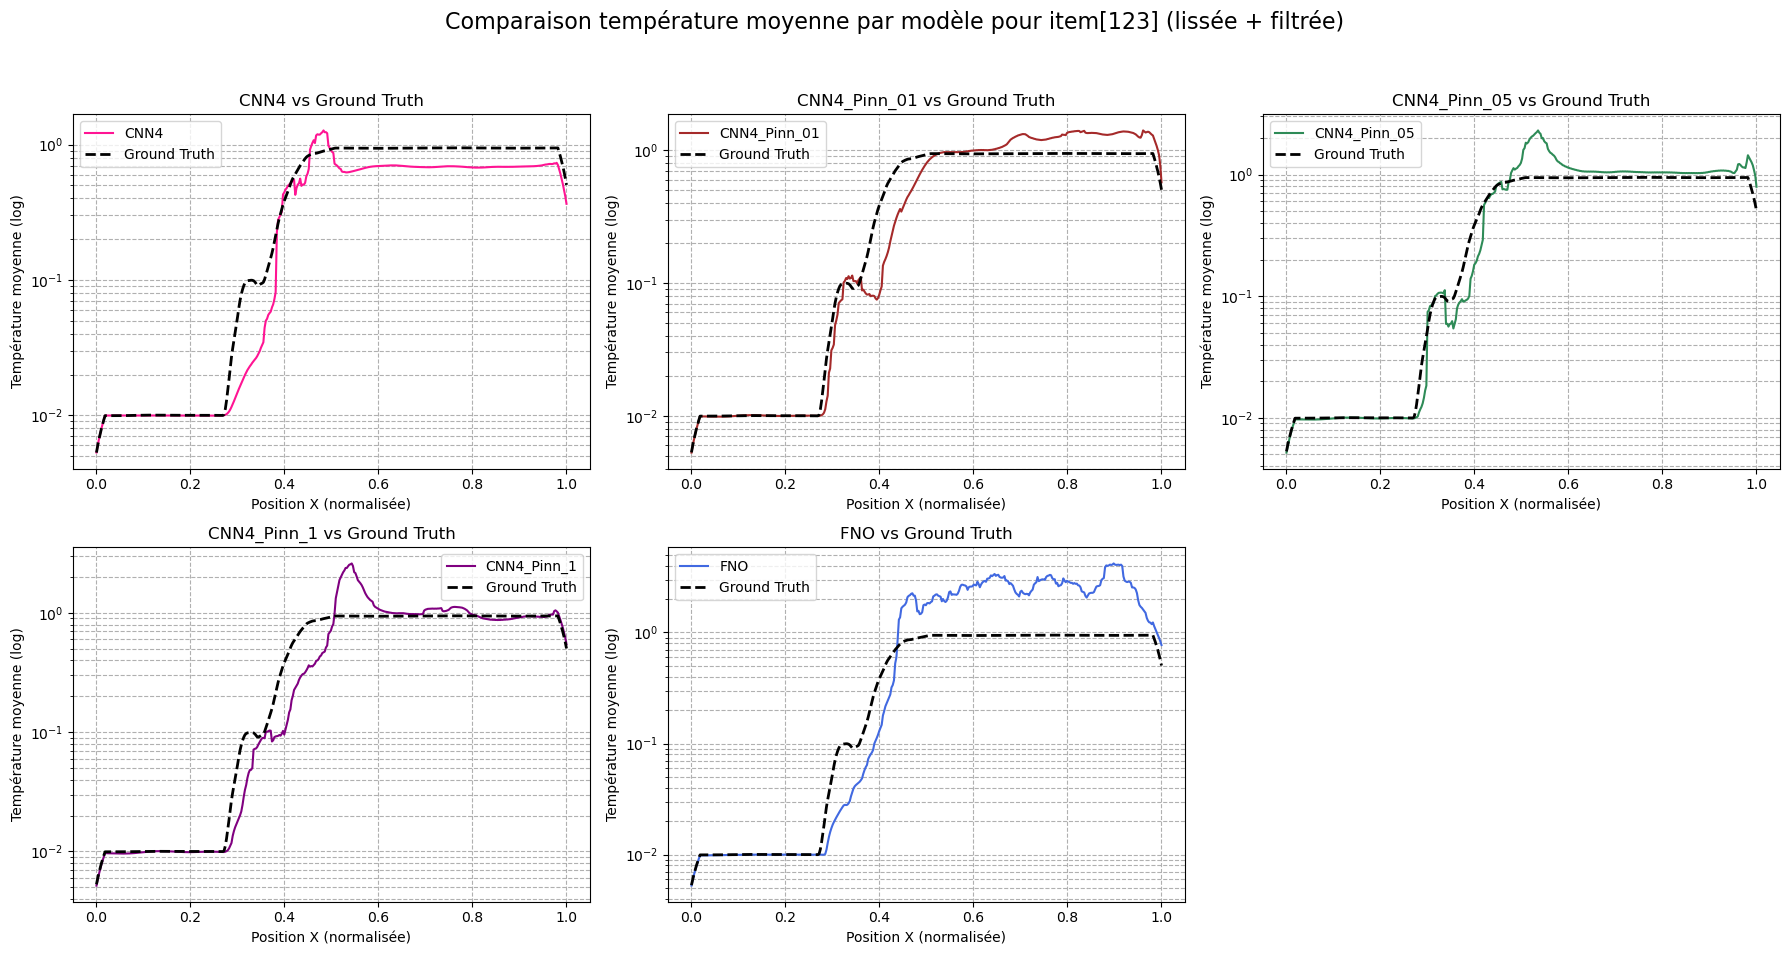

In [280]:
models = {
    'CNN4': smooth(temperature_cnn4_mean),
    'CNN4_Pinn_01': smooth(temperature_cnn4_pinn01_mean),
    'CNN4_Pinn_05': smooth(temperature_cnn4_pinn05_mean),
    'CNN4_Pinn_1': smooth(temperature_cnn4_pinn1_mean),
    'FNO': smooth(temperature_fno_mean)
}

colors = {
    'CNN4': 'deeppink',
    'CNN4_Pinn_01': 'brown',
    'CNN4_Pinn_05': 'seagreen',
    'CNN4_Pinn_1': 'purple',
    'FNO': 'royalblue'
}

x_vals = np.linspace(0, 1, true_temperature_mean.shape[0])
true_temp_smooth = smooth(true_temperature_mean)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

axs = axs.flatten()

for i, (model_name, temp_profile) in enumerate(models.items()):
    axs[i].plot(x_vals, temp_profile, label=model_name, color=colors[model_name])
    axs[i].plot(x_vals, true_temp_smooth, label='Ground Truth', color='black', linestyle='--', linewidth=2)
    axs[i].set_yscale('log')
    axs[i].set_xlabel("Position X (normalisée)")
    axs[i].set_ylabel("Température moyenne (log)")
    axs[i].set_title(f"{model_name} vs Ground Truth")
    axs[i].grid(True, which="both", ls="--")
    axs[i].legend()

fig.delaxes(axs[-1])
plt.suptitle("Comparaison température moyenne par modèle pour item[123] (lissée + filtrée)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("temperature_profiles_per_model_item123.png", dpi=300)
plt.show()

In [81]:
# Fonction pour filtrer sur la densité et extraire température moyenne en Y
def process_temperature(pred_density, pred_pressure, density_threshold=1e-3):
    pred_density = pred_density.cpu().numpy()
    pred_pressure = pred_pressure.cpu().numpy()
    
    mask = (pred_density > density_threshold)
    temperature = np.zeros_like(pred_density)
    temperature[mask] = pred_pressure[mask] / (pred_density[mask] + 1e-8)
    
    temperature_mean = temperature.mean(axis=0)  # moyenne sur Y
    return temperature_mean

In [238]:
temperature_cnn4_all = []
temperature_cnn4_pinn01_all = []
temperature_cnn4_pinn05_all = []
temperature_cnn4_pinn1_all = []
temperature_fno_all = []
true_temperature_all = []

for idx in tqdm(range(len(validset)), desc="Traitement température moyenne validset"):

    item = validset[idx]

    x = item["input_fields"].to(device)
    y_true = item["output_fields"].to(device)

    x = preprocess(x)
    x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

    model_cnn4.eval()
    model_cnn4_pinn_01.eval()
    model_cnn4_pinn_05.eval()
    model_cnn4_pinn_1.eval()
    model_fno.eval()

    with torch.no_grad():
        pred_cnn4 = model_cnn4(x_in).squeeze(0).permute(1,2,0)
        pred_cnn4_pinn01 = model_cnn4_pinn_01(x_in).squeeze(0).permute(1,2,0)
        pred_cnn4_pinn05 = model_cnn4_pinn_05(x_in).squeeze(0).permute(1,2,0)
        pred_cnn4_pinn1 = model_cnn4_pinn_1(x_in).squeeze(0).permute(1,2,0)
        pred_fno = model_fno(x_in).squeeze(0)
        pred_fno = rearrange(pred_fno, "(To F) H W -> To H W F", To=1, F=4)[0]

    pred_cnn4 = postprocess(pred_cnn4)
    pred_cnn4_pinn01 = postprocess(pred_cnn4_pinn01)
    pred_cnn4_pinn05 = postprocess(pred_cnn4_pinn05)
    pred_cnn4_pinn1 = postprocess(pred_cnn4_pinn1)
    pred_fno = postprocess(pred_fno)

    temperature_cnn4_all.append(process_temperature(pred_cnn4[:, :, 0], pred_cnn4[:, :, 1]))
    temperature_cnn4_pinn01_all.append(process_temperature(pred_cnn4_pinn01[:, :, 0], pred_cnn4_pinn01[:, :, 1]))
    temperature_cnn4_pinn05_all.append(process_temperature(pred_cnn4_pinn05[:, :, 0], pred_cnn4_pinn05[:, :, 1]))
    temperature_cnn4_pinn1_all.append(process_temperature(pred_cnn4_pinn1[:, :, 0], pred_cnn4_pinn1[:, :, 1]))
    temperature_fno_all.append(process_temperature(pred_fno[:, :, 0], pred_fno[:, :, 1]))

    # Ground truth
    true_density = y_true[0, :, :, 0].cpu().numpy()
    true_pressure = y_true[0, :, :, 1].cpu().numpy()
    mask = (true_density > 1e-3)
    true_temperature = np.zeros_like(true_density)
    true_temperature[mask] = true_pressure[mask] / (true_density[mask] + 1e-8)
    true_temperature_mean = true_temperature.mean(axis=0)
    true_temperature_all.append(true_temperature_mean)

temperature_cnn4_mean = np.mean(temperature_cnn4_all, axis=0)
temperature_cnn4_pinn01_mean = np.mean(temperature_cnn4_pinn01_all, axis=0)
temperature_cnn4_pinn05_mean = np.mean(temperature_cnn4_pinn05_all, axis=0)
temperature_cnn4_pinn1_mean = np.mean(temperature_cnn4_pinn1_all, axis=0)
temperature_fno_mean = np.mean(temperature_fno_all, axis=0)
true_temperature_mean = np.mean(true_temperature_all, axis=0)

Traitement température moyenne validset: 100%|███████████████████████████████████████| 873/873 [01:06<00:00, 13.11it/s]


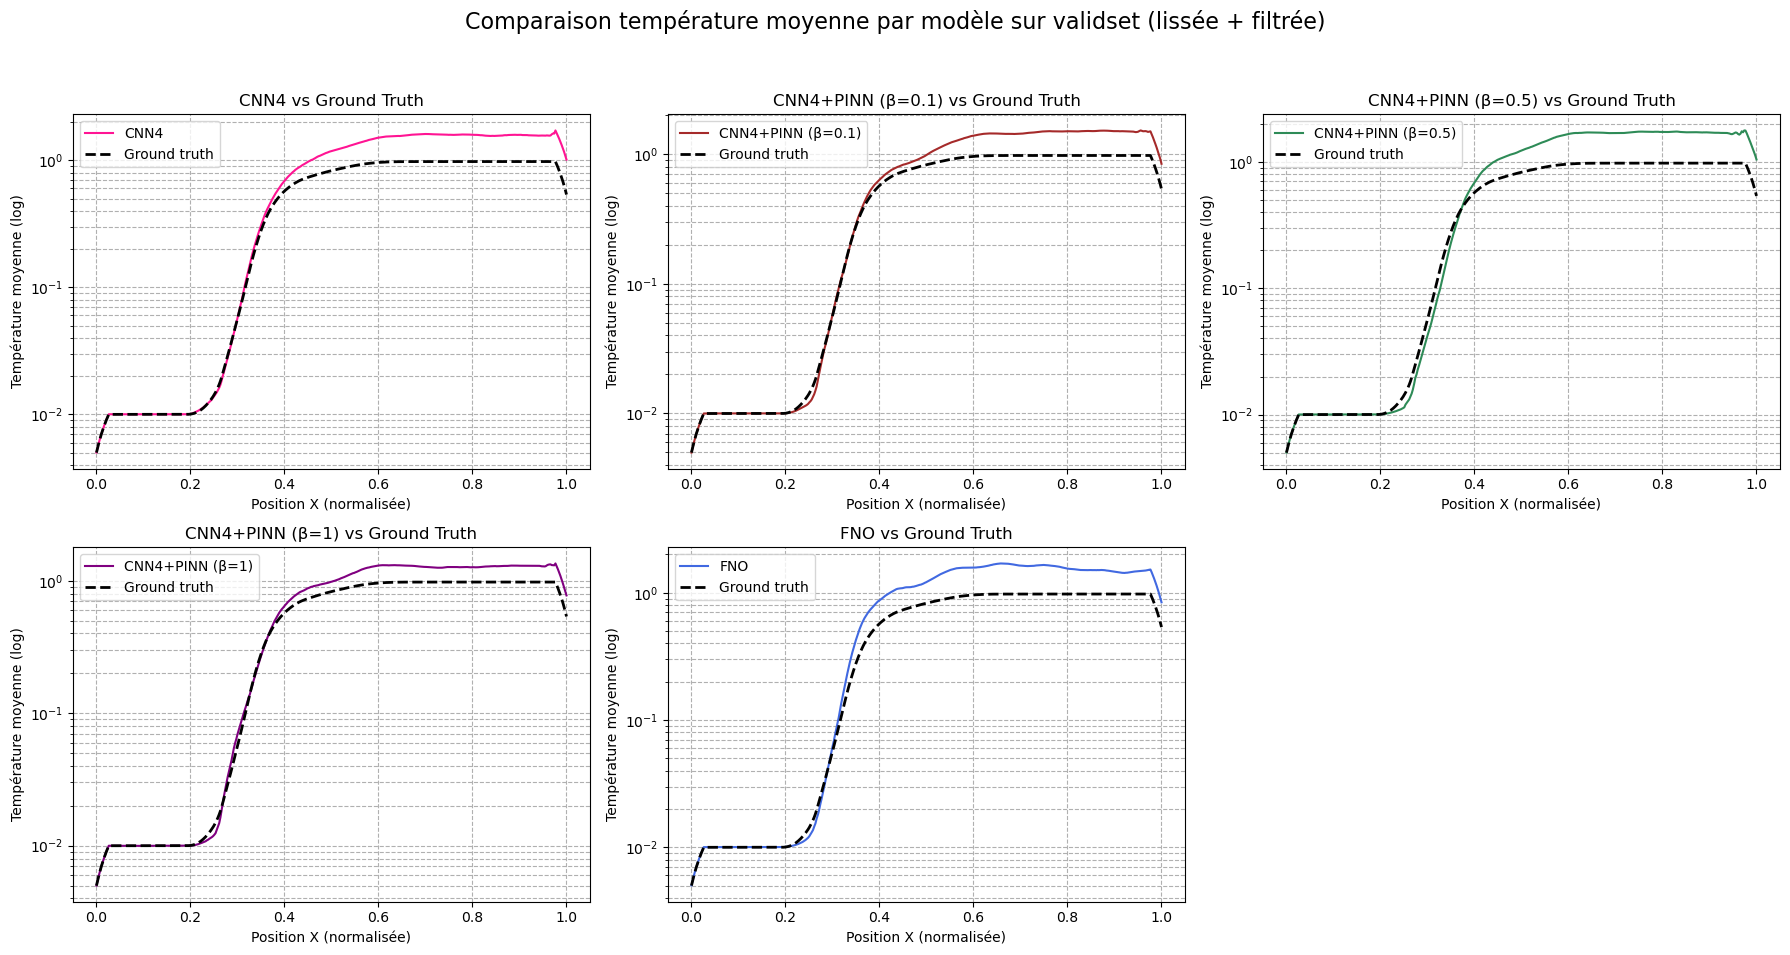

In [239]:
models = {
    'CNN4': smooth(temperature_cnn4_mean),
    'CNN4+PINN (β=0.1)': smooth(temperature_cnn4_pinn01_mean),
    'CNN4+PINN (β=0.5)': smooth(temperature_cnn4_pinn05_mean),
    'CNN4+PINN (β=1)': smooth(temperature_cnn4_pinn1_mean),
    'FNO': smooth(temperature_fno_mean)
}

colors = {
    'CNN4': 'deeppink',
    'CNN4+PINN (β=0.1)': 'brown',
    'CNN4+PINN (β=0.5)': 'seagreen',
    'CNN4+PINN (β=1)': 'purple',
    'FNO': 'royalblue'
}
x_vals = np.linspace(0, 1, true_temperature_mean.shape[0])
true_temp_smooth = smooth(true_temperature_mean)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs = axs.flatten()

for i, (model_name, temp_profile) in enumerate(models.items()):
    axs[i].plot(x_vals, temp_profile, label=model_name, color=colors[model_name])
    axs[i].plot(x_vals, true_temp_smooth, label='Ground truth', color='black', linestyle='--', linewidth=2)
    axs[i].set_yscale('log')
    axs[i].set_xlabel("Position X (normalisée)")
    axs[i].set_ylabel("Température moyenne (log)")
    axs[i].set_title(f"{model_name} vs Ground Truth")
    axs[i].grid(True, which="both", ls="--")
    axs[i].legend()

fig.delaxes(axs[-1])

plt.suptitle("Comparaison température moyenne par modèle sur validset (lissée + filtrée)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("temperature_profiles_per_model_validset.png", dpi=300)
plt.show()

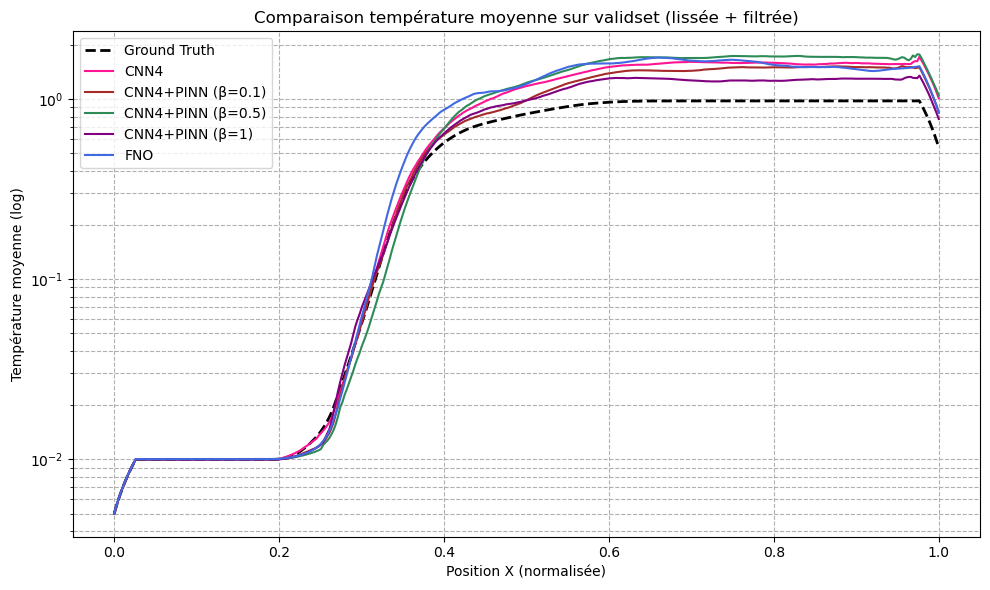

In [243]:
models = {
    'CNN4': smooth(temperature_cnn4_mean),
    'CNN4+PINN (β=0.1)': smooth(temperature_cnn4_pinn01_mean),
    'CNN4+PINN (β=0.5)': smooth(temperature_cnn4_pinn05_mean),
    'CNN4+PINN (β=1)': smooth(temperature_cnn4_pinn1_mean),
    'FNO': smooth(temperature_fno_mean)
}

colors = {
    'CNN4': 'deeppink',
    'CNN4+PINN (β=0.1)': 'brown',
    'CNN4+PINN (β=0.5)': 'seagreen',
    'CNN4+PINN (β=1)': 'purple',
    'FNO': 'royalblue'
}

x_vals = np.linspace(0, 1, true_temperature_mean.shape[0])
true_temp_smooth = smooth(true_temperature_mean)

plt.figure(figsize=(10,6))
plt.plot(x_vals, true_temp_smooth, label='Ground Truth', color='black', linestyle='--', linewidth=2)
for model_name, temp_profile in models.items():
    plt.plot(x_vals, temp_profile, label=model_name, color=colors[model_name])

plt.yscale('log')
plt.xlabel("Position X (normalisée)")
plt.ylabel("Température moyenne (log)")
plt.title("Comparaison température moyenne sur validset (lissée + filtrée)")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()


## Évaluation du Cold Mass Fraction (CMF)

Le Cold Mass Fraction est un indicateur physique clé pour caractériser la quantité de gaz froid formé dans le système. Il est défini comme le rapport entre la masse de gaz ayant une température inférieure à la moitié de la température chaude et la masse totale du gaz : $\text{CMF} = \frac{\text{Masse totale du gaz froid}}{\text{Masse totale du gaz}}$, avec la condition $\frac{T(x, y)}{T_{\text{hot}}} < 0.5$



Pour évaluer correctement le CMF :
- La température T est calculée à partir de la pression P et de la densité ρ via la relation T=P/ρ
- La température chaude $T_{hot}$ est définie comme la moyenne de T dans la zone chaude du domaine (x>0.8)
- Un masque est appliqué pour identifier les régions où $T/T_{hot}<0.5$, définissant ainsi le gaz froid

In [235]:
# Fonction pour calculer le Cold Mass Fraction
def compute_cold_mass_fraction(density, pressure, T_hot, threshold=0.5):
    T = pressure / (density + 1e-8)
    T_norm = T / T_hot  # Normalisation
    cold_mask = T_norm < threshold
    cold_mass = np.sum(density[cold_mask])
    total_mass = np.sum(density)
    return cold_mass / total_mass

n_items = len(validset)  
threshold_cold = 0.5  # Seuil de froid

indices = np.arange(n_items)

cmf_cnn4_list = []
cmf_cnn4_pinn01_list = []
cmf_cnn4_pinn05_list = []
cmf_cnn4_pinn1_list = []
cmf_fno_list = []

for idx in tqdm(indices, desc="Traitement CMF sur items"):
    item = validset[idx]

    x = item["input_fields"].to(device)
    y_true = item["output_fields"].to(device)

    x = preprocess(x)
    x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

    with torch.no_grad():
        pred_cnn4 = model_cnn4(x_in).squeeze(0).permute(1,2,0)
        pred_cnn4_pinn01 = model_cnn4_pinn_01(x_in).squeeze(0).permute(1,2,0)
        pred_cnn4_pinn05 = model_cnn4_pinn_05(x_in).squeeze(0).permute(1,2,0)
        pred_cnn4_pinn1 = model_cnn4_pinn_1(x_in).squeeze(0).permute(1,2,0)
        pred_fno = model_fno(x_in).squeeze(0)
        pred_fno = rearrange(pred_fno, "(To F) H W -> To H W F", To=1, F=4)[0]

    pred_cnn4 = postprocess(pred_cnn4)
    pred_cnn4_pinn01 = postprocess(pred_cnn4_pinn01)
    pred_cnn4_pinn05 = postprocess(pred_cnn4_pinn05)
    pred_cnn4_pinn1 = postprocess(pred_cnn4_pinn1)
    pred_fno = postprocess(pred_fno)

    # Densité et pression
    density_cnn4 = pred_cnn4[:, :, 0].cpu().numpy()
    pressure_cnn4 = pred_cnn4[:, :, 1].cpu().numpy()

    density_cnn4_pinn01 = pred_cnn4_pinn01[:, :, 0].cpu().numpy()
    pressure_cnn4_pinn01 = pred_cnn4_pinn01[:, :, 1].cpu().numpy()

    density_cnn4_pinn05 = pred_cnn4_pinn05[:, :, 0].cpu().numpy()
    pressure_cnn4_pinn05 = pred_cnn4_pinn05[:, :, 1].cpu().numpy()

    density_cnn4_pinn1 = pred_cnn4_pinn1[:, :, 0].cpu().numpy()
    pressure_cnn4_pinn1 = pred_cnn4_pinn1[:, :, 1].cpu().numpy()

    density_fno = pred_fno[:, :, 0].cpu().numpy()
    pressure_fno = pred_fno[:, :, 1].cpu().numpy()

    # Définir l'axe X (normalisé entre 0 et 1)
    x_axis = np.linspace(0, 1, density_cnn4.shape[1])

    # Définir la zone "hot"
    mask_hot = x_axis > 0.8

    temperature_cnn4 = pressure_cnn4 / (density_cnn4 + 1e-8)
    temperature_cnn4_pinn01 = pressure_cnn4_pinn01 / (density_cnn4_pinn01 + 1e-8)
    temperature_cnn4_pinn05 = pressure_cnn4_pinn05 / (density_cnn4_pinn05 + 1e-8)
    temperature_cnn4_pinn1 = pressure_cnn4_pinn1 / (density_cnn4_pinn1 + 1e-8)
    temperature_fno = pressure_fno / (density_fno + 1e-8)

    # T_hot = moyenne sur la zone chaude
    T_hot_cnn4 = np.mean(temperature_cnn4[:, mask_hot])
    T_hot_cnn4_pinn01 = np.mean(temperature_cnn4_pinn01[:, mask_hot])
    T_hot_cnn4_pinn05 = np.mean(temperature_cnn4_pinn05[:, mask_hot])
    T_hot_cnn4_pinn1 = np.mean(temperature_cnn4_pinn1[:, mask_hot])
    T_hot_fno = np.mean(temperature_fno[:, mask_hot])

    # CMF
    cmf_cnn4_list.append(compute_cold_mass_fraction(density_cnn4, pressure_cnn4, T_hot_cnn4, threshold_cold))
    cmf_cnn4_pinn01_list.append(compute_cold_mass_fraction(density_cnn4_pinn01, pressure_cnn4_pinn01, T_hot_cnn4_pinn01, threshold_cold))
    cmf_cnn4_pinn05_list.append(compute_cold_mass_fraction(density_cnn4_pinn05, pressure_cnn4_pinn05, T_hot_cnn4_pinn05, threshold_cold))
    cmf_cnn4_pinn1_list.append(compute_cold_mass_fraction(density_cnn4_pinn1, pressure_cnn4_pinn1, T_hot_cnn4_pinn1, threshold_cold))
    cmf_fno_list.append(compute_cold_mass_fraction(density_fno, pressure_fno, T_hot_fno, threshold_cold))

# Résultats finaux
print("\n Résultats Cold Mass fraction sur le validset")
print(f"CMF CNN4              : {np.mean(cmf_cnn4_list):.4f}")
print(f"CMF CNN4+PINN (β=0.1) : {np.mean(cmf_cnn4_pinn01_list):.4f}")
print(f"CMF CNN4+PINN (β=0.5) : {np.mean(cmf_cnn4_pinn05_list):.4f}")
print(f"CMF CNN4+PINN (β=1)   : {np.mean(cmf_cnn4_pinn1_list):.4f}")
print(f"CMF FNO               : {np.mean(cmf_fno_list):.4f}")

Traitement CMF sur items: 100%|██████████████████████████████████████████████████████| 873/873 [01:05<00:00, 13.39it/s]


 Résultats Cold Mass fraction sur le validset
CMF CNN4              : 0.9857
CMF CNN4+PINN (β=0.1) : 0.9842
CMF CNN4+PINN (β=0.5) : 0.9886
CMF CNN4+PINN (β=1)   : 0.9853
CMF FNO               : 0.9885


Les résultats montrent que tous les modèles sont capables de prédire un CMF élevé (supérieur à 98%), ce qui est cohérent avec la physique du problème simulé.
Cependant, on note de légères différences selon les modèles. Le CNN4+PINN ($\beta=0.5$) et le FNO présentent les meilleures estimations du CMF, avec une valeur proche de 0.988.

## Profils de pression et de température moyenne pour CNN4+PINN2 (masse + énergie)

Dans cette dernière étape, nous analysons les prédictions obtenues avec le modèle CNN4+PINN2, qui a été entraîné en imposant simultanément la conservation de la masse et la conservation de l’énergie totale avec refroidissement. L'objectif est de vérifier comment cette double contrainte physique influence les profils de pression et de température moyens dans le domaine.

Traitement Pression + Température CNN4_Pinn2: 100%|██████████████████████████████████| 873/873 [00:18<00:00, 47.46it/s]


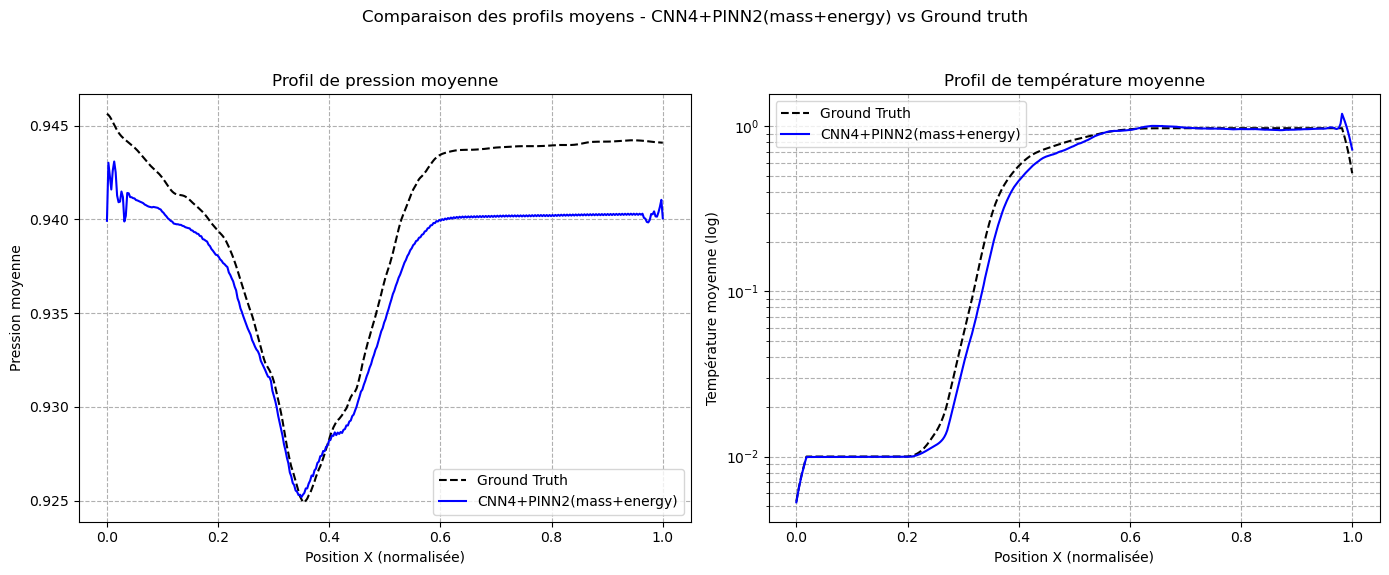

In [85]:
n_items = len(validset)
indices = np.arange(n_items)

pressure_cnn4_pinn2_all = []
temperature_cnn4_pinn2_all = []
pressure_true_all = []
temperature_true_all = []

model_cnn4_pinn2.eval()

for idx in tqdm(indices, desc="Traitement Pression + Température CNN4_Pinn2"):

    item = validset[idx]

    x = item["input_fields"].to(device)
    y_true = item["output_fields"].to(device)

    x = preprocess(x)
    x_in = rearrange(x, "T H W F -> 1 (T F) H W").to(device)

    with torch.no_grad():
        pred_cnn4_pinn2 = model_cnn4_pinn2(x_in).squeeze(0).permute(1, 2, 0)
        pred_cnn4_pinn2 = postprocess(pred_cnn4_pinn2)

    pressure_pred = pred_cnn4_pinn2[:, :, 1].cpu().numpy()
    pressure_true = y_true[0, :, :, 1].cpu().numpy()

    pressure_cnn4_pinn2_all.append(pressure_pred.mean(axis=0))
    pressure_true_all.append(pressure_true.mean(axis=0))

    density_pred = pred_cnn4_pinn2[:, :, 0]
    pressure_pred_tensor = pred_cnn4_pinn2[:, :, 1]

    def process_temperature(pred_density, pred_pressure, density_threshold=1e-3):
        pred_density = pred_density.cpu().numpy()
        pred_pressure = pred_pressure.cpu().numpy()
        mask = (pred_density > density_threshold)
        temperature = np.zeros_like(pred_density)
        temperature[mask] = pred_pressure[mask] / (pred_density[mask] + 1e-8)
        return temperature.mean(axis=0)

    temperature_pred_mean = process_temperature(density_pred, pressure_pred_tensor)
    temperature_cnn4_pinn2_all.append(temperature_pred_mean)

    true_density = y_true[0, :, :, 0].cpu().numpy()
    true_pressure = y_true[0, :, :, 1].cpu().numpy()
    mask = (true_density > 1e-3)
    true_temperature = np.zeros_like(true_density)
    true_temperature[mask] = true_pressure[mask] / (true_density[mask] + 1e-8)
    true_temperature_mean = true_temperature.mean(axis=0)
    true_temperature_all.append(true_temperature_mean)

# Moyennes finales 
pressure_cnn4_pinn2_mean = np.mean(pressure_cnn4_pinn2_all, axis=0)
pressure_true_mean = np.mean(pressure_true_all, axis=0)
temperature_cnn4_pinn2_mean = np.mean(temperature_cnn4_pinn2_all, axis=0)
true_temperature_mean = np.mean(true_temperature_all, axis=0)

# PLOT
x_vals = np.linspace(0, 1, pressure_true_mean.shape[0])

# Lissage température
true_temp_smooth = smooth(true_temperature_mean)
temp_cnn4_pinn2_smooth = smooth(temperature_cnn4_pinn2_mean)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot pression
axs[0].plot(x_vals, pressure_true_mean, label="Ground Truth", linestyle='--', color='black')
axs[0].plot(x_vals, pressure_cnn4_pinn2_mean, label="CNN4+PINN2(mass+energy)", color='blue')
axs[0].set_xlabel("Position X (normalisée)")
axs[0].set_ylabel("Pression moyenne")
axs[0].set_title("Profil de pression moyenne")
axs[0].grid(True, which="both", linestyle="--")
axs[0].legend()

# Plot température
axs[1].plot(x_vals, true_temp_smooth, label="Ground Truth", linestyle='--', color='black')
axs[1].plot(x_vals, temp_cnn4_pinn2_smooth, label="CNN4+PINN2(mass+energy)", color='blue')
axs[1].set_yscale('log')
axs[1].set_xlabel("Position X (normalisée)")
axs[1].set_ylabel("Température moyenne (log)")
axs[1].set_title("Profil de température moyenne")
axs[1].grid(True, which="both", linestyle="--")
axs[1].legend()

plt.suptitle("Comparaison des profils moyens - CNN4+PINN2(mass+energy) vs Ground truth")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("profil_moyens_pressure_temperature_cnn4pinn2_validset.png", dpi=300)
plt.show()


# Analyse dynamique : Rollout long sur un état fixe
Dans cette partie, nous analysons la capacité des modèles à prédire de manière stable sur plusieurs pas de temps consécutifs, en l'absence de recalibrage par le ground truth.
L'objectif ici n'est pas de suivre l'évolution physique réelle du système, mais de vérifier la stabilité intrinsèque des modèles lorsqu'ils doivent auto-régresser sur plusieurs steps, en visant un état cible fixe.

Le ground truth utilisé est le même à tous les pas de temps :
il ne correspond pas à une dynamique physique temporelle, mais à un état stationnaire du système.

## Méthodologie du rollout
Un rollout consiste à démarrer avec un état initial, puis à utiliser les prédictions précédentes comme nouvelles entrées à chaque pas de temps.
Ici, chaque prédiction est comparée toujours au même état cible.

Ce protocole permet d'évaluer la capacité d'un modèle à maintenir une prédiction stable face à l'accumulation d'erreurs au fil du temps.

Nous utilisons un horizon de $n_{rollout}=30$ steps.

In [98]:
def rollout_model(model, x_init, y_sequence, n_rollout=30, preprocess_fn=None, postprocess_fn=None):
    model.eval()

    x_current = x_init.clone().to(device)

    preds = []

    with torch.no_grad():
        for step in range(n_rollout):
            # Préparation
            x_input = preprocess_fn(x_current)  # Normalize
            x_input = rearrange(x_input, "T H W F -> 1 (T F) H W")

            # Prédiction
            fx = model(x_input)
            fx = rearrange(fx, "1 (T F) H W -> T H W F", T=1, F=4)
            fx = postprocess_fn(fx)

            preds.append(fx.squeeze(0).cpu())

            x_current = torch.cat([x_current[1:], fx.squeeze(0).unsqueeze(0)], dim=0)

    preds = torch.stack(preds)  # (n_rollout, H, W, F)
    return preds

def compute_rollout_mse(preds, gt_sequence):
    errors = []

    for i in range(preds.shape[0]):
        if i < gt_sequence.shape[0]:
            err = torch.mean((preds[i] - gt_sequence[i])**2).item()
            errors.append(err)
    return errors

## Évolution du MSE sur un échantillon unique
Nous commençons par analyser l'évolution de la MSE pour un échantillon donné.



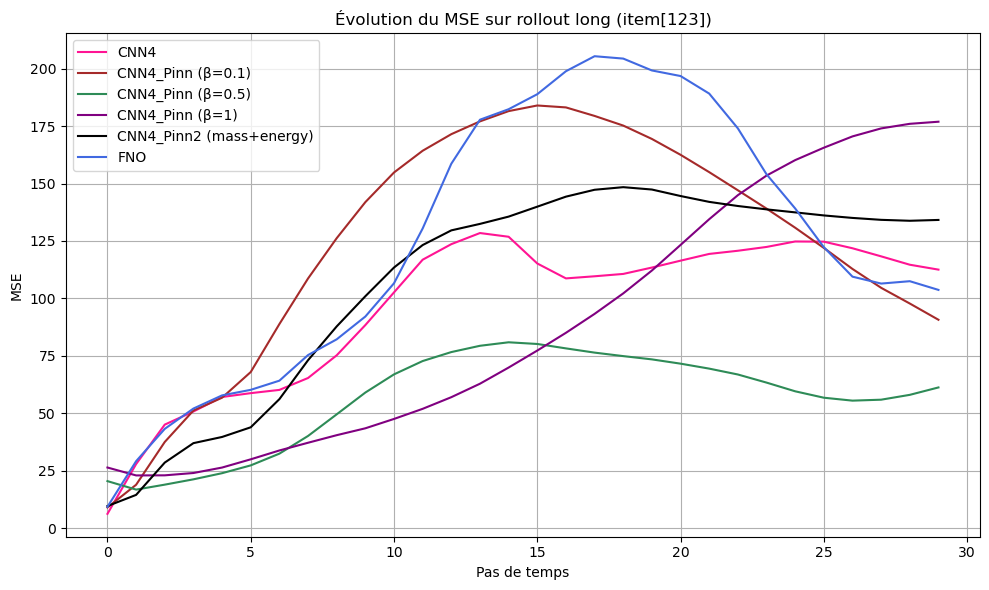

In [100]:
# Exemple choisi
item = validset[123]

x = item["input_fields"]
y = item["output_fields"]

n_rollout = 30

y_true_sequence = y.repeat(n_rollout, 1, 1, 1)

# Rollout pour chaque modèle
preds_cnn4 = rollout_model(model_cnn4, x, y, n_rollout=n_rollout, preprocess_fn=preprocess, postprocess_fn=postprocess)
preds_cnn4_pinn01 = rollout_model(model_cnn4_pinn_01, x, y, n_rollout=n_rollout, preprocess_fn=preprocess, postprocess_fn=postprocess)
preds_cnn4_pinn05 = rollout_model(model_cnn4_pinn_05, x, y, n_rollout=n_rollout, preprocess_fn=preprocess, postprocess_fn=postprocess)
preds_cnn4_pinn1 = rollout_model(model_cnn4_pinn_1, x, y, n_rollout=n_rollout, preprocess_fn=preprocess, postprocess_fn=postprocess)
preds_cnn4_pinn2 = rollout_model(model_cnn4_pinn2, x, y, n_rollout=n_rollout, preprocess_fn=preprocess, postprocess_fn=postprocess)
preds_fno = rollout_model(model_fno, x, y, n_rollout=n_rollout, preprocess_fn=preprocess, postprocess_fn=postprocess)

# Calcul des erreurs MSE sur le rollout
mse_rollout_cnn4 = compute_rollout_mse(preds_cnn4, y_true_sequence)
mse_rollout_cnn4_pinn01 = compute_rollout_mse(preds_cnn4_pinn01, y_true_sequence)
mse_rollout_cnn4_pinn05 = compute_rollout_mse(preds_cnn4_pinn05, y_true_sequence)
mse_rollout_cnn4_pinn1 = compute_rollout_mse(preds_cnn4_pinn1, y_true_sequence)
mse_rollout_cnn4_pinn2 = compute_rollout_mse(preds_cnn4_pinn2, y_true_sequence)
mse_rollout_fno = compute_rollout_mse(preds_fno, y_true_sequence)

# Plot
plt.figure(figsize=(10,6))

plt.plot(mse_rollout_cnn4, label='CNN4', color='deeppink')
plt.plot(mse_rollout_cnn4_pinn01, label='CNN4_Pinn (β=0.1)', color='brown')
plt.plot(mse_rollout_cnn4_pinn05, label='CNN4_Pinn (β=0.5)', color='seagreen')
plt.plot(mse_rollout_cnn4_pinn1, label='CNN4_Pinn (β=1)', color='purple')
plt.plot(mse_rollout_cnn4_pinn2, label='CNN4_Pinn2 (mass+energy)', color='black')
plt.plot(mse_rollout_fno, label='FNO', color='royalblue')

plt.xlabel('Pas de temps')
plt.ylabel('MSE')
plt.title('Évolution du MSE sur rollout long (item[123])')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("MSE_Rollout_all_including_pinn2.png", dpi=300, bbox_inches='tight')
plt.show()

## Évaluation statistique sur 100 rollouts
Pour obtenir une mesure plus robuste, nous effectuons 100 rollouts sur des échantillons tirés au hasard.

Rollouts multiples: 100%|████████████████████████████████████████████████████████████| 100/100 [04:14<00:00,  2.55s/it]


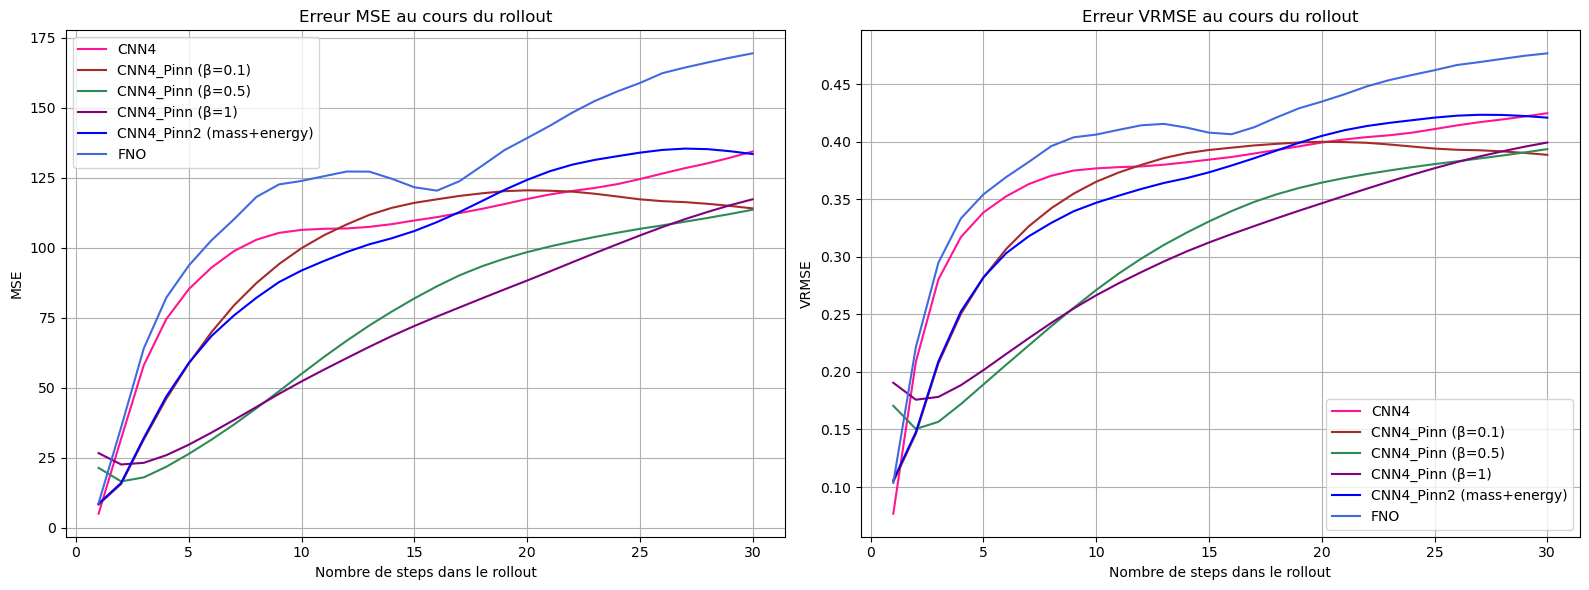

In [101]:
n_rollout = 30  # nombre de steps à prédire
n_items = 100   # nombre d'exemples tirés au hasard

indices = np.random.choice(len(validset), n_items, replace=False)

mse_rollouts = {
    'CNN4': [],
    'CNN4_Pinn (β=0.1)': [],
    'CNN4_Pinn (β=0.5)': [],
    'CNN4_Pinn (β=1)': [],
    'CNN4_Pinn2 (mass+energy)': [],
    'FNO': []
}
sigma_rollouts = []

for idx in tqdm(indices, desc="Rollouts multiples"):
    item = validset[idx]

    x = item["input_fields"]
    y = item["output_fields"]

    y_true_sequence = y.repeat(n_rollout, 1, 1, 1)

    # Calcul de sigma global du ground-truth sur la séquence
    sigma_y = torch.std(y_true_sequence).item()
    sigma_rollouts.append(sigma_y)

    # Rollouts prédits
    preds_cnn4 = rollout_model(model_cnn4, x, y, n_rollout, preprocess, postprocess)
    preds_cnn4_pinn01 = rollout_model(model_cnn4_pinn_01, x, y, n_rollout, preprocess, postprocess)
    preds_cnn4_pinn05 = rollout_model(model_cnn4_pinn_05, x, y, n_rollout, preprocess, postprocess)
    preds_cnn4_pinn1 = rollout_model(model_cnn4_pinn_1, x, y, n_rollout, preprocess, postprocess)
    preds_cnn4_pinn2 = rollout_model(model_cnn4_pinn2, x, y, n_rollout, preprocess, postprocess)  # <== ajouté
    preds_fno = rollout_model(model_fno, x, y, n_rollout, preprocess, postprocess)

    # Calcul MSE pour chaque modèle
    mse_rollouts['CNN4'].append(compute_rollout_mse(preds_cnn4, y_true_sequence))
    mse_rollouts['CNN4_Pinn (β=0.1)'].append(compute_rollout_mse(preds_cnn4_pinn01, y_true_sequence))
    mse_rollouts['CNN4_Pinn (β=0.5)'].append(compute_rollout_mse(preds_cnn4_pinn05, y_true_sequence))
    mse_rollouts['CNN4_Pinn (β=1)'].append(compute_rollout_mse(preds_cnn4_pinn1, y_true_sequence))
    mse_rollouts['CNN4_Pinn2 (mass+energy)'].append(compute_rollout_mse(preds_cnn4_pinn2, y_true_sequence))  # <== ajouté
    mse_rollouts['FNO'].append(compute_rollout_mse(preds_fno, y_true_sequence))

for k in mse_rollouts.keys():
    mse_rollouts[k] = np.array(mse_rollouts[k])  # (n_items, n_steps)

sigma_rollouts = np.array(sigma_rollouts)

# Calcul VRMSE
vrmse_rollouts = {}
for k in mse_rollouts.keys():
    vrmse_rollouts[k] = np.sqrt(mse_rollouts[k]) / sigma_rollouts[:, None]  # Normalisation item par item

# Moyennes
mse_means = {k: mse_rollouts[k].mean(axis=0) for k in mse_rollouts.keys()}
vrmse_means = {k: vrmse_rollouts[k].mean(axis=0) for k in vrmse_rollouts.keys()}

colors = {
    'CNN4': 'deeppink',
    'CNN4_Pinn (β=0.1)': 'brown',
    'CNN4_Pinn (β=0.5)': 'seagreen',
    'CNN4_Pinn (β=1)': 'purple',
    'CNN4_Pinn2 (mass+energy)': 'blue',
    'FNO': 'royalblue'
}

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# MSE
for k, v in mse_means.items():
    axs[0].plot(np.arange(1, n_rollout+1), v, label=k, color=colors.get(k, 'black'))

axs[0].set_xlabel("Nombre de steps dans le rollout")
axs[0].set_ylabel("MSE")
axs[0].set_title("Erreur MSE au cours du rollout")
axs[0].grid(True)
axs[0].legend()

# VRMSE
for k, v in vrmse_means.items():
    axs[1].plot(np.arange(1, n_rollout+1), v, label=k, color=colors.get(k, 'black'))

axs[1].set_xlabel("Nombre de steps dans le rollout")
axs[1].set_ylabel("VRMSE")
axs[1].set_title("Erreur VRMSE au cours du rollout")
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()
plt.savefig("mse_vrmse_rollouts_plot_pinn2.png", dpi=300)
plt.show()

## Visualisation des rollouts
Nous visualisons également qualitativement les champs prédits (par exemple la densité) à plusieurs pas de temps et l'évolution des erreurs absolues par rapport au ground truth constant.

Cela permet de voir comment chaque modèle maintient (ou non) sa prédiction proche de l'état cible initial au fil des itérations.

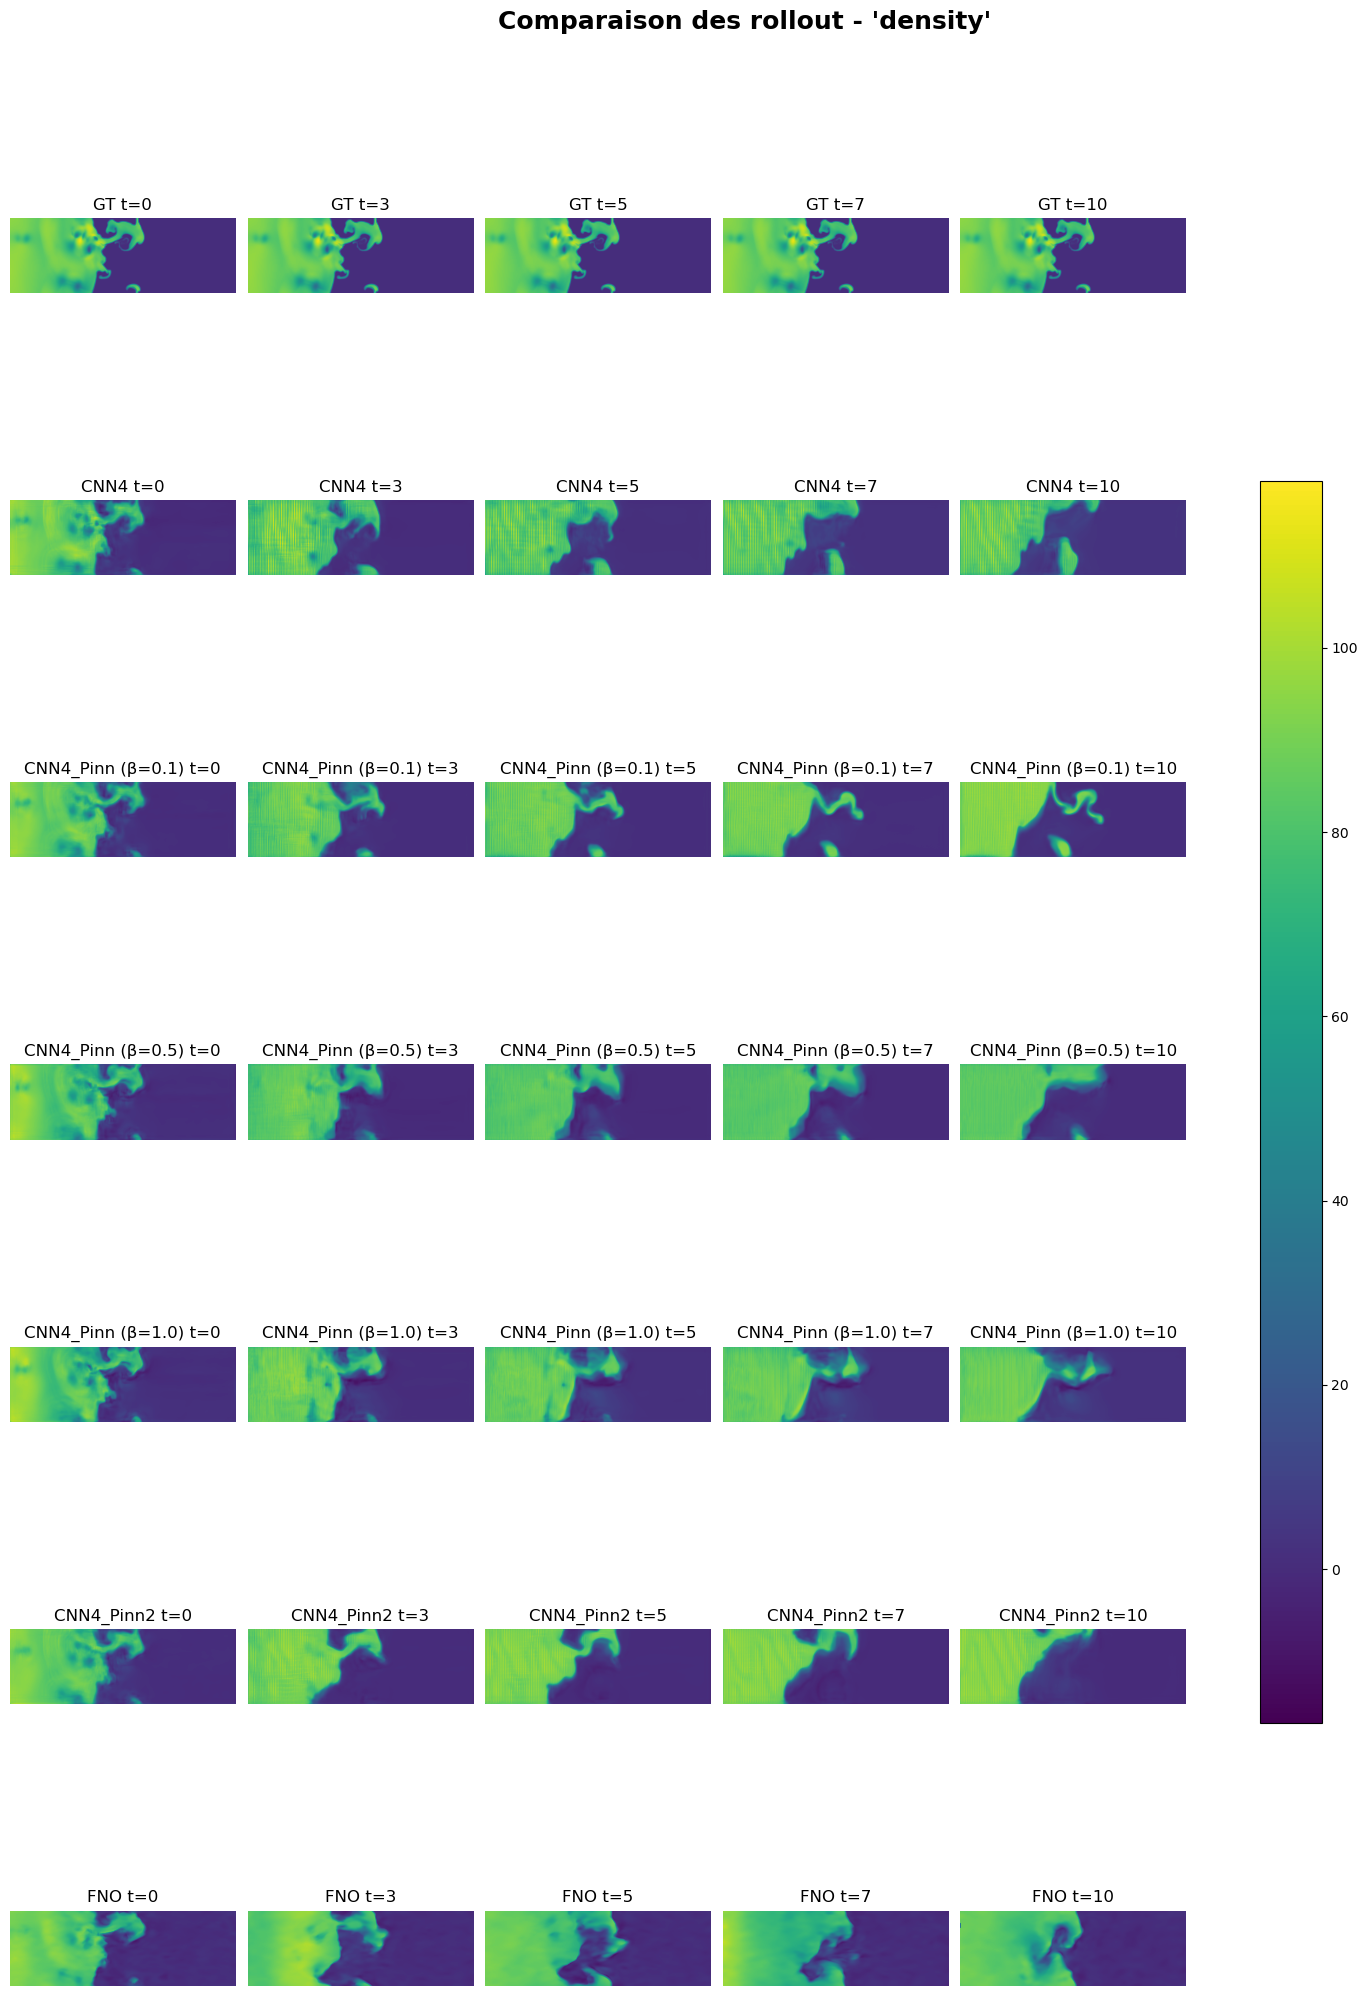

In [122]:
field_indices = {
    'density': 0,
    'pressure': 1,
    'velocity_x': 2,
    'velocity_y': 3
}

def plot_rollout_fields(preds_models, y_true_sequence, field_name='density', steps_to_plot=[0, 3, 5, 7, 10]):

    f_idx = field_indices[field_name]

    n_models = len(preds_models) + 1  # +1 pour Ground Truth
    n_steps = len(steps_to_plot)

    fig, axs = plt.subplots(n_models, n_steps, figsize=(3*n_steps, 3*n_models))
    axs = np.atleast_2d(axs)

    model_names = list(preds_models.keys())

    # Échelle globale min-max pour homogénéiser
    all_preds = [y_true_sequence[:, :, :, f_idx]] + [pred[:, :, :, f_idx] for pred in preds_models.values()]
    vmin = min([p.min().item() for p in all_preds])
    vmax = max([p.max().item() for p in all_preds])

    for i, step in enumerate(steps_to_plot):
        # Ground Truth
        im = axs[0, i].imshow(y_true_sequence[step, :, :, f_idx].cpu().numpy(), vmin=vmin, vmax=vmax, cmap="viridis")
        axs[0, i].set_title(f"GT t={step}")
        axs[0, i].axis('off')

        # Tous les modèles
        for j, model_name in enumerate(model_names):
            axs[j+1, i].imshow(preds_models[model_name][step, :, :, f_idx].cpu().numpy(), vmin=vmin, vmax=vmax, cmap="viridis")
            axs[j+1, i].set_title(f"{model_name} t={step}")
            axs[j+1, i].axis('off')

    plt.tight_layout()
    plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6)
    plt.suptitle(f"Comparaison des rollout - '{field_name}'", fontsize=18, fontweight='bold', y=1.02)
    plt.show()


preds_models = {
    'CNN4': preds_cnn4,
    'CNN4_Pinn (β=0.1)': preds_cnn4_pinn01,
    'CNN4_Pinn (β=0.5)': preds_cnn4_pinn05,
    'CNN4_Pinn (β=1.0)': preds_cnn4_pinn1,
    'CNN4_Pinn2': preds_cnn4_pinn2,
    'FNO': preds_fno
}

plot_rollout_fields(preds_models, y_true_sequence)

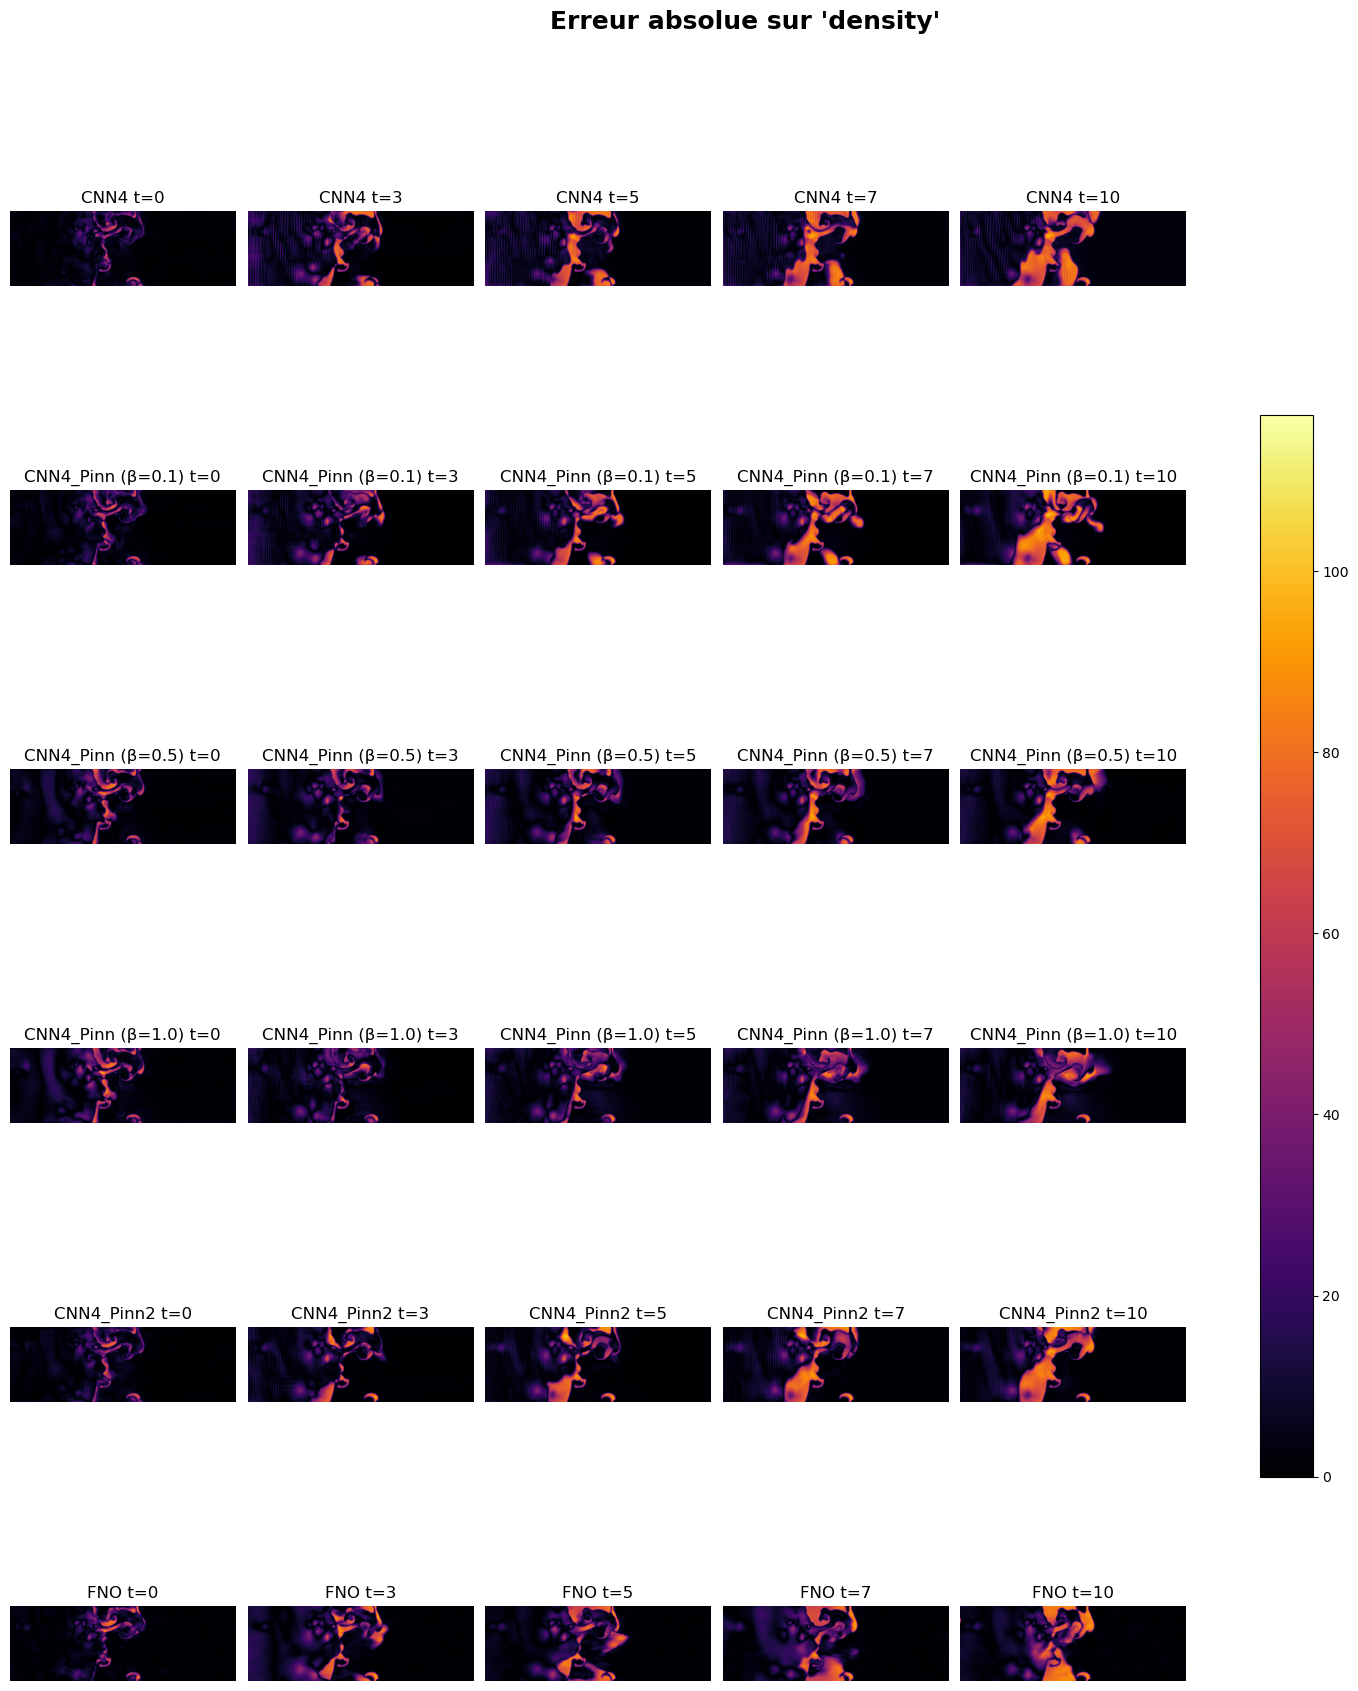

In [123]:
def plot_rollout_errors(preds_models, y_true_sequence, field_name='density', steps_to_plot=[0, 3, 5, 7, 10]):
    f_idx = field_indices[field_name]

    n_models = len(preds_models)
    n_steps = len(steps_to_plot)

    fig, axs = plt.subplots(n_models, n_steps, figsize=(3*n_steps, 3*n_models))
    axs = np.atleast_2d(axs)

    model_names = list(preds_models.keys())

    # Erreurs calculées
    errors = {}
    for model_name, preds in preds_models.items():
        errors[model_name] = torch.abs(preds[:, :, :, f_idx] - y_true_sequence[:, :, :, f_idx])

    # Échelle min-max pour toutes les erreurs
    vmin = 0
    vmax = max(err.max().item() for err in errors.values())

    for i, step in enumerate(steps_to_plot):
        for j, model_name in enumerate(model_names):
            im = axs[j, i].imshow(errors[model_name][step].cpu().numpy(), vmin=vmin, vmax=vmax, cmap="inferno")
            axs[j, i].set_title(f"{model_name} t={step}")
            axs[j, i].axis('off')

    plt.tight_layout()
    plt.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6)
    plt.suptitle(f"Erreur absolue sur '{field_name}'", fontsize=18, fontweight='bold', y=1.02)
    plt.show()

plot_rollout_errors(preds_models, y_true_sequence)